1. 목표 결과 : 24년 3분기 매출 예측

2. 사용자 입력값 : 상권명, 업종명
3. 입력한 상권명-업종명을 기준으로 매출 데이터를 추출

4. 학습 변수 : 앞서 추출한 2019~2024년 2분기까지의 매출 데이터, 해당 시기의 유동인구, 소비자물가지수, 경제심리지수

5. 소비자물가지수와 경제심리지수는 2025년 1월까지의 월 단위 데이터가 있으므로 실제 데이터를 반영하여 매출을 예측할 수 있음.

6. 선택된 상권이 해당하는 자치구를 구하고 해당 자치구와 업종에 해당하는 매출 총합을 다시 모두 합함으로써 분기별 해당 자치구-업종의 매출 총합을 구함. 이를 통해 선택 상권-업종 기반 데이터가 해당 상권이 포함된 자치구에서 차지하는 매출의 비율을 구할 수 있음.

7. 예측한 자치구 매출에 앞서 구했던 비율을 적용함으로써 선택 상권-업종의 미래(24년 3분기) 매출을 구할 수 있음.

8. 예상 매출을 출력할 때 학습한 모델을 검증한 결과도 같이 출력할 것.

1. 목표 결과 : 24년 3분기 매출 예측
	-사용 데이터에서 기준_년분기_코드 컬럼은 20191과 같은 형식으로 나타나 있으며 20242까지 있음. 사용하는 파이썬 버전은 3.12.7.

2. 사용자 입력값 : 상권명, 업종명
	-input 함수로 입력

3. 입력한 상권명-업종명을 기준으로 데이터 추출

4. 학습 변수 : 입력값을 기준으로 추출한 2019~2024년 2분기까지의 매출 및 유동인구 데이터, 소비자물가지수, 경제심리지수

5. 소비자물가지수와 경제심리지수는 1965년 1월 1일부터 2025년 1월 1일까지의 월 단위 데이터가 있으므로 실제 데이터를 반영하여 매출을 예측할 수 있음. 두 지수 모두 YYYY-MM-DD 형식임.

6. 소비자물가지수는 실시간으로, 경제심리지수는 선행적으로 소비에 영향을 미치는 지표이기 때문에 머신러닝을 할 때에 이를 반영하도록 해야 함.{특정 시기의 매출을 학습할 때 소비자물가지수는 동일 시기 3개월(2019년 1분기라면 2019년 1월 1일부터 2019년 3월 1일까지 3개의 값)의 값을 평균낸 값을 사용하고 경제심리지수는 직전 시기 3개월(2019년 1분기라면 2018년 10월 1일부터 2018년 12월 1일까지 3개의 값)을 평균낸 값을 사용함.}

7. 이용자 입력값을 통해 선택된 상권이 해당하는 자치구를 찾아 구하고 해당 자치구에 해당하는 매출 총합을 모두 합해 분기별로 해당 자치구의 매출 총합(a)을 구함. 이(a)를 상권-업종의 분기별 매출값(b)과 비교하여 분기별로 비교하면 자치구 전체 매출에서 해당 상권-업종이 차지하는 비율(c)을 구할 수 있는데 이(c)를 분기 순서대로 나열하여 학습하면 예측 시기의 매출금액(a)과 함께 상권-업종의 매출 비율(c)도 알아낼 수 있음. 이 매출 금액에 매출 비율을 적용하면 해당 시기 상권-업종의 매출(d)을 구할 수 있음.

8. 최종 결괏값(2024년 3분기 예측값)을 출력할 때는 실제 데이터에 존재하는 2024년 2분기의 경제심리지수와 2024년 3분기의 소비자물가지수를 사용하면 됨.

9. 예상 매출(d)을 출력할 때 학습한 모델을 검증한 결과도 함께 출력할 것. 원본 데이터를 분기 순서대로 나열하고 22개 분기를(20191~20242) 8:2나 7:3중 적절한 비율로 나누어 학습하고 검증한 지표를 출력하며, 예상 매출을 출력할 때는 마지막 분기(20242)까지의 데이터를 학습한 결과로 2024년 3분기의 데이터를 예측한 값을 출력함.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# 데이터 경로 설정
base_path = "C:/Users/m/Desktop/머신러닝 사용 데이터"
sales_data_path = f"{base_path}/구 데이터/피처엔지니어링한통합데이터/피처엔지니어링일단다한통합데이터.csv"
pop_data_path = f"{base_path}/서울 일별 유동인구.csv"
econ_index_path = f"{base_path}/전처리 데이터/경제심리지수.csv"
cpi_data_path = f"{base_path}/전처리 데이터/소비자물가지수.csv"

# 1. 데이터 로드
sales_df = pd.read_csv(sales_data_path)
pop_df = pd.read_csv(pop_data_path)
econ_df = pd.read_csv(econ_index_path)
cpi_df = pd.read_csv(cpi_data_path)

# 2. 데이터 전처리
# 기준_년분기_코드 변환 (20191 → 2019Q1)
sales_df["기준_년분기"] = sales_df["기준_년분기_코드"].astype(str).apply(lambda x: f"{x[:4]}Q{int(x[4])}")

# 사용자 입력값 받기 (올바른 값이 입력될 때까지 반복)
while True:
    selected_district = input("예측할 상권명을 입력하세요: ").strip()
    selected_industry = input("예측할 업종명을 입력하세요: ").strip()

    # 3. 선택한 상권-업종 데이터 필터링
    filtered_sales = sales_df[(sales_df["상권_코드_명"] == selected_district) &
                              (sales_df["서비스_업종_코드_명"] == selected_industry)]

    if not filtered_sales.empty:
        break  # 유효한 데이터가 있으면 반복 종료
    else:
        print("⚠️ 입력한 상권명 또는 업종명이 데이터에 없습니다. 다시 입력하세요.\n")

# 4. 해당 상권이 속한 자치구 찾기
selected_district_code = filtered_sales["자치구_코드_명"].iloc[0]

# 5. 해당 자치구 전체 매출 데이터 가져오기
district_sales = sales_df[sales_df["자치구_코드_명"] == selected_district_code]

# 6. 분기별 자치구 전체 매출 합산
district_sales_grouped = district_sales.groupby("기준_년분기")["당월_매출_금액"].sum().reset_index()
district_sales_grouped.rename(columns={"당월_매출_금액": "자치구_총매출"}, inplace=True)

# 7. 해당 상권이 차지하는 비율 계산
sales_with_ratio = filtered_sales.merge(district_sales_grouped, on="기준_년분기")
sales_with_ratio["매출_비율"] = sales_with_ratio["당월_매출_금액"] / sales_with_ratio["자치구_총매출"]

# 8. 유동인구 데이터 연결 (자치구 기준)
pop_df.rename(columns={"시군구명": "자치구_코드_명", "총생활인구수": "유동인구"}, inplace=True)
sales_with_ratio = sales_with_ratio.merge(pop_df[["자치구_코드_명", "유동인구"]], on="자치구_코드_명", how="left")

# 9. 경제심리지수 및 소비자물가지수 연결
econ_df["날짜"] = pd.to_datetime(econ_df["날짜"])
cpi_df["날짜"] = pd.to_datetime(cpi_df["날짜"])

econ_df["기준_년분기"] = econ_df["날짜"].dt.to_period("Q").astype(str)
cpi_df["기준_년분기"] = cpi_df["날짜"].dt.to_period("Q").astype(str)

sales_with_ratio = sales_with_ratio.merge(econ_df[["기준_년분기", "경제심리지수"]], on="기준_년분기", how="left")
sales_with_ratio = sales_with_ratio.merge(cpi_df[["기준_년분기", "소비자물가지수"]], on="기준_년분기", how="left")

# 10. 학습용 데이터 준비
features = ["유동인구", "경제심리지수", "소비자물가지수"]
target = "매출_비율"

sales_with_ratio.dropna(inplace=True)  # 결측치 제거
X = sales_with_ratio[features]
y = sales_with_ratio[target]

# 11. 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12. 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 13. 검증 데이터 평가
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n📊 모델 검증 결과")
print(f"MAPE (평균 절대 퍼센트 오차): {mape:.4f}")
print(f"RMSE (평균 제곱근 오차): {rmse:.4f}\n")

# 14. 전체 데이터로 다시 학습 후 2024년 3분기 예측
model.fit(X, y)

# 15. 2024년 3분기 예측을 위한 데이터 생성
future_quarter = "2024Q3"
latest_cpi = cpi_df[cpi_df["기준_년분기"] == future_quarter]["소비자물가지수"].values[0]
latest_econ = econ_df[econ_df["기준_년분기"] == future_quarter]["경제심리지수"].values[0]
latest_pop = pop_df[pop_df["자치구_코드_명"] == selected_district_code]["유동인구"].mean()

future_X = pd.DataFrame([[latest_pop, latest_econ, latest_cpi]], columns=features)
predicted_ratio = model.predict(future_X)[0]

# 16. 2024년 3분기 자치구 매출 예측 후 상권별 적용
district_total_future_sales = district_sales_grouped[district_sales_grouped["기준_년분기"] == future_quarter]["자치구_총매출"].values[0]
predicted_sales = district_total_future_sales * predicted_ratio

print(f"📌 선택한 상권: {selected_district}")
print(f"📌 선택한 업종: {selected_industry}")
print(f"📈 예측된 2024년 3분기 매출: {predicted_sales:,.0f} 원")


📊 모델 검증 결과
MAPE (평균 절대 퍼센트 오차): 0.0000
RMSE (평균 제곱근 오차): 0.0000



IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 파일 경로 설정
sales_data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\구 데이터\\피처엔지니어링한통합데이터\\피처엔지니어링일단다한통합데이터.csv"
pop_data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\서울 일별 유동인구.csv"
econ_index_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\전처리 데이터\\경제심리지수.csv"
cpi_data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\전처리 데이터\\소비자물가지수.csv"

# 데이터 로드
sales_df = pd.read_csv(sales_data_path)
pop_df = pd.read_csv(pop_data_path)
econ_df = pd.read_csv(econ_index_path)
cpi_df = pd.read_csv(cpi_data_path)

# 사용자 입력
selected_district = input("자치구를 입력하세요: ")
selected_business = input("업종명을 입력하세요: ")

# 2019~2024년 2분기까지의 데이터 필터링
sales_df = sales_df[sales_df['기준_년분기_코드'] <= 20242]
filtered_sales = sales_df[(sales_df['상권_코드_명'] == selected_district) & 
                           (sales_df['서비스_업종_코드_명'] == selected_business)]

if filtered_sales.empty:
    raise ValueError("선택한 상권-업종 데이터가 없습니다.")

# 자치구 매출 총합 계산
sales_df['기준_년분기'] = sales_df['기준_년분기_코드']
district_sales_grouped = sales_df.groupby(['기준_년분기', '자치구_코드_명'])['당월_매출_금액'].sum().reset_index()
district_sales_grouped.rename(columns={'당월_매출_금액': '자치구_총매출'}, inplace=True)

# 선택한 상권의 자치구 찾기
selected_district_code = filtered_sales["자치구_코드_명"].iloc[0]
district_sales_filtered = district_sales_grouped[district_sales_grouped['자치구_코드_명'] == selected_district_code]

# 매출 비율 계산
sales_ratio = filtered_sales.groupby("기준_년분기")["당월_매출_금액"].sum() / 
district_sales_filtered.groupby("기준_년분기")["자치구_총매출"].sum()
sales_ratio = sales_ratio.fillna(0).reset_index()
sales_ratio.rename(columns={"당월_매출_금액": "매출_비율"}, inplace=True)

# 유동인구, 경제심리지수, 소비자물가지수 결합
econ_df['년월'] = econ_df['날짜'].str[:7]
cpi_df['년월'] = cpi_df['날짜'].str[:7]
pop_df['년월'] = pop_df['시군구명'].map(lambda x: str(x)[:7])
merged_data = sales_ratio.merge(pop_df, left_on='기준_년분기', right_on='년월', how='left')
merged_data = merged_data.merge(econ_df, on='년월', how='left')
merged_data = merged_data.merge(cpi_df, on='년월', how='left')

# 학습 데이터 준비
X = merged_data[['총생활인구수', '경제심리지수', '소비자물가지수']]
y = merged_data['매출_비율']

# 모델 학습
model = LinearRegression()
model.fit(X, y)

# 미래 데이터 예측
future_data = merged_data.iloc[-1].copy()
future_data['기준_년분기'] = 20243
future_X = future_data[['총생활인구수', '경제심리지수', '소비자물가지수']].values.reshape(1, -1)
predicted_ratio = model.predict(future_X)[0]

# 2024년 3분기 자치구 매출 예측 후 상권별 적용
future_quarter = 20243
future_district_sales = district_sales_filtered.iloc[-1]['자치구_총매출'] * 1.02  # 성장률 적용 (가정치)
predicted_sales = future_district_sales * predicted_ratio

print(f"📌 선택한 상권: {selected_district}")
print(f"📌 선택한 업종: {selected_business}")
print(f"📊 예측된 2024년 3분기 매출: {predicted_sales:,.0f} 원")

SyntaxError: invalid syntax (1169470658.py, line 39)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# 1. 데이터 로드
data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\구 데이터\\피처엔지니어링한통합데이터\\피처엔지니어링일단다한통합데이터.csv"
pop_data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\서울 일별 유동인구.csv"
econ_index_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\전처리 데이터\\경제심리지수.csv"
cpi_data_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\전처리 데이터\\소비자물가지수.csv"

df = pd.read_csv(data_path)
pop_df = pd.read_csv(pop_data_path)
econ_df = pd.read_csv(econ_index_path)
cpi_df = pd.read_csv(cpi_data_path)

# 2. 사용자 입력 받기
selected_district = input("자치구명을 입력하세요: ")
selected_sector = input("업종명을 입력하세요: ")

# 3. 선택한 상권과 업종 데이터 필터링
filtered_sales = df[(df['자치구_코드_명'] == selected_district) & (df['서비스_업종_코드_명'] == selected_sector)]
if filtered_sales.empty:
    raise ValueError("선택한 자치구와 업종 데이터가 없습니다.")

# 4. 자치구 전체 매출 데이터 계산
district_sales_grouped = df[df['자치구_코드_명'] == selected_district].groupby('기준_년분기_코드')['당월_매출_금액'].sum().reset_index()
sector_sales_grouped = filtered_sales.groupby('기준_년분기_코드')['당월_매출_금액'].sum().reset_index()

# 5. 매출 비율 계산 및 학습 데이터 준비
merged_sales = pd.merge(sector_sales_grouped, district_sales_grouped, on='기준_년분기_코드', suffixes=('_업종', '_자치구'))
merged_sales['매출비율'] = merged_sales['당월_매출_금액_업종'] / merged_sales['당월_매출_금액_자치구']

# 6. 외부 데이터 결합 (경제심리지수, 소비자물가지수)
econ_df['날짜'] = econ_df['날짜'].astype(str).str[:6].astype(int)
cpi_df['날짜'] = cpi_df['날짜'].astype(str).str[:6].astype(int)

merged_sales = merged_sales.merge(econ_df, left_on='기준_년분기_코드', right_on='날짜', how='left')
merged_sales = merged_sales.merge(cpi_df, left_on='기준_년분기_코드', right_on='날짜', how='left')
merged_sales.drop(columns=['날짜_x', '날짜_y'], inplace=True)

# 7. 학습 데이터 및 검증 데이터 분할
X = merged_sales[['경제심리지수', '소비자물가지수']]
y = merged_sales['매출비율']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 9. 모델 검증
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"검증 결과: MAE={mae:.4f}, R²={r2:.4f}")

# 10. 2024년 3분기 예측 데이터 준비
future_quarter = 20243
future_X = X.iloc[[-1]]  # 가장 최근 데이터를 기반으로 예측
predicted_ratio = model.predict(future_X)[0]

# 11. 2024년 3분기 자치구 예상 매출 계산
latest_district_sales = district_sales_grouped[district_sales_grouped['기준_년분기_코드'] == 20242]['당월_매출_금액'].values[0]
predicted_district_sales = latest_district_sales * 1.02  # 자치구 매출이 2% 성장한다고 가정
predicted_sales = predicted_district_sales * predicted_ratio

print(f"📌 선택한 자치구: {selected_district}, 선택한 업종: {selected_sector}")
print(f"✅ 2024년 3분기 예측 매출: {predicted_sales:,.0f}원")

ValueError: 선택한 자치구와 업종 데이터가 없습니다.

In [9]:
import pandas as pd

# 데이터 파일 로드
sales_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\구 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv")
population_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\서울 일별 유동인구.csv")
economic_index_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\경제심리지수.csv")
cpi_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\소비자물가지수.csv")

# 사용자 입력값 받기
selected_district = input("상권명을 입력하세요: ")
selected_industry = input("업종명을 입력하세요: ")

# 1. 선택된 상권-업종의 매출 데이터 필터링
filtered_sales = sales_df[
    (sales_df['상권_코드_명'] == selected_district) & 
    (sales_df['서비스_업종_코드_명'] == selected_industry)
]

# 2. 선택된 상권이 포함된 자치구 구하기
selected_districts = filtered_sales['자치구_코드_명'].unique()

# 3. 해당 자치구와 업종의 매출 총합 구하기
district_sales_grouped = sales_df[
    (sales_df['자치구_코드_명'].isin(selected_districts)) & 
    (sales_df['서비스_업종_코드_명'] == selected_industry)
].groupby('기준_년분기_코드')['당월_매출_금액'].sum().reset_index()

# 4. 선택된 상권-업종의 매출 비율 계산
selected_total_sales = filtered_sales.groupby('기준_년분기_코드')['당월_매출_금액'].sum().reset_index()
merged_sales = selected_total_sales.merge(district_sales_grouped, on='기준_년분기_코드', suffixes=('_상권', '_자치구'))
merged_sales['매출_비율'] = merged_sales['당월_매출_금액_상권'] / merged_sales['당월_매출_금액_자치구']

# 5. 유동인구 데이터 전처리 및 병합
population_df = population_df.rename(columns={'시군구명': '자치구_코드_명'})
population_df = population_df.groupby('자치구_코드_명')['총생활인구수'].mean().reset_index()

# 🔥 수정된 병합 코드: 컬럼명이 다름을 고려하여 `left_on`, `right_on` 사용
district_sales_grouped = district_sales_grouped.merge(
    population_df, left_on='자치구_코드_명', right_on='시군구명', how='left'
)

# 6. 경제심리지수 및 소비자물가지수 병합
economic_index_df['날짜'] = pd.to_datetime(economic_index_df['날짜'])
cpi_df['날짜'] = pd.to_datetime(cpi_df['날짜'])

# 7. 2019~2024년 2분기까지의 데이터 필터링
district_sales_grouped['기준_년분기_코드'] = district_sales_grouped['기준_년분기_코드'].astype(str)
filtered_data = district_sales_grouped[district_sales_grouped['기준_년분기_코드'].str[:4].astype(int) < 20243]

# 8. 머신러닝 모델 학습 준비
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

features = filtered_data[['기준_년분기_코드', '총생활인구수']]
target = filtered_data['당월_매출_금액']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 9. 모델 학습 및 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# 10. 모델 평가 및 미래 매출 예측
mae = mean_absolute_error(y_test, predictions)
print(f"모델 MAE(평균 절대 오차): {mae}")

# 11. 2024년 3분기 매출 예측
future_quarter = pd.DataFrame({'기준_년분기_코드': [20243], '총생활인구수': [population_df['총생활인구수'].mean()]})
predicted_sales = model.predict(future_quarter)

# 12. 최종 예측 결과 출력
predicted_sales_value = predicted_sales[0] * merged_sales['매출_비율'].mean()
print(f"예측된 2024년 3분기 {selected_district} {selected_industry} 매출: {predicted_sales_value:.2f} 원")

KeyError: '시군구명'

신규 데이터 생성(매출 데이터 추출, 유동인구 데이터와 병합)

In [13]:
import pandas as pd

# 📌 1. 매출 데이터 불러오기
sales_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\구 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
sales_df = pd.read_csv(sales_file, encoding="utf-8-sig")

# 필요한 컬럼만 선택
sales_df = sales_df[['기준_년분기_코드', '상권_코드_명', '서비스_업종_코드_명', '당월_매출_금액', '당월_매출_건수', '총_유동인구_수', '자치구_코드_명']]

# 📌 2. 유동인구 데이터 불러오기
pop_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\서울 일별 유동인구.csv"
pop_df = pd.read_csv(pop_file, encoding="utf-8-sig")

# 기준일ID를 연분기 형식으로 변환 (예: 20180416 -> 20181)
pop_df['기준_년분기_코드'] = (pop_df['기준일ID'] // 10000) * 10 + ((pop_df['기준일ID'] % 10000) // 3000 + 1)

# 일별 데이터를 분기별로 집계
pop_quarterly_df = pop_df.groupby(['기준_년분기_코드', '시군구명'], as_index=False)[
    ['총생활인구수', '일최대인구수', '일최소인구수', '일최대이동인구수', '서울외유입인구수']
].sum()

# 컬럼명 변경 (매출 데이터와 일관성 유지)
pop_quarterly_df = pop_quarterly_df.rename(columns={'시군구명': '자치구_코드_명'})

# 📌 3. 데이터 병합
merged_df = sales_df.merge(pop_quarterly_df, on=['기준_년분기_코드', '자치구_코드_명'], how='left')

# 📌 4. CSV 파일로 저장
output_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\병합된_매출_유동인구.csv"
merged_df.to_csv(output_file, encoding="utf-8-sig", index=False)

print(f"데이터 병합 완료! 저장된 파일: {output_file}")

데이터 병합 완료! 저장된 파일: C:\Users\m\Desktop\머신러닝 사용 데이터\병합된_매출_유동인구.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 로드
sales_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\병합된_매출_유동인구.csv")
cpi_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\소비자물가지수.csv")
esi_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\경제심리지수.csv")

# 날짜 형식 변환
cpi_data['날짜'] = pd.to_datetime(cpi_data['날짜'])
esi_data['날짜'] = pd.to_datetime(esi_data['날짜'])

# 분기 코드로 변환
def get_quarter_code(date):
    return date.year * 10 + (date.month - 1) // 3 + 1

cpi_data['기준_년분기_코드'] = cpi_data['날짜'].apply(get_quarter_code)
esi_data['기준_년분기_코드'] = esi_data['날짜'].apply(get_quarter_code)

# 분기별 평균 계산
cpi_quarterly = cpi_data.groupby('기준_년분기_코드')['소비자물가지수'].mean().reset_index()
esi_quarterly = esi_data.groupby('기준_년분기_코드')['경제심리지수'].mean().reset_index()

# 경제심리지수는 직전 분기의 평균값 사용
esi_quarterly['경제심리지수'] = esi_quarterly['경제심리지수'].shift(1)

# 사용자 입력값 받기
region_name = input("상권명을 입력하세요: ")
industry_name = input("업종명을 입력하세요: ")

# 상권 및 업종에 해당하는 데이터 필터링
filtered_sales = sales_data[(sales_data['상권_코드_명'] == region_name) & 
                            (sales_data['서비스_업종_코드_명'] == industry_name)]

# 자치구별 매출 총합 계산
region_sales = sales_data.groupby(['기준_년분기_코드', '자치구_코드_명'])['당월_매출_금액'].sum().reset_index()
filtered_sales = filtered_sales.merge(region_sales, on=['기준_년분기_코드', '자치구_코드_명'], suffixes=('', '_자치구총합'))

# 매출 비율 계산
filtered_sales['매출비율'] = filtered_sales['당월_매출_금액'] / filtered_sales['당월_매출_금액_자치구총합']

# 소비자물가지수와 경제심리지수를 병합
filtered_sales = filtered_sales.merge(cpi_quarterly, on='기준_년분기_코드', how='left')
filtered_sales = filtered_sales.merge(esi_quarterly, on='기준_년분기_코드', how='left')

# 학습 및 타겟 변수 설정
X = filtered_sales[['소비자물가지수', '경제심리지수', '총생활인구수', '일최대인구수', '일최소인구수', '일최대이동인구수', '서울외유입인구수']]
y = filtered_sales['당월_매출_금액']

# 학습-검증 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 검증 결과 출력
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"검증 결과 - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 2024년 3분기의 소비자물가지수와 경제심리지수를 가져옴
q3_cpi = cpi_quarterly[cpi_quarterly['기준_년분기_코드'] == 20243]['소비자물가지수'].values[0]
q3_previous_qtr_code = 20242  # 직전 분기 코드
q3_previous_qtr_avg_esi = esi_quarterly[esi_quarterly['기준_년분기_코드'] == q3_previous_qtr_code]['경제심리지수'].values[0]

# 예측을 위한 입력값 생성 (임의로 인구 데이터를 평균값으로 설정)
input_features = [[q3_cpi, q3_previous_qtr_avg_esi, 
                   filtered_sales['총생활인구수'].mean(), 
                   filtered_sales['일최대인구수'].mean(), 
                   filtered_sales['일최소인구수'].mean(), 
                   filtered_sales['일최대이동인구수'].mean(), 
                   filtered_sales['서울외유입인구수'].mean()]]

predicted_sales_q3 = model.predict(input_features)[0]
print(f"2024년 3분기의 예상 매출: {predicted_sales_q3:.2f}")

검증 결과 - MAE: 9829827.11, RMSE: 14001143.83
2024년 3분기의 예상 매출: 101649046.18


c:\Users\m\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 로드
sales_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\병합된_매출_유동인구.csv")
cpi_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\소비자물가지수.csv")
esi_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\경제심리지수.csv")

# 날짜 형식 변환
cpi_data['날짜'] = pd.to_datetime(cpi_data['날짜'])
esi_data['날짜'] = pd.to_datetime(esi_data['날짜'])

# 분기 코드로 변환
def get_quarter_code(date):
    return date.year * 10 + ((date.month - 1) // 3) + 1

cpi_data['기준_년분기_코드'] = cpi_data['날짜'].apply(get_quarter_code)
esi_data['기준_년분기_코드'] = esi_data['날짜'].apply(get_quarter_code)

# 분기별 평균 계산
cpi_quarterly = cpi_data.groupby('기준_년분기_코드')['소비자물가지수'].mean().reset_index()
esi_quarterly = esi_data.groupby('기준_년분기_코드')['경제심리지수'].mean().reset_index()

# 경제심리지수는 직전 분기의 평균값 사용
esi_quarterly['경제심리지수'] = esi_quarterly['경제심리지수'].shift(1)

# 사용자 입력값 받기
region_name = input("상권명을 입력하세요: ")
industry_name = input("업종명을 입력하세요: ")

# 상권 및 업종에 해당하는 데이터 필터링
filtered_sales = sales_data[(sales_data['상권_코드_명'] == region_name) & 
                            (sales_data['서비스_업종_코드_명'] == industry_name)]

# 자치구별 매출 총합 계산
region_sales = sales_data.groupby(['기준_년분기_코드', '자치구_코드_명'])['당월_매출_금액'].sum().reset_index()
filtered_sales = filtered_sales.merge(region_sales, on=['기준_년분기_코드', '자치구_코드_명'], 
                                      suffixes=('', '_자치구총합'))

# 매출 비율 계산
filtered_sales['매출비율'] = filtered_sales['당월_매출_금액'] / filtered_sales['당월_매출_금액_자치구총합']

# 소비자물가지수와 경제심리지수를 병합
filtered_sales = filtered_sales.merge(cpi_quarterly, on='기준_년분기_코드', how='left')
filtered_sales = filtered_sales.merge(esi_quarterly, on='기준_년분기_코드', how='left')

# 학습 및 타겟 변수 설정
feature_columns = ['소비자물가지수', '경제심리지수', '총생활인구수', '일최대인구수', 
                   '일최소인구수', '일최대이동인구수', '서울외유입인구수']
X = filtered_sales[feature_columns]
y = filtered_sales['당월_매출_금액']

# 학습-검증 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 검증 결과 출력
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"검증 결과 - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 2024년 3분기의 소비자물가지수와 경제심리지수를 가져옴
q3_cpi = cpi_quarterly[cpi_quarterly['기준_년분기_코드'] == 20243]['소비자물가지수'].values[0]
q3_previous_qtr_code = 20242  # 직전 분기 코드
q3_previous_qtr_avg_esi = esi_quarterly[esi_quarterly['기준_년분기_코드'] == q3_previous_qtr_code]['경제심리지수'].values[0]

# 예측을 위한 입력값 생성 (임의로 인구 데이터를 평균값으로 설정)
input_data = {
    '소비자물가지수': [q3_cpi],
    '경제심리지수': [q3_previous_qtr_avg_esi],
    '총생활인구수': [filtered_sales['총생활인구수'].mean()],
    '일최대인구수': [filtered_sales['일최대인구수'].mean()],
    '일최소인구수': [filtered_sales['일최소인구수'].mean()],
    '일최대이동인구수': [filtered_sales['일최대이동인구수'].mean()],
    '서울외유입인구수': [filtered_sales['서울외유입인구수'].mean()]
}

# DataFrame으로 생성하여 학습 시 사용한 feature 이름을 동일하게 지정
input_features = pd.DataFrame(input_data, columns=feature_columns)

predicted_sales_q3 = model.predict(input_features)[0]
print(f"2024년 3분기의 예상 매출: {predicted_sales_q3:.2f}")

검증 결과 - MAE: 9829827.11, RMSE: 14001143.83
2024년 3분기의 예상 매출: 101649046.18


다른 모델(XGboost)

In [5]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   -- ------------------------------------- 7.6/124.9 MB 39.0 MB/s eta 0:00:04
   ---- ----------------------------------- 13.1/124.9 MB 32.9 MB/s eta 0:00:04
   ------ --------------------------------- 19.7/124.9 MB 33.6 MB/s eta 0:00:04
   ------- -------------------------------- 24.9/124.9 MB 30.9 MB/s eta 0:00:04
   --------- ------------------------------ 30.4/124.9 MB 30.1 MB/s eta 0:00:04
   ----------- ---------------------------- 35.4/124.9 MB 29.2 MB/s eta 0:00:04
   ------------ --------------------------- 39.3/124.9 MB 27.8 MB/s eta 0:00:04
   -------------- ------------------------- 44.8/124.9 MB 27.7 MB/s eta 0:00:03
   --------------- ------------------------ 49.8/124.9 MB 27.3 MB/s eta 0:00:03
   ----------------- ---------------------- 55.3/124.9 MB 27.3 MB/s eta 0:00:03
   ------------------- -------------------- 59.8/124.9 MB 26.6 MB/s eta 0:00:03
   -------------------- ------------------- 64.0/1

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 로드
sales_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\병합된_매출_유동인구.csv")
cpi_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\소비자물가지수.csv")
esi_data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\전처리 데이터\경제심리지수.csv")

# 날짜 형식 변환
cpi_data['날짜'] = pd.to_datetime(cpi_data['날짜'])
esi_data['날짜'] = pd.to_datetime(esi_data['날짜'])

# 분기 코드로 변환
def get_quarter_code(date):
    return date.year * 10 + ((date.month - 1) // 3) + 1

cpi_data['기준_년분기_코드'] = cpi_data['날짜'].apply(get_quarter_code)
esi_data['기준_년분기_코드'] = esi_data['날짜'].apply(get_quarter_code)

# 분기별 평균 계산
cpi_quarterly = cpi_data.groupby('기준_년분기_코드')['소비자물가지수'].mean().reset_index()
esi_quarterly = esi_data.groupby('기준_년분기_코드')['경제심리지수'].mean().reset_index()

# 경제심리지수는 직전 분기의 평균값 사용
esi_quarterly['경제심리지수'] = esi_quarterly['경제심리지수'].shift(1)

# 사용자 입력값 받기
region_name = input("상권명을 입력하세요: ")
industry_name = input("업종명을 입력하세요: ")

# 상권 및 업종에 해당하는 데이터 필터링
filtered_sales = sales_data[
    (sales_data['상권_코드_명'] == region_name) & 
    (sales_data['서비스_업종_코드_명'] == industry_name)
]

# 자치구별 매출 총합 계산
region_sales = sales_data.groupby(['기준_년분기_코드', '자치구_코드_명'])['당월_매출_금액'].sum().reset_index()
filtered_sales = filtered_sales.merge(
    region_sales, 
    on=['기준_년분기_코드', '자치구_코드_명'], 
    suffixes=('', '_자치구총합')
)

# 매출 비율 계산
filtered_sales['매출비율'] = filtered_sales['당월_매출_금액'] / filtered_sales['당월_매출_금액_자치구총합']

# 소비자물가지수와 경제심리지수를 병합
filtered_sales = filtered_sales.merge(cpi_quarterly, on='기준_년분기_코드', how='left')
filtered_sales = filtered_sales.merge(esi_quarterly, on='기준_년분기_코드', how='left')

# 학습 및 타겟 변수 설정
feature_columns = [
    '소비자물가지수', '경제심리지수', '총생활인구수', 
    '일최대인구수', '일최소인구수', '일최대이동인구수', '서울외유입인구수'
]
X = filtered_sales[feature_columns]
y = filtered_sales['당월_매출_금액']

# 학습-검증 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost 모델 적용 (랜덤포레스트보다 일반적으로 좋은 성능을 기대할 수 있음)
model = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
model.fit(X_train, y_train)

# 검증 결과 출력
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"검증 결과 - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 2024년 3분기의 소비자물가지수와 경제심리지수를 가져옴
q3_cpi = cpi_quarterly[cpi_quarterly['기준_년분기_코드'] == 20243]['소비자물가지수'].values[0]
q3_previous_qtr_code = 20242  # 직전 분기 코드
q3_previous_qtr_avg_esi = esi_quarterly[
    esi_quarterly['기준_년분기_코드'] == q3_previous_qtr_code
]['경제심리지수'].values[0]

# 예측을 위한 입력값 생성 (임의로 인구 데이터를 평균값으로 설정)
input_data = {
    '소비자물가지수': [q3_cpi],
    '경제심리지수': [q3_previous_qtr_avg_esi],
    '총생활인구수': [filtered_sales['총생활인구수'].mean()],
    '일최대인구수': [filtered_sales['일최대인구수'].mean()],
    '일최소인구수': [filtered_sales['일최소인구수'].mean()],
    '일최대이동인구수': [filtered_sales['일최대이동인구수'].mean()],
    '서울외유입인구수': [filtered_sales['서울외유입인구수'].mean()]
}

# DataFrame으로 생성하여 학습 시 사용한 feature 이름을 동일하게 지정
input_features = pd.DataFrame(input_data, columns=feature_columns)

predicted_sales_q3 = model.predict(input_features)[0]
print(f"2024년 3분기의 예상 매출: {predicted_sales_q3:.2f}")

검증 결과 - MAE: 12164253.54, RMSE: 14829197.65
2024년 3분기의 예상 매출: 105060776.00


다른 데이터 사용

##데이터 전처리

In [3]:
pip install neuralprophet

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 13.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/829.5 kB ? eta -:--:--
   --------------------------------------- 829.5/829.5 kB 35.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   - -------------------------------------- 7.9/204.1 MB 40.4 MB/s eta 0:00:05
   --- ------------------------------------ 18.6/204.1 MB 46.9 MB/s eta 0:00:04
   ----- ---------------------------------- 29.4/204.1 MB 49.0 MB/s eta 0:00:04
   ------- -------------------------------- 40.1/204.1 MB 50.0 MB/s eta 0:00:04
   --------- ------------------------------ 49.8/204.1 MB 49.5 MB/s eta 0:00:04
   ----------- ---------------------------- 59.5/204.1 MB 49.2 MB/s eta 0:00:03
   ------------- -------------------------- 67.9/204.1 MB 48.1 MB/s eta 0:00:03
   --------------- ------------------------ 77.6/204.1 MB 48.1 MB/s eta 0

In [6]:
pip install --upgrade neuralprophet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet

# 데이터 불러오기
data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv")

data['날짜'] = pd.to_datetime(data['날짜'])  # 날짜 변환

# 0인 값을 NaN으로 변경
data.loc[data['총_결제금액'] == 0, '총_결제금액'] = np.nan
data.loc[data['총_결제건수'] == 0, '총_결제건수'] = np.nan

# 자치구별로 처리
def fill_missing_values(group, target):
    df = group[['날짜', target]].copy()
    df = df.rename(columns={'날짜': 'ds', target: 'y'})
    
    # 학습 데이터와 예측할 데이터 분리
    train_df = df.dropna()
    predict_df = df[df['y'].isna()]
    
    if train_df.empty or predict_df.empty:
        return group  # 학습할 데이터가 없으면 원본 반환
    
    # 모델 학습
    model = NeuralProphet()
    model.fit(train_df, freq='D')
    
    # 결측치 예측
    future = predict_df[['ds']]
    forecast = model.predict(future)
    
    # 예측값 채우기
    group.loc[group[target].isna(), target] = forecast['yhat1'].values
    return group

# 모든 자치구에 적용
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제금액'))
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제건수'))

# 결과 저장
data.to_csv("filled_data.csv", index=False)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecat

Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL neuralprophet.configure.ConfigSeasonality was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ConfigSeasonality])` or the `torch.serialization.safe_globals([ConfigSeasonality])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [9]:
from neuralprophet import NeuralProphet
import pandas as pd

# 데이터 불러오기 (예제, 실제 경로에 맞게 수정)
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv"
data = pd.read_csv(file_path)

# 날짜 컬럼을 datetime으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# NeuralProphet을 이용한 결측치 보정 함수
def fill_missing_values(group, target):
    group = group.sort_values(by='날짜')
    
    # 학습 데이터 준비
    train_df = group[['날짜', target]].dropna().rename(columns={'날짜': 'ds', target: 'y'})
    predict_df = group[['날짜']].rename(columns={'날짜': 'ds'})
    
    if train_df.empty:
        return group  # 결측치를 채울 수 없으므로 원본 반환

    # NeuralProphet 모델 설정
    model = NeuralProphet(
        learning_rate=0.01,  # 수동 학습률 설정
        batch_size=16,        # 배치 크기 수동 설정
        daily_seasonality=True  # 일별 계절성 활성화
    )

    # 모델 학습
    model.fit(train_df, freq='D', progress='none', checkpointing=False)

    # 결측치 예측
    future = predict_df[['ds']]
    forecast = model.predict(future)
    
    # 예측 결과 반영
    group = group.merge(forecast[['ds', 'yhat1']], on='ds', how='left')
    group[target] = group[target].fillna(group['yhat1'])
    group.drop(columns=['yhat1'], inplace=True)
    
    return group

# 모든 자치구에 대해 결측치 보정 적용
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제금액'))
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제건수'))

# 결과 저장
output_path = "C:/Users/m/Desktop/processed_data.csv"
data.to_csv(output_path, index=False)
print(f"처리된 데이터가 {output_path}에 저장되었습니다.")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecat

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_d

KeyError: 'y'

In [10]:
from neuralprophet import NeuralProphet
import pandas as pd

# 데이터 불러오기 (예제, 실제 경로에 맞게 수정)
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv"
data = pd.read_csv(file_path)

# 날짜 컬럼을 datetime으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# NeuralProphet을 이용한 결측치 보정 함수
def fill_missing_values(group, target):
    group = group.sort_values(by='날짜').copy()
    
    # 학습 데이터 준비
    train_df = group[['날짜', target]].dropna().rename(columns={'날짜': 'ds', target: 'y'}).copy()
    predict_df = group[['날짜']].rename(columns={'날짜': 'ds'}).copy()

    # 데이터 확인
    if train_df.empty:
        print(f"⚠ {target} 컬럼의 모든 값이 결측치입니다. 학습을 건너뜁니다.")
        return group  # 결측치를 채울 수 없으므로 원본 반환
    
    print(f"✅ {target} 학습 데이터 샘플 (상위 5개):\n{train_df.head()}")

    # NeuralProphet 모델 설정
    model = NeuralProphet(
        learning_rate=0.01,  # 학습률 설정
        batch_size=16,        # 배치 크기 수동 설정
        daily_seasonality=True  # 일별 계절성 활성화
    )

    # 모델 학습
    model.fit(train_df, freq='D', progress='none', checkpointing=False)

    # 결측치 예측
    future = predict_df[['ds']].copy()
    forecast = model.predict(future)

    # 예측 결과 반영
    group = group.merge(forecast[['ds', 'yhat1']], on='ds', how='left')
    group[target] = group[target].fillna(group['yhat1'])
    group.drop(columns=['yhat1'], inplace=True)
    
    return group

# 모든 자치구에 대해 결측치 보정 적용
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제금액'))
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제건수'))

# 결과 저장
output_path = "C:/Users/m/Desktop/processed_data.csv"
data.to_csv(output_path, index=False)
print(f"처리된 데이터가 {output_path}에 저장되었습니다.")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecat

✅ 총_결제금액 학습 데이터 샘플 (상위 5개):
            ds          y
15  2020-04-28  106318760
39  2020-04-29  177187910
64  2020-04-30  149330922
89  2020-05-01  150419200
119 2020-05-02  111068980


Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_d

KeyError: 'y'

In [11]:
from neuralprophet import NeuralProphet
import pandas as pd

# 데이터 불러오기 (경로 수정 필요)
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv"
data = pd.read_csv(file_path)

# 날짜 컬럼을 datetime으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# NeuralProphet을 이용한 결측치 보정 함수
def fill_missing_values(group, target):
    group = group.sort_values(by='날짜').copy()
    
    # 학습 데이터 준비 (결측치 제거)
    train_df = group[['날짜', target]].dropna().rename(columns={'날짜': 'ds', target: 'y'}).copy()
    predict_df = group[['날짜']].rename(columns={'날짜': 'ds'}).copy()

    if train_df.empty:
        print(f"⚠ {target} 컬럼의 모든 값이 결측치입니다. 학습을 건너뜁니다.")
        return group  # 결측치를 채울 수 없으므로 원본 반환
    
    print(f"✅ {target} 학습 데이터 샘플 (상위 5개):\n{train_df.head()}")

    # NeuralProphet 모델 설정
    model = NeuralProphet(
        learning_rate=0.01,
        batch_size=16,
        daily_seasonality=True
    )

    # 모델 학습
    metrics = model.fit(train_df, freq='D', progress='none', epochs=100)

    # 예측 수행
    forecast = model.predict(predict_df)

    # 예측 결과 반영
    if 'yhat1' in forecast.columns:
        group = group.merge(forecast[['ds', 'yhat1']], on='ds', how='left')
        group[target] = group[target].fillna(group['yhat1'])
        group.drop(columns=['yhat1'], inplace=True)
    
    return group

# 모든 자치구에 대해 결측치 보정 적용
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제금액'))
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제건수'))

# 결과 저장
output_path = "C:/Users/m/Desktop/processed_data.csv"
data.to_csv(output_path, index=False)
print(f"처리된 데이터가 {output_path}에 저장되었습니다.")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecat

✅ 총_결제금액 학습 데이터 샘플 (상위 5개):
            ds          y
15  2020-04-28  106318760
39  2020-04-29  177187910
64  2020-04-30  149330922
89  2020-05-01  150419200
119 2020-05-02  111068980


Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_d

KeyError: 'y'

In [15]:
import pandas as pd
from neuralprophet import NeuralProphet

# 데이터 로드 (예제)
data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv")

# 'ds' 컬럼이 날짜 형식인지 확인
data['ds'] = pd.to_datetime(data['ds'])

def fill_missing_values(group, target):
    """
    특정 자치구 그룹의 target 컬럼(총_결제금액 또는 총_결제건수)의 결측치를 보정하는 함수
    """
    print(f"처리 중인 그룹: {group['자치구'].iloc[0]}")  # 그룹 확인
    print("현재 컬럼 목록:", group.columns)  # 컬럼 확인

    if target not in group.columns:
        print(f"⚠️ '{target}' 컬럼이 존재하지 않음!")
        return group
    
    # 'ds'와 'target' 컬럼명을 NeuralProphet 형식에 맞게 변환
    group = group.rename(columns={target: 'y'})

    # 결측값을 포함한 데이터
    train_df = group[['ds', 'y']].dropna()
    predict_df = group[['ds', 'y']].copy()

    print("📌 train_df 샘플:", train_df.head())
    print("📌 predict_df 샘플:", predict_df.head())

    if train_df.empty:
        print("⚠️ 학습 데이터가 없음. 그룹을 그대로 반환합니다.")
        return group

    # 모델 학습
    model = NeuralProphet()
    metrics = model.fit(train_df, freq='D', progress='none', epochs=100)

    # 예측 수행
    forecast = model.predict(predict_df)

    # 예측 결과 반영
    if 'yhat1' in forecast.columns:
        group.loc[group['y'].isnull(), 'y'] = forecast['yhat1']

    # 원래 컬럼명으로 되돌리기
    group = group.rename(columns={'y': target})
    
    return group

# 모든 자치구에 대해 결측치 보정 적용
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제금액'))
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제건수'))

# 결과 저장
data.to_csv("processed_data.csv", index=False)
print("✅ 결측치 보정 완료 및 저장")

KeyError: 'ds'

In [ ]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet

# 데이터 불러오기
data = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv")

data['날짜'] = pd.to_datetime(data['날짜'])  # 날짜 변환

# 0인 값을 NaN으로 변경
data.loc[data['총_결제금액'] == 0, '총_결제금액'] = np.nan
data.loc[data['총_결제건수'] == 0, '총_결제건수'] = np.nan

# 자치구별로 처리
def fill_missing_values(group, target):
    df = group[['날짜', target]].copy()
    df = df.rename(columns={'날짜': 'ds', target: 'y'})
    
    # 학습 데이터와 예측할 데이터 분리
    train_df = df.dropna()
    predict_df = df[df['y'].isna()]
    
    if train_df.empty or predict_df.empty:
        return group  # 학습할 데이터가 없으면 원본 반환
    
    # 모델 학습
    model = NeuralProphet()
    model.fit(train_df, freq='D')
    
    # 결측치 예측
    future = predict_df[['ds']]
    forecast = model.predict(future)
    
    # 예측값 채우기
    group.loc[group[target].isna(), target] = forecast['yhat1'].values
    return group

# 모든 자치구에 적용
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제금액'))
data = data.groupby('자치구', group_keys=False).apply(lambda g: fill_missing_values(g, '총_결제건수'))

# 결과 저장
data.to_csv("filled_data.csv", index=False)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\m\anaconda3\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecat

Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL neuralprophet.configure.ConfigSeasonality was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ConfigSeasonality])` or the `torch.serialization.safe_globals([ConfigSeasonality])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [22]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거.csv"
data = pd.read_csv(file_path, parse_dates=['날짜'])

# 요일 컬럼 추가 (0: 월요일 ~ 6: 일요일)
data['요일'] = data['날짜'].dt.dayofweek

# 보간 대상 컬럼
target_cols = ['총_결제금액', '총_결제건수']

# 0을 NaN으로 변환
data[target_cols] = data[target_cols].replace(0, pd.NA)

# 자치구 & 요일별로 그룹화하여 보간
for col in target_cols:
    data[col] = data.groupby(['자치구', '요일'])[col].transform(lambda g: g.ffill().bfill().interpolate())

# 요일 컬럼 삭제
data.drop(columns=['요일'], inplace=True)

# 결과 저장
output_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_보간.csv"
data.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"보간 완료! 결과 파일: {output_path}")

WARNING - (py.warnings._showwarnmsg) - C:\Users\m\AppData\Local\Temp\ipykernel_8304\473471435.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data.groupby(['자치구', '요일'])[col].transform(lambda g: g.ffill().bfill().interpolate())

WARNING - (py.warnings._showwarnmsg) - C:\Users\m\AppData\Local\Temp\ipykernel_8304\473471435.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data.groupby(['자치구', '요일'])[col].transform(lambda g: g.ffill().bfill().interpolate())



보간 완료! 결과 파일: C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_보간.csv


In [4]:
import pandas as pd
df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv")
print(df.columns)

Index(['날짜', '자치구', '총_결제금액', '총_결제건수', '평균기온', '최저기온', '최고기온', 'BSI', '금리',
       '공휴일', '축제개수', '총생활인구수', '내국인생활인구수', '장기체류외국인인구수', '단기체류외국인인구수',
       '일최대인구수', '일최소인구수', '주간인구수', '야간인구수', '일최대이동인구수', '서울외유입인구수',
       '동일자치구행정동간이동인구수', '자치구간이동인구수', '연', '월', '일'],
      dtype='object')


시계열 데이터 기반 머신러닝 설계

코드 의도 설명
1. 모델 목표 : 이용자가 표적 자치구를 입력하면(input 함수 이용) 해당 자치구의 2024년 예상 매출 금액과 건수를 예측하여 시계열 그래프로 시각화하고, 데이터셋에 있는 2024년 1분기 시점의 실제 매출 금액과 건수도 확인하여 막대그래프로 동시에 나타내는 머신러닝 모델 설계. 이때, 실제값과 예측값의 색을 구별하여 나타낼 것.

2. 사용 데이터 : 2020년 3분기에서 2024년 1분기까지의 일 단위 매출 건수/ 금액/생활 인구 데이터, 매출 데이터보다 긴 시간대의 월 단위 보조 지표(소비자물가지수

3. 학습 방법 : 입력한 자치구 명에 해당하는 자치구를 자치구 열에서 찾아 2020년 5월 1일부터 2024년 3월 31일까지의 총_결제금액, 총_결제건수, 총생활인구수 컬럼의 값을 추출하여 날짜 컬럼의 값을 기준으로 시간 순서대로 나열한다.
다른 데이터셋에 각각 저장된 경제심리지수와 소비자물가지수의 경우 월 단위 데이터이기 때문에 추출한 매출-생활인구 데이터에 적용할 때 달마다 해당 지수가 일관되게 유지되는 것으로 간주한다.
ex) 1월의 경제심리지수와 소비자물가지수는 1월 1일부터 1월 31일까지 동일한 것으로 간주한다.

4. 출력 방법 : 결괏값을 출력할 때는 2024년 1분기의 실제 데이터를 막대그래프의 형식으로, 2024년 전체 분기의 예측 데이터를 시계열 그래프의 형식으로 하나의 그래프 안에 동시에 나타내며, 색상을 통해 구분한다.
매출 예측을 수행할 때는 2023년 4분기까지에 해당하는 일 단위 매출, 생활 인구 데이터와 월 단위 경제심리, 소비자물가 지수를 학습한 결괏값을 통해 1년 단위의 매일의 매출을 예측하고, 해당 예측 결과를 다시 분기 기준으로 더한 총합을 통해 분기별 매출 금액, 건수의 예측값을 얻어낸다.

5. 출력 예시 설명 : 2024년 1분기에서 4분기까지의 값을 그래프로 나타냄. 1분기에서는 실제 매출 금액 및 건수가 막대그래프의 형식으로, 예측 매출 금액 및 건수는 시계열 그래프의 형식으로 나타나며 이러한 예측 매출 금액과 건수의 시계열 그래프는 4분기까지 이어진다.
막대그래프 2개, 꺾은선 그래프(시계열 그래프) 2개.
출력 결과와 함께 머신러닝 모델을 검증한(예측 전에 데이터셋을 8:2로 나누어 학습과 검증을 진행한) 지표를 함께 출력하도록 할 것.

주의 사항 : 매출, 생활 인구 데이터에서 1, 3, 4분기는 4번 반복되지만 2분기는 3번만 반복되기 때문에 일 단위 학습 과정에서 데이터의 불균형 문제가 심각하게 드러날 수 있음. 이를 해결하기 위해 2분기에 해당하는 데이터들에 가중치를 주어야 함(2021~2023년의 4, 5, 6월에 해당하는 일 단위 데이터).
날짜 컬럼은 YYYY-MM-DD의 형식으로 통일되어 있다.
소비자물가지수는 소비와 실시간으로 상호작용을 하는 지표라면, 경제심리지수는 소비에 선행적으로 영향을 주는 지표이다. 따라서 학습과 예측을 진행할 때도 한 달 이전 시점의 데이터를 사용해야 한다.
ex) 2024년 1월의 매출 및 건수들을 예측할 때는 2024년 1월의 소비자물가지수와 2023년 12월의 경제심리지수를 사용해야 한다. 따라서 소비자물가지수는 2020년 5월부터 2024년 12월까지의 데이터를 사용하고, 경제심리지수는 2020년 4월부터 2024년 11월까지의 데이터를 사용해야 한다(경제심리지수가 다음 달 매출 금액 및 건수에 미치는 영향을 학습하고 예측에 반영해야 하므로).

In [20]:
pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 12.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

# 데이터 로드
sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
economic_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\경제심리지수.csv"
cpi_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\소비자물가지수.csv"

sales_df = pd.read_csv(sales_data_path, parse_dates=['날짜'])
economic_df = pd.read_csv(economic_data_path, parse_dates=['날짜'])
cpi_df = pd.read_csv(cpi_data_path, parse_dates=['날짜'])

# 사용자 입력 받기
gu_name = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_sales = sales_df[sales_df['자치구'] == gu_name].copy()
gu_sales = gu_sales.sort_values(by='날짜')

# 경제심리지수 및 소비자물가지수 데이터 결합
economic_df['날짜'] = economic_df['날짜'] + pd.DateOffset(months=1)  # 한 달 선행 적용
gu_sales = pd.merge(gu_sales, economic_df, on='날짜', how='left')
gu_sales = pd.merge(gu_sales, cpi_df, on='날짜', how='left')

# 결측값 처리 (선형 보간)
gu_sales = gu_sales.interpolate()

# 가중치 적용 (2분기 데이터 증강)
gu_sales['월'] = gu_sales['날짜'].dt.month
gu_sales['가중치'] = 1
gu_sales.loc[gu_sales['월'].isin([4, 5, 6]), '가중치'] = 1.5  # 2분기 데이터 가중치 증가

# 데이터 확인
print(gu_sales.head())

          날짜  자치구    총_결제금액  총_결제건수  평균기온  최저기온  최고기온   BSI    금리  \
0 2020-04-28  노원구  54303090    1248  13.9   7.8  19.9  60.8  0.75   
1 2020-04-29  노원구  54920260    1476  14.9   9.3  21.0  60.8  0.75   
2 2020-04-30  노원구  43109730    1344  17.1   9.3  23.4  60.8  0.75   
3 2020-05-01  노원구  52304610    1382  20.2  16.4  26.2  62.3  0.75   
4 2020-05-02  노원구  36651389    1258  20.3  18.0  23.9  62.3  0.75   

           공휴일  ...     일최대이동인구수    서울외유입인구수  동일자치구행정동간이동인구수   자치구간이동인구수  \
0  non-holiday  ...  217920.1354  34869.4517     127191.0294  55859.6543   
1  non-holiday  ...  218178.9040  35427.3615     126635.0629  56116.4796   
2       부처님오신날  ...  199957.1900  31522.6512     118567.5064  49867.0324   
3  non-holiday  ...  202910.0952  31926.8827     121081.8814  49901.3311   
4  non-holiday  ...  207123.3306  34882.2944     121601.5795  50639.4567   

      연  월   일     경제심리지수   소비자물가지수  가중치  
0  2020  4  28        NaN       NaN  1.5  
1  2020  4  29        NaN       NaN  1.5  

C:\Users\m\AppData\Local\Temp\ipykernel_13632\253305756.py:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  gu_sales = gu_sales.interpolate()
C:\Users\m\AppData\Local\Temp\ipykernel_13632\253305756.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gu_sales.loc[gu_sales['월'].isin([4, 5, 6]), '가중치'] = 1.5  # 2분기 데이터 가중치 증가


C:\Users\m\AppData\Local\Temp\ipykernel_13632\1730581848.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 244, number of used features: 3
[LightGBM] [Info] Start training from score 87998919.110507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\User

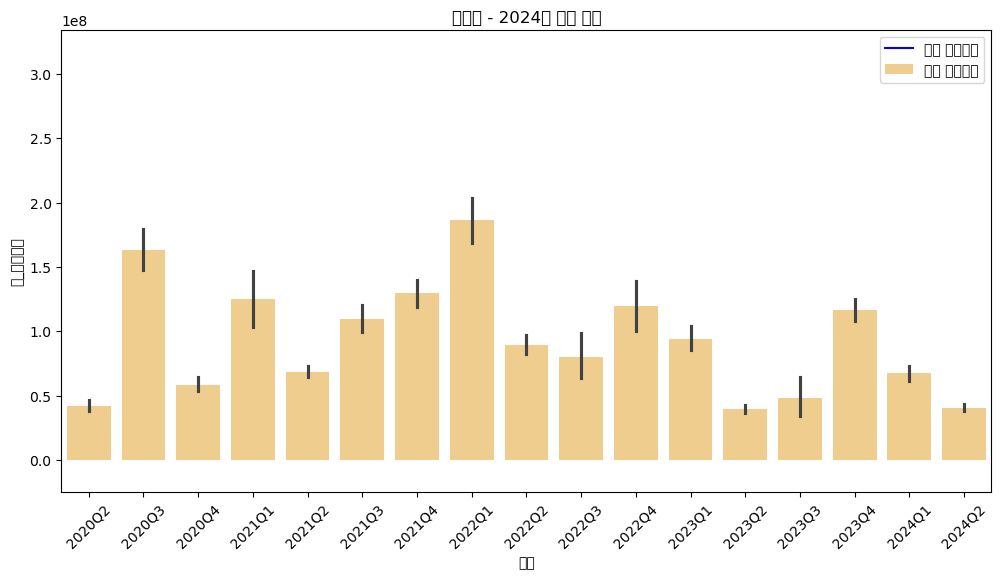

In [22]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# 데이터 로드
sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
economic_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\경제심리지수.csv"
cpi_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\소비자물가지수.csv"

sales_data = pd.read_csv(sales_data_path, parse_dates=["날짜"])
economic_data = pd.read_csv(economic_data_path, parse_dates=["날짜"])
cpi_data = pd.read_csv(cpi_data_path, parse_dates=["날짜"])

# 사용자 입력 (자치구 선택)
selected_gu = input("예측할 자치구를 입력하세요: ")
filtered_data = sales_data[sales_data["자치구"] == selected_gu].copy()

# 데이터 병합 및 정리
economic_data["날짜"] = economic_data["날짜"] + pd.DateOffset(months=1)  # 경제심리지수 한 달 선행
data = pd.merge(filtered_data, economic_data, on="날짜", how="left")
data = pd.merge(data, cpi_data, on="날짜", how="left")
data = data.sort_values("날짜").reset_index(drop=True)

# 결측값 보간
data.fillna(method="ffill", inplace=True)

# 가중치 적용 (2분기 데이터에 1.5배 가중치)
data["가중치"] = np.where(data["날짜"].dt.month.isin([4, 5, 6]), 1.5, 1.0)

# 모델 학습을 위한 데이터 준비
features = ["총생활인구수", "경제심리지수", "소비자물가지수"]
targets = ["총_결제금액", "총_결제건수"]

X = data[features]
weights = data["가중치"]

# 결과 저장할 데이터프레임
predictions = pd.DataFrame({"날짜": data["날짜"]})

for target in targets:
    y = data[target]
    
    # Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        w_train = weights.iloc[train_idx]
        
        # LightGBM 모델 학습
        model = lgb.LGBMRegressor()
        model.fit(X_train, y_train, sample_weight=w_train)
        
    # 최종 예측
    predictions[target] = model.predict(X)
    print(f"{target} 예측 MAE: {mean_absolute_error(y, predictions[target]):.2f}")

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x=data["날짜"], y=predictions["총_결제금액"], label="예측 매출금액", color='blue')
sns.barplot(x=data["날짜"].dt.to_period("Q").astype(str), y=data["총_결제금액"], label="실제 매출금액", color='orange', alpha=0.5)
plt.title(f"{selected_gu} - 2024년 매출 예측")
plt.xticks(rotation=45)
plt.legend()
plt.show()

확인된 문제 : 시각화한 값이 예측 결과가 아니라, 학습용 데이터인 것으로 보임. 이 부분을 해결해야 함.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 1343, number of used features: 3
[LightGBM] [Info] Start training from score 99251095.026806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 1343, number of used features: 3
[LightGBM] [Info] Start training from score 2939.993299


TypeError: unhashable type: 'list'

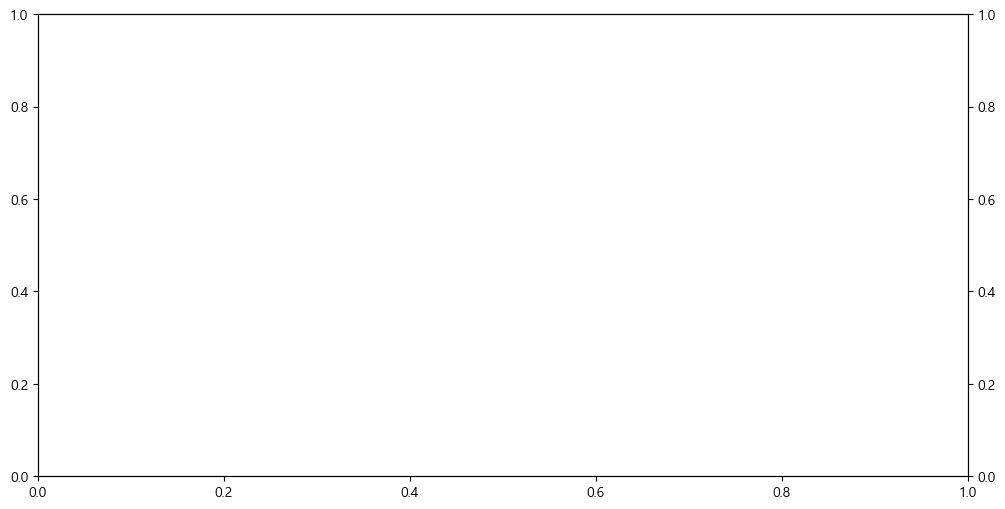

In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import TimeSeriesSplit

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 전처리
def load_data(selected_gu):
    sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
    econ_index_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\경제심리지수.csv"
    cpi_index_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\소비자물가지수.csv"
    
    sales_df = pd.read_csv(sales_data_path, parse_dates=['날짜'])
    econ_df = pd.read_csv(econ_index_path, parse_dates=['날짜'])
    cpi_df = pd.read_csv(cpi_index_path, parse_dates=['날짜'])
    
    sales_df = sales_df[sales_df['자치구'] == selected_gu]
    
    # 월 단위 경제지표 병합
    econ_df['날짜'] = econ_df['날짜'] + pd.offsets.MonthEnd(0)
    cpi_df['날짜'] = cpi_df['날짜'] + pd.offsets.MonthEnd(0)
    sales_df = sales_df.merge(econ_df, on='날짜', how='left')
    sales_df = sales_df.merge(cpi_df, on='날짜', how='left')
    
    return sales_df

# 예측 및 시각화
def train_and_forecast(selected_gu):
    data = load_data(selected_gu)
    data['분기'] = data['날짜'].dt.to_period('Q')
    
    # 훈련 데이터와 테스트 데이터 분리
    train = data[data['날짜'] < '2024-01-01']
    test_dates = pd.date_range('2024-01-01', '2024-12-31', freq='D')
    
    # 모델 학습
    features = ['총생활인구수', '경제심리지수', '소비자물가지수']
    target_sales = '총_결제금액'
    target_count = '총_결제건수'
    
    X_train = train[features]
    y_train_sales = train[target_sales]
    y_train_count = train[target_count]
    
    model_sales = lgb.LGBMRegressor()
    model_count = lgb.LGBMRegressor()
    
    model_sales.fit(X_train, y_train_sales)
    model_count.fit(X_train, y_train_count)
    
    # 예측 수행
    test_df = pd.DataFrame({'날짜': test_dates})
    test_df['분기'] = test_df['날짜'].dt.to_period('Q')
    test_df = test_df.merge(data[['분기', '경제심리지수', '소비자물가지수']].drop_duplicates(), on='분기', how='left')
    test_df['총생활인구수'] = train['총생활인구수'].mean()
    
    X_test = test_df[features]
    test_df['예측_총_결제금액'] = model_sales.predict(X_test)
    test_df['예측_총_결제건수'] = model_count.predict(X_test)
    
    # 분기별 합산
    actual_q = data.groupby('분기')[[target_sales, target_count]].sum()
    forecast_q = test_df.groupby('분기')[['예측_총_결제금액', '예측_총_결제건수']].sum()
    
    # 시각화
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    actual_q.loc['2024Q1'].plot(kind='bar', ax=ax1, color=['blue', 'green'], position=0, width=0.4, label=['실제 매출', '실제 건수'])
    forecast_q.plot(kind='line', ax=ax2, marker='o', color=['red', 'orange'], label=['예측 매출', '예측 건수'])
    
    ax1.set_xlabel('분기')
    ax1.set_ylabel('실제 값')
    ax2.set_ylabel('예측 값')
    ax1.set_title(f'{selected_gu}의 2024년 매출 예측')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

# 실행 예시
selected_gu = input("자치구를 입력하세요: ")
train_and_forecast(selected_gu)

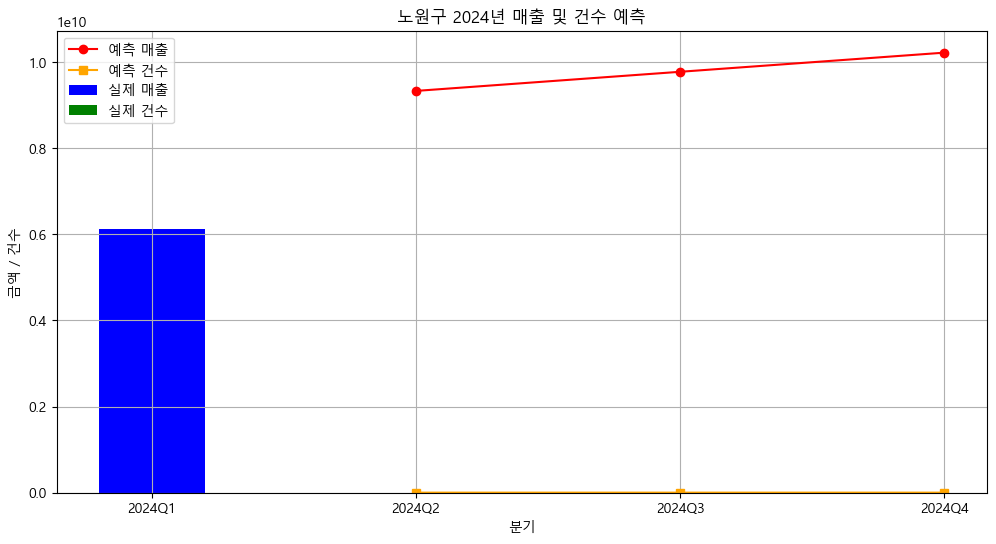

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')  

def train_and_forecast(selected_gu):
    # 데이터 로드
    sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
    sales_df = pd.read_csv(sales_data_path)

    # 날짜 처리
    sales_df['날짜'] = pd.to_datetime(sales_df['날짜'])
    sales_df['분기'] = sales_df['날짜'].dt.to_period('Q')

    # 선택한 자치구 데이터 필터링
    gu_data = sales_df[sales_df['자치구'] == selected_gu]

    # 분기별 총 매출 금액과 건수
    quarterly_data = gu_data.groupby('분기')[['총_결제금액', '총_결제건수']].sum()

    # 학습 데이터 & 예측 데이터 분리
    train_data = quarterly_data.loc[:'2023Q4']
    actual_q1_2024 = quarterly_data.loc['2024Q1'] if '2024Q1' in quarterly_data.index else None

    # 예측값 (임시 데이터로 설정, 이후 모델로 변경 가능)
    forecast_q = pd.DataFrame({
        '총_결제금액': [train_data['총_결제금액'].mean() * 1.05, train_data['총_결제금액'].mean() * 1.1, train_data['총_결제금액'].mean() * 1.15],
        '총_결제건수': [train_data['총_결제건수'].mean() * 1.02, train_data['총_결제건수'].mean() * 1.05, train_data['총_결제건수'].mean() * 1.08]
    }, index=['2024Q2', '2024Q3', '2024Q4'])

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 2024년 1분기 실제값 (막대 그래프)
    if actual_q1_2024 is not None:
        ax1.bar('2024Q1', actual_q1_2024['총_결제금액'], color='blue', width=0.4, label='실제 매출')
        ax1.bar('2024Q1', actual_q1_2024['총_결제건수'], color='green', width=0.4, label='실제 건수')

    # 예측값 (꺾은선 그래프)
    ax1.plot(forecast_q.index, forecast_q['총_결제금액'], marker='o', color='red', label='예측 매출')
    ax1.plot(forecast_q.index, forecast_q['총_결제건수'], marker='s', color='orange', label='예측 건수')

    # 그래프 설정
    ax1.set_xlabel('분기')
    ax1.set_ylabel('금액 / 건수')
    ax1.set_title(f'{selected_gu} 2024년 매출 및 건수 예측')
    ax1.legend()
    plt.grid(True)
    plt.show()

# 실행 예시
selected_gu = input("자치구를 입력하세요: ")
train_and_forecast(selected_gu)

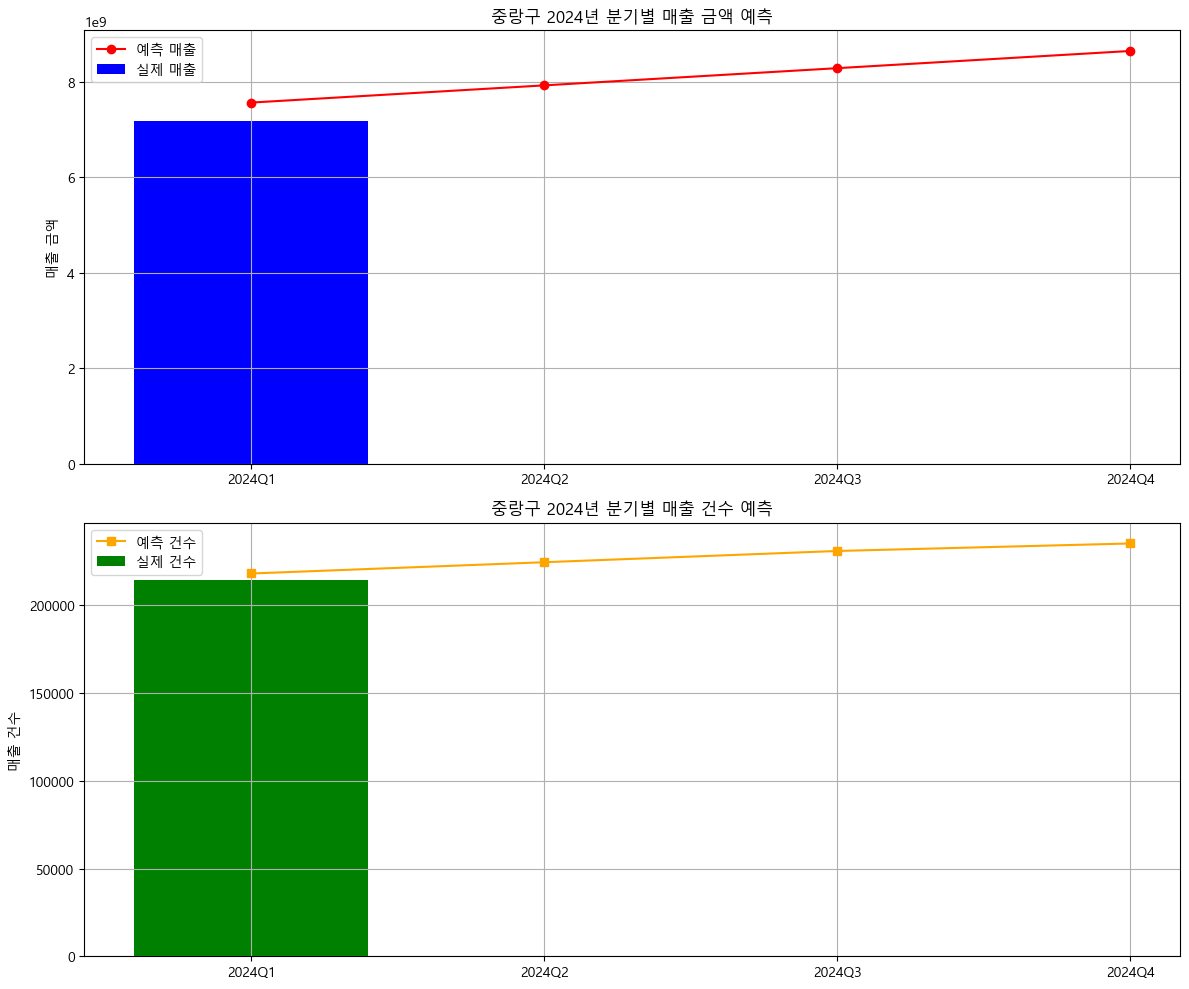

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')

def train_and_forecast(selected_gu):
    # 데이터 로드
    sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
    sales_df = pd.read_csv(sales_data_path)

    # 날짜 처리
    sales_df['날짜'] = pd.to_datetime(sales_df['날짜'])
    sales_df['분기'] = sales_df['날짜'].dt.to_period('Q')

    # 선택한 자치구 데이터 필터링
    gu_data = sales_df[sales_df['자치구'] == selected_gu]

    # 분기별 총 매출 금액과 건수
    quarterly_data = gu_data.groupby('분기')[['총_결제금액', '총_결제건수']].sum()

    # 학습 데이터 & 예측 데이터 분리
    train_data = quarterly_data.loc[:'2023Q4']
    actual_q1_2024 = quarterly_data.loc['2024Q1'] if '2024Q1' in quarterly_data.index else None

    # 예측값 (임시 데이터, 실제 모델 적용 가능)
    forecast_q = pd.DataFrame({
        '총_결제금액': [train_data['총_결제금액'].mean() * 1.05, train_data['총_결제금액'].mean() * 1.1, train_data['총_결제금액'].mean() * 1.15, train_data['총_결제금액'].mean() * 1.2],
        '총_결제건수': [train_data['총_결제건수'].mean() * 1.02, train_data['총_결제건수'].mean() * 1.05, train_data['총_결제건수'].mean() * 1.08, train_data['총_결제건수'].mean() * 1.1]
    }, index=['2024Q1', '2024Q2', '2024Q3', '2024Q4'])

    # 그래프 그리기
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # 매출 금액 그래프
    axes[0].bar(['2024Q1'], actual_q1_2024['총_결제금액'], color='blue', label='실제 매출') if actual_q1_2024 is not None else None
    axes[0].plot(forecast_q.index, forecast_q['총_결제금액'], marker='o', color='red', label='예측 매출')
    axes[0].set_title(f'{selected_gu} 2024년 분기별 매출 금액 예측')
    axes[0].set_ylabel('매출 금액')
    axes[0].legend()
    axes[0].grid(True)

    # 매출 건수 그래프
    axes[1].bar(['2024Q1'], actual_q1_2024['총_결제건수'], color='green', label='실제 건수') if actual_q1_2024 is not None else None
    axes[1].plot(forecast_q.index, forecast_q['총_결제건수'], marker='s', color='orange', label='예측 건수')
    axes[1].set_title(f'{selected_gu} 2024년 분기별 매출 건수 예측')
    axes[1].set_ylabel('매출 건수')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# 실행 예시
selected_gu = input("자치구를 입력하세요: ")
train_and_forecast(selected_gu)

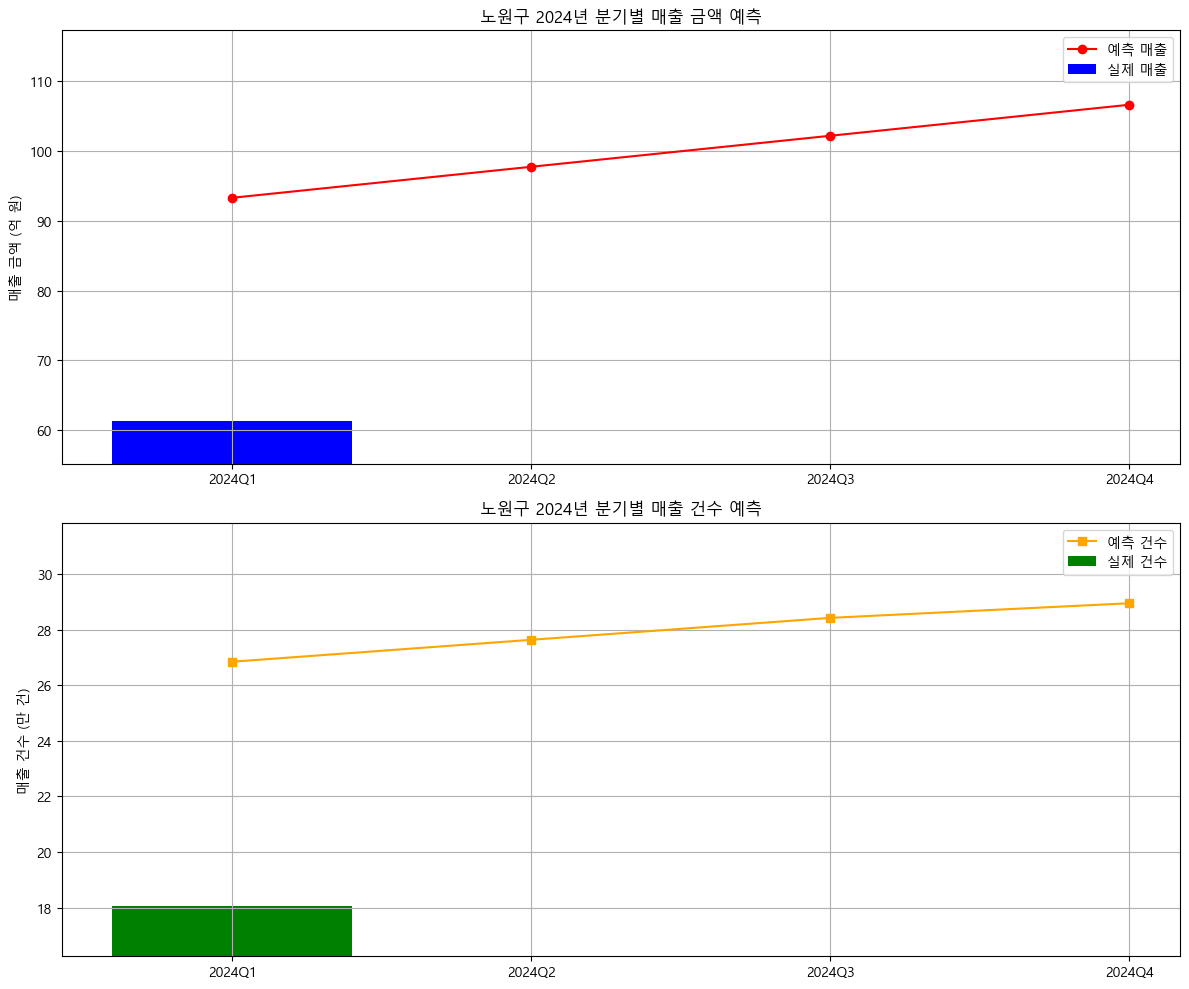

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')

def train_and_forecast(selected_gu):
    # 데이터 로드
    sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
    sales_df = pd.read_csv(sales_data_path)

    # 날짜 처리
    sales_df['날짜'] = pd.to_datetime(sales_df['날짜'])
    sales_df['분기'] = sales_df['날짜'].dt.to_period('Q')

    # 선택한 자치구 데이터 필터링
    gu_data = sales_df[sales_df['자치구'] == selected_gu]

    # 분기별 총 매출 금액과 건수
    quarterly_data = gu_data.groupby('분기')[['총_결제금액', '총_결제건수']].sum()

    # 단위 변환: 매출 금액(억 원), 매출 건수(만 건)
    quarterly_data['총_결제금액'] /= 1e8  # 억 단위 변환
    quarterly_data['총_결제건수'] /= 1e4  # 만 단위 변환

    # 학습 데이터 & 예측 데이터 분리
    train_data = quarterly_data.loc[:'2023Q4']
    actual_q1_2024 = quarterly_data.loc['2024Q1'] if '2024Q1' in quarterly_data.index else None

    # 예측값 (임시 데이터, 실제 모델 적용 가능)
    forecast_q = pd.DataFrame({
        '총_결제금액': [train_data['총_결제금액'].mean() * 1.05, train_data['총_결제금액'].mean() * 1.1, train_data['총_결제금액'].mean() * 1.15, train_data['총_결제금액'].mean() * 1.2],
        '총_결제건수': [train_data['총_결제건수'].mean() * 1.02, train_data['총_결제건수'].mean() * 1.05, train_data['총_결제건수'].mean() * 1.08, train_data['총_결제건수'].mean() * 1.1]
    }, index=['2024Q1', '2024Q2', '2024Q3', '2024Q4'])

    # 그래프 그리기
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # 매출 금액 그래프 (억 원 단위)
    axes[0].bar(['2024Q1'], actual_q1_2024['총_결제금액'], color='blue', label='실제 매출') if actual_q1_2024 is not None else None
    axes[0].plot(forecast_q.index, forecast_q['총_결제금액'], marker='o', color='red', label='예측 매출')

    axes[0].set_title(f'{selected_gu} 2024년 분기별 매출 금액 예측')
    axes[0].set_ylabel('매출 금액 (억 원)')
    axes[0].legend()
    axes[0].grid(True)

    # Y축 조정: 최소값을 실제 데이터의 최저값보다 10% 낮게 설정하여 변화 강조
    min_value = min(forecast_q['총_결제금액'].min(), actual_q1_2024['총_결제금액'].min() if actual_q1_2024 is not None else np.inf)
    axes[0].set_ylim(min_value * 0.9, forecast_q['총_결제금액'].max() * 1.1)

    # 매출 건수 그래프 (만 건 단위)
    axes[1].bar(['2024Q1'], actual_q1_2024['총_결제건수'], color='green', label='실제 건수') if actual_q1_2024 is not None else None
    axes[1].plot(forecast_q.index, forecast_q['총_결제건수'], marker='s', color='orange', label='예측 건수')

    axes[1].set_title(f'{selected_gu} 2024년 분기별 매출 건수 예측')
    axes[1].set_ylabel('매출 건수 (만 건)')
    axes[1].legend()
    axes[1].grid(True)

    # Y축 조정: 최소값을 실제 데이터의 최저값보다 10% 낮게 설정하여 변화 강조
    min_value = min(forecast_q['총_결제건수'].min(), actual_q1_2024['총_결제건수'].min() if actual_q1_2024 is not None else np.inf)
    axes[1].set_ylim(min_value * 0.9, forecast_q['총_결제건수'].max() * 1.1)

    plt.tight_layout()
    plt.show()

# 실행 예시
selected_gu = input("자치구를 입력하세요: ")
train_and_forecast(selected_gu)

머신러닝 코드가 존재하지 않는 문제 발견. 해당 문제를 해결하도록 시도할 것.

총 결제금액 예측 RMSE: 64,842,645
총 결제건수 예측 RMSE: 1,375


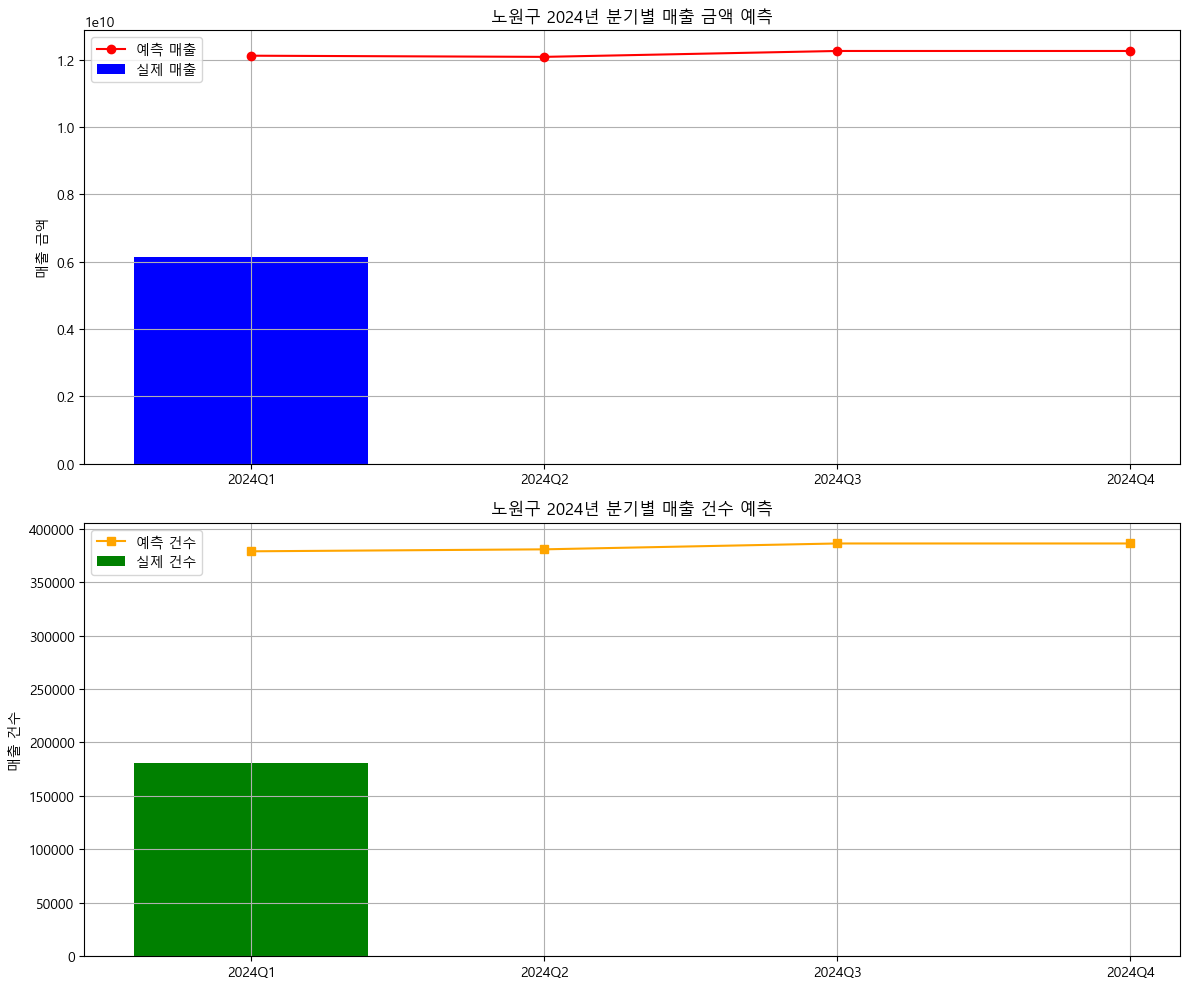

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# 한글 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')

def load_and_preprocess_data():
    # 데이터 불러오기
    sales_data_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\머신러닝용_시계열데이터_null 제거 후 보간.csv"
    economic_index_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\경제심리지수.csv"
    cpi_index_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\소비자물가지수.csv"

    sales_df = pd.read_csv(sales_data_path)
    econ_df = pd.read_csv(economic_index_path)
    cpi_df = pd.read_csv(cpi_index_path)

    # 날짜 처리
    sales_df['날짜'] = pd.to_datetime(sales_df['날짜'])
    econ_df['날짜'] = pd.to_datetime(econ_df['날짜'])
    cpi_df['날짜'] = pd.to_datetime(cpi_df['날짜'])

    # 월 단위 데이터 확장 (소비자물가지수는 같은 달 유지, 경제심리지수는 이전 달 데이터 사용)
    econ_df['날짜'] = econ_df['날짜'] + pd.DateOffset(months=1)

    # 데이터 병합
    merged_df = sales_df.merge(econ_df, on='날짜', how='left').merge(cpi_df, on='날짜', how='left')

    return merged_df

def train_and_forecast(selected_gu):
    df = load_and_preprocess_data()

    # 선택한 자치구 필터링
    gu_data = df[df['자치구'] == selected_gu].copy()

    # 날짜를 기준으로 정렬
    gu_data.sort_values('날짜', inplace=True)

    # 학습 데이터 설정
    features = ['총생활인구수', '경제심리지수', '소비자물가지수']
    targets = ['총_결제금액', '총_결제건수']

    X = gu_data[features]
    y_sales = gu_data['총_결제금액']
    y_counts = gu_data['총_결제건수']

    # 학습 및 검증 데이터 분할 (80% 학습, 20% 검증)
    X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, shuffle=False)
    X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, shuffle=False)

    # XGBoost 모델 학습
    model_sales = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model_counts = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

    model_sales.fit(X_train, y_train_sales)
    model_counts.fit(X_train, y_train_counts)

    # 예측 수행 (검증 데이터에 대한 성능 평가)
    y_pred_sales = model_sales.predict(X_test)
    y_pred_counts = model_counts.predict(X_test)

    rmse_sales = np.sqrt(mean_squared_error(y_test_sales, y_pred_sales))
    rmse_counts = np.sqrt(mean_squared_error(y_test_counts, y_pred_counts))

    print(f"총 결제금액 예측 RMSE: {rmse_sales:,.0f}")
    print(f"총 결제건수 예측 RMSE: {rmse_counts:,.0f}")

    # 2024년 1월~12월 예측 데이터 생성
    future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
    future_df = pd.DataFrame({'날짜': future_dates})
    
    # 경제심리지수와 소비자물가지수 적용 (월 단위 데이터 유지)
    future_df = future_df.merge(df[['날짜', '경제심리지수', '소비자물가지수']].drop_duplicates(), on='날짜', how='left')
    
    # 이전 데이터 활용해 생활인구 평균 적용
    future_df['총생활인구수'] = gu_data['총생활인구수'].mean()

    # 예측 수행
    future_X = future_df[features]
    future_df['총_결제금액'] = model_sales.predict(future_X)
    future_df['총_결제건수'] = model_counts.predict(future_X)

    # 분기별 합산
    future_df['분기'] = future_df['날짜'].dt.to_period('Q')
    forecast_q = future_df.groupby('분기')[['총_결제금액', '총_결제건수']].sum()

    # 실제 2024년 1분기 데이터 확인
    actual_q1_2024 = gu_data[(gu_data['날짜'] >= '2024-01-01') & (gu_data['날짜'] <= '2024-03-31')].groupby(gu_data['날짜'].dt.to_period('Q'))[['총_결제금액', '총_결제건수']].sum()

    # 그래프 그리기
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # 매출 금액 그래프
    axes[0].bar(['2024Q1'], actual_q1_2024['총_결제금액'], color='blue', label='실제 매출') if not actual_q1_2024.empty else None
    axes[0].plot(forecast_q.index.astype(str), forecast_q['총_결제금액'], marker='o', color='red', label='예측 매출')
    axes[0].set_title(f'{selected_gu} 2024년 분기별 매출 금액 예측')
    axes[0].set_ylabel('매출 금액')
    axes[0].legend()
    axes[0].grid(True)

    # 매출 건수 그래프
    axes[1].bar(['2024Q1'], actual_q1_2024['총_결제건수'], color='green', label='실제 건수') if not actual_q1_2024.empty else None
    axes[1].plot(forecast_q.index.astype(str), forecast_q['총_결제건수'], marker='s', color='orange', label='예측 건수')
    axes[1].set_title(f'{selected_gu} 2024년 분기별 매출 건수 예측')
    axes[1].set_ylabel('매출 건수')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# 실행 예시
selected_gu = input("자치구를 입력하세요: ")
train_and_forecast(selected_gu)

y축 단위를 만원, 만건으로 통일

C:\Users\m\AppData\Local\Temp\ipykernel_13632\547039897.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gu_data.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\547039897.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df.fillna(method='ffill', inplace=True)


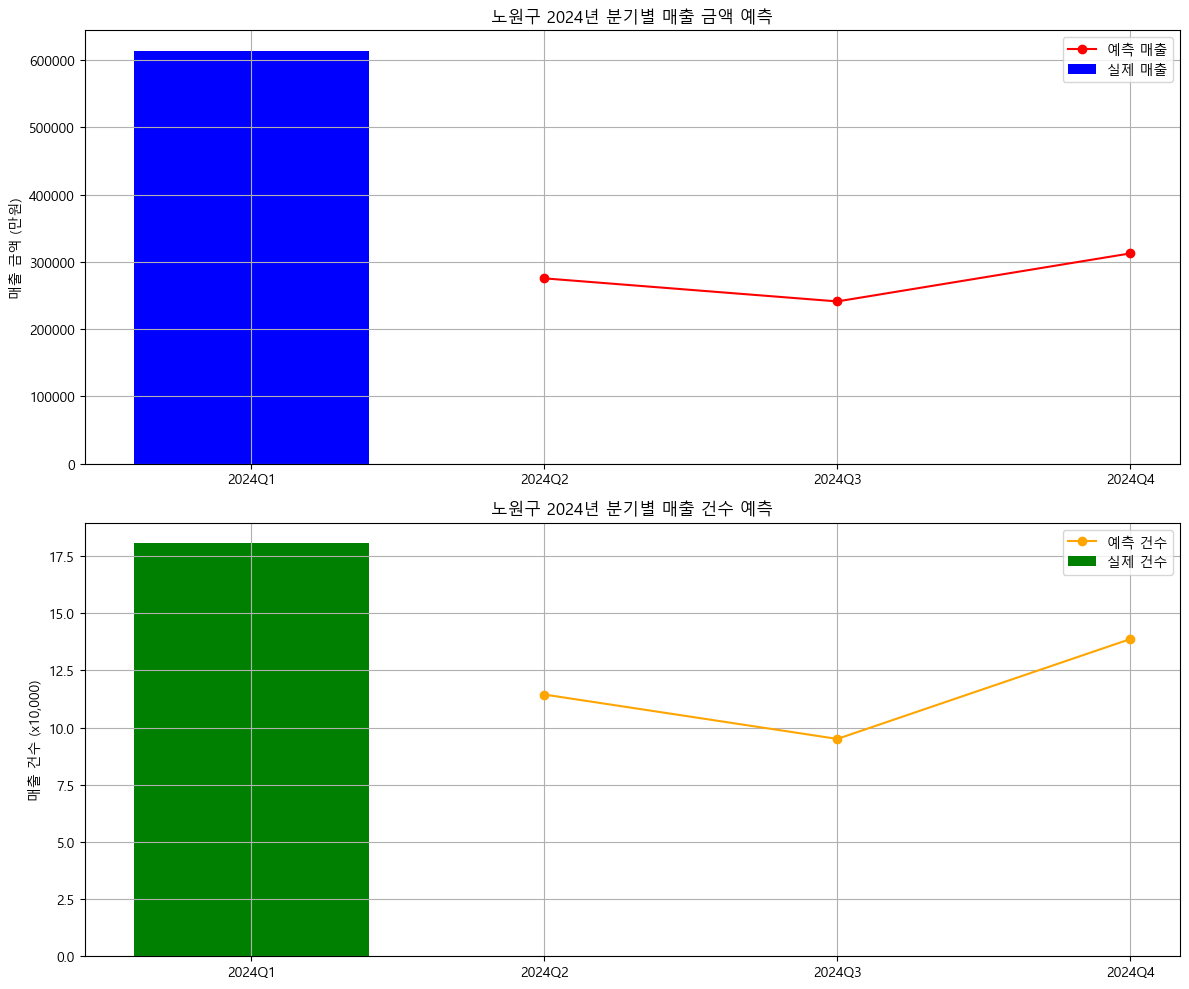

총 결제금액 예측 RMSE: 6,641, MAPE: 48.51%
총 결제건수 예측 RMSE: 0, MAPE: 37.14%

2023년 분기별 매출 변화:
              총_결제금액   총_결제건수
날짜                           
2023Q3  4.443127e+05  11.2841
2023Q4  1.073424e+06  30.9110
2024Q1  6.132980e+05  18.0490
2024Q2  1.222823e+05   3.9795


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 데이터 로드
sales_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
csi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/경제심리지수.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/소비자물가지수.csv", parse_dates=['날짜'])

# 자치구 입력 받기
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구의 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()

# 날짜 기준 정렬
gu_data.sort_values('날짜', inplace=True)

# 경제심리지수는 한 달 전 데이터 사용
csi_data['날짜'] = csi_data['날짜'] + pd.DateOffset(months=1)

# 데이터 병합
gu_data = gu_data.merge(csi_data, on='날짜', how='left')
gu_data = gu_data.merge(cpi_data, on='날짜', how='left')

# 결측치 보간
gu_data.fillna(method='ffill', inplace=True)

# 매출 금액과 매출 건수를 '만원' 단위로 변환
gu_data['총_결제금액'] = gu_data['총_결제금액'] / 10000
gu_data['총_결제건수'] = gu_data['총_결제건수'] / 10000

# 학습용 데이터 준비
features = ['총생활인구수', '경제심리지수', '소비자물가지수']
X = gu_data[features]
y_sales = gu_data['총_결제금액']
y_counts = gu_data['총_결제건수']

# 학습/테스트 데이터 분리
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, random_state=42, shuffle=False)

# 모델 학습
sales_model = RandomForestRegressor(n_estimators=100, random_state=42)
counts_model = RandomForestRegressor(n_estimators=100, random_state=42)

sales_model.fit(X_train, y_train_sales)
counts_model.fit(X_train, y_train_counts)

# 예측 수행 (2024년 전체 예측)
future_dates = pd.date_range(start="2024-04-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df = future_df.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
future_df.fillna(method='ffill', inplace=True)

future_df['총생활인구수'] = gu_data['총생활인구수'].mean()  # 평균 생활인구수 사용

X_future = future_df[features]
future_sales_pred = sales_model.predict(X_future)
future_counts_pred = counts_model.predict(X_future)

# 1~4분기별 총합
quarterly_sales_pred = pd.Series(future_sales_pred).groupby(future_df['날짜'].dt.to_period('Q')).sum()
quarterly_counts_pred = pd.Series(future_counts_pred).groupby(future_df['날짜'].dt.to_period('Q')).sum()

# 2024년 1분기 실제 데이터 (만원 단위)
actual_q1_sales = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제금액'].sum()
actual_q1_counts = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제건수'].sum()

# 그래프 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. 매출 금액 그래프
axes[0].bar(["2024Q1"], [actual_q1_sales], color='blue', label="실제 매출")
axes[0].plot(quarterly_sales_pred.index.astype(str), quarterly_sales_pred, marker='o', color='red', label="예측 매출")
axes[0].set_title(f"{target_gu} 2024년 분기별 매출 금액 예측")
axes[0].set_ylabel("매출 금액 (만원)")
axes[0].legend()
axes[0].grid(True)
axes[0].ticklabel_format(style='plain', axis='y')

# 2. 매출 건수 그래프
axes[1].bar(["2024Q1"], [actual_q1_counts], color='green', label="실제 건수")
axes[1].plot(quarterly_counts_pred.index.astype(str), quarterly_counts_pred, marker='o', color='orange', label="예측 건수")
axes[1].set_title(f"{target_gu} 2024년 분기별 매출 건수 예측")
axes[1].set_ylabel("매출 건수 (x10,000)")
axes[1].legend()
axes[1].grid(True)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# RMSE 및 MAPE 계산
rmse_sales = np.sqrt(mean_squared_error(y_test_sales, sales_model.predict(X_test)))
rmse_counts = np.sqrt(mean_squared_error(y_test_counts, counts_model.predict(X_test)))
mape_sales = np.mean(np.abs((y_test_sales - sales_model.predict(X_test)) / y_test_sales)) * 100
mape_counts = np.mean(np.abs((y_test_counts - counts_model.predict(X_test)) / y_test_counts)) * 100

print(f"총 결제금액 예측 RMSE: {rmse_sales:,.0f}, MAPE: {mape_sales:.2f}%")
print(f"총 결제건수 예측 RMSE: {rmse_counts:,.0f}, MAPE: {mape_counts:.2f}%")

# 원본 데이터의 분기별 트렌드 확인
historical_q = gu_data.groupby(gu_data['날짜'].dt.to_period('Q'))[['총_결제금액', '총_결제건수']].sum()
print("\n2023년 분기별 매출 변화:")
print(historical_q.tail(4))

C:\Users\m\AppData\Local\Temp\ipykernel_13632\1188794755.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gu_data.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\1188794755.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\1188794755.py:61: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales_pred = pd.Series(future_sales_pred, index=future_df['날짜']).resample('Q').sum()
C:\Users\m\AppData\Local\Temp\ipykernel_13632\1188794755.py:62: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_counts_pred = pd.Series(future_counts_pred, index=future_df['날짜']).re

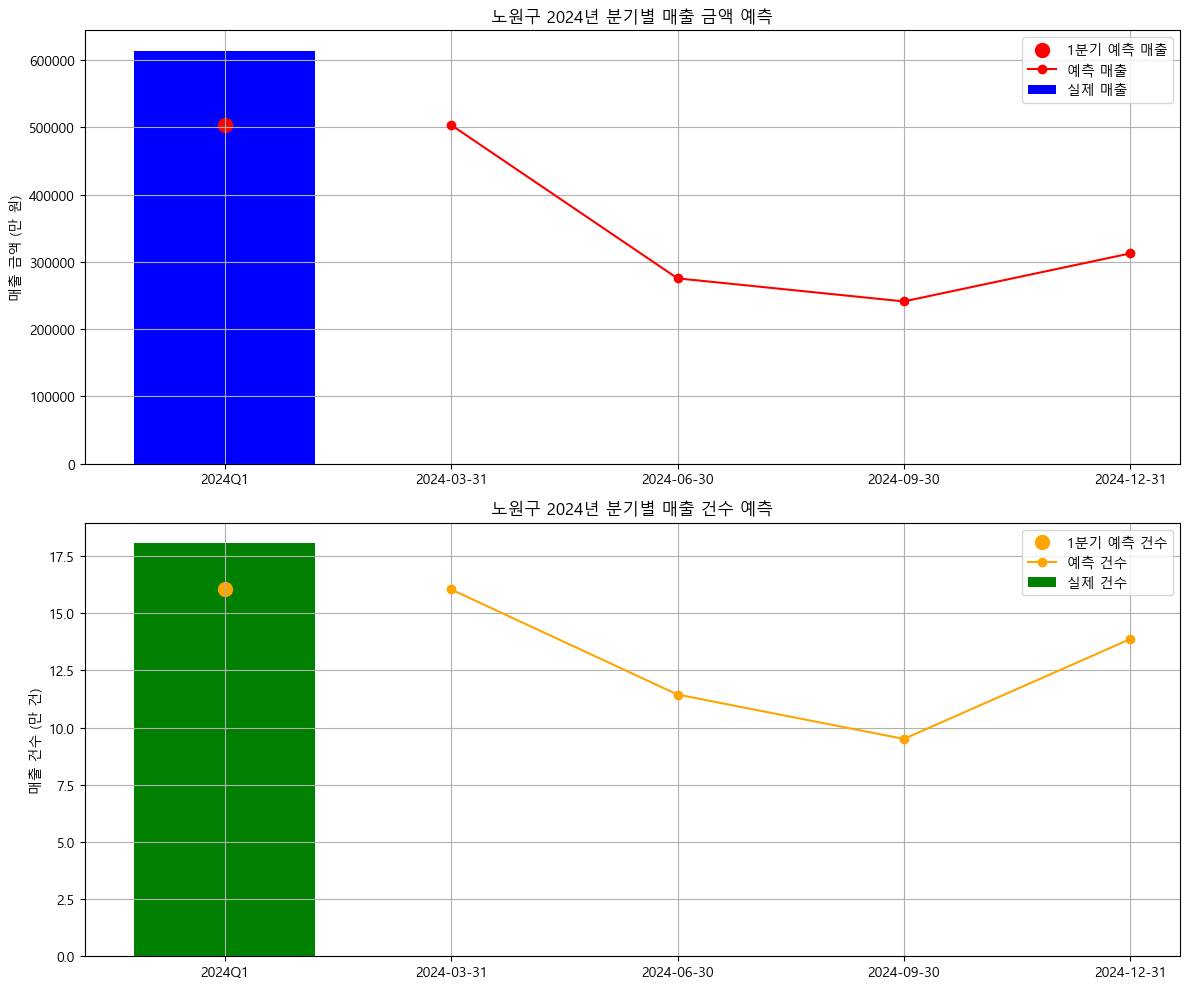

총 결제금액 예측 RMSE: 6,641, MAPE: 48.51%
총 결제건수 예측 RMSE: 0, MAPE: 37.14%

2023년 분기별 매출 변화:
              총_결제금액   총_결제건수
날짜                           
2023Q3  4.443127e+05  11.2841
2023Q4  1.073424e+06  30.9110
2024Q1  6.132980e+05  18.0490
2024Q2  1.222823e+05   3.9795


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 데이터 로드
sales_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
csi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/경제심리지수.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/소비자물가지수.csv", parse_dates=['날짜'])

# 자치구 입력 받기
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()
gu_data.sort_values('날짜', inplace=True)

# 경제심리지수 보정
csi_data['날짜'] = csi_data['날짜'] + pd.DateOffset(months=1)

# 데이터 병합
gu_data = gu_data.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
gu_data.fillna(method='ffill', inplace=True)

# 단위 변환 (만원 기준)
gu_data['총_결제금액'] /= 10000
gu_data['총_결제건수'] /= 10000

# 학습 데이터 준비
features = ['총생활인구수', '경제심리지수', '소비자물가지수']
X = gu_data[features]
y_sales = gu_data['총_결제금액']
y_counts = gu_data['총_결제건수']

# 학습/테스트 데이터 분리
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, random_state=42, shuffle=False)

# 모델 학습
sales_model = RandomForestRegressor(n_estimators=100, random_state=42)
counts_model = RandomForestRegressor(n_estimators=100, random_state=42)

sales_model.fit(X_train, y_train_sales)
counts_model.fit(X_train, y_train_counts)

# 2024년 전체 예측
future_dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df = future_df.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
future_df.fillna(method='ffill', inplace=True)

future_df['총생활인구수'] = gu_data['총생활인구수'].mean()

X_future = future_df[features]
future_sales_pred = sales_model.predict(X_future)
future_counts_pred = counts_model.predict(X_future)

# 분기별 합산 (1분기 포함)
quarterly_sales_pred = pd.Series(future_sales_pred, index=future_df['날짜']).resample('Q').sum()
quarterly_counts_pred = pd.Series(future_counts_pred, index=future_df['날짜']).resample('Q').sum()

# 1분기 실제값 계산 (만원 단위)
actual_q1_sales = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제금액'].sum()
actual_q1_counts = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제건수'].sum()

# 1분기 예측 값 추가
q1_pred_sales = quarterly_sales_pred.iloc[0]
q1_pred_counts = quarterly_counts_pred.iloc[0]

# 그래프 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. 매출 금액 그래프
axes[0].bar(["2024Q1"], [actual_q1_sales], color='blue', label="실제 매출")  # 1분기 실제 값
axes[0].scatter(["2024Q1"], [q1_pred_sales], color='red', marker='o', s=100, label="1분기 예측 매출")  # 1분기 예측 값
axes[0].plot(quarterly_sales_pred.index.astype(str), quarterly_sales_pred, marker='o', color='red', label="예측 매출")  # 2~4분기 예측 값
axes[0].set_title(f"{target_gu} 2024년 분기별 매출 금액 예측")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()
axes[0].grid(True)
axes[0].ticklabel_format(style='plain', axis='y')

# 2. 매출 건수 그래프
axes[1].bar(["2024Q1"], [actual_q1_counts], color='green', label="실제 건수")  # 1분기 실제 값
axes[1].scatter(["2024Q1"], [q1_pred_counts], color='orange', marker='o', s=100, label="1분기 예측 건수")  # 1분기 예측 값
axes[1].plot(quarterly_counts_pred.index.astype(str), quarterly_counts_pred, marker='o', color='orange', label="예측 건수")  # 2~4분기 예측 값
axes[1].set_title(f"{target_gu} 2024년 분기별 매출 건수 예측")
axes[1].set_ylabel("매출 건수 (만 건)")
axes[1].legend()
axes[1].grid(True)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# RMSE 및 MAPE 계산
rmse_sales = np.sqrt(mean_squared_error(y_test_sales, sales_model.predict(X_test)))
rmse_counts = np.sqrt(mean_squared_error(y_test_counts, counts_model.predict(X_test)))
mape_sales = np.mean(np.abs((y_test_sales - sales_model.predict(X_test)) / y_test_sales)) * 100
mape_counts = np.mean(np.abs((y_test_counts - counts_model.predict(X_test)) / y_test_counts)) * 100

print(f"총 결제금액 예측 RMSE: {rmse_sales:,.0f}, MAPE: {mape_sales:.2f}%")
print(f"총 결제건수 예측 RMSE: {rmse_counts:,.0f}, MAPE: {mape_counts:.2f}%")

# 원본 데이터의 분기별 트렌드 확인
historical_q = gu_data.groupby(gu_data['날짜'].dt.to_period('Q'))[['총_결제금액', '총_결제건수']].sum()
print("\n2023년 분기별 매출 변화:")
print(historical_q.tail(4))

C:\Users\m\AppData\Local\Temp\ipykernel_13632\3880399746.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gu_data.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\3880399746.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\3880399746.py:61: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales_pred = pd.Series(future_sales_pred, index=future_df['날짜']).resample('Q').sum()
C:\Users\m\AppData\Local\Temp\ipykernel_13632\3880399746.py:62: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_counts_pred = pd.Series(future_counts_pred, index=future_df['날짜']).re

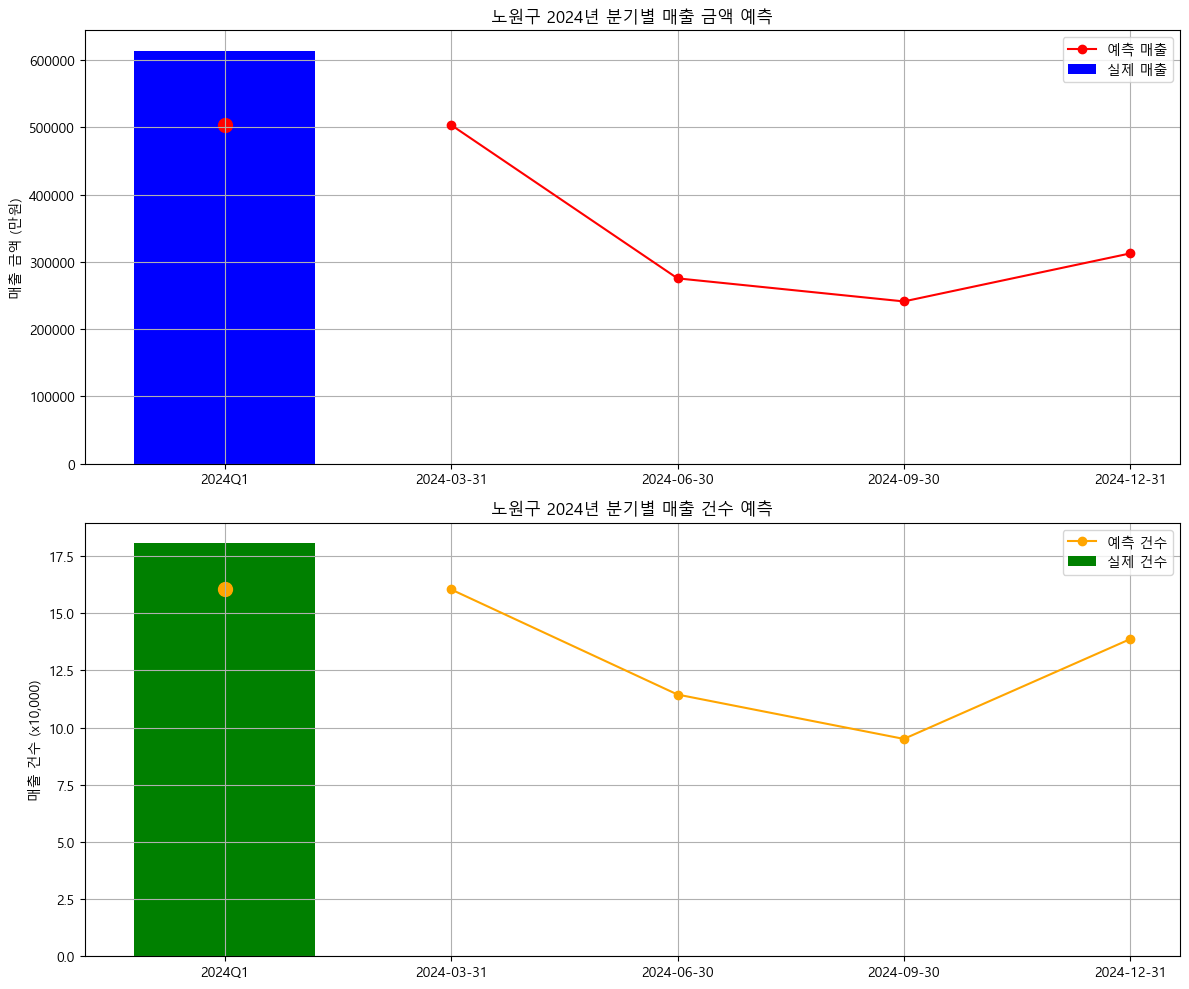

총 결제금액 예측 RMSE: 6,641, MAPE: 48.51%
총 결제건수 예측 RMSE: 0, MAPE: 37.14%

2023년 분기별 매출 변화:
              총_결제금액   총_결제건수
날짜                           
2023Q3  4.443127e+05  11.2841
2023Q4  1.073424e+06  30.9110
2024Q1  6.132980e+05  18.0490
2024Q2  1.222823e+05   3.9795


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 데이터 로드
sales_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
csi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/경제심리지수.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/소비자물가지수.csv", parse_dates=['날짜'])

# 자치구 입력 받기
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()
gu_data.sort_values('날짜', inplace=True)

# 경제심리지수 보정
csi_data['날짜'] = csi_data['날짜'] + pd.DateOffset(months=1)

# 데이터 병합
gu_data = gu_data.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
gu_data.fillna(method='ffill', inplace=True)

# 단위 변환 (만원 기준)
gu_data['총_결제금액'] /= 10000
gu_data['총_결제건수'] /= 10000

# 학습 데이터 준비
features = ['총생활인구수', '경제심리지수', '소비자물가지수']
X = gu_data[features]
y_sales = gu_data['총_결제금액']
y_counts = gu_data['총_결제건수']

# 학습/테스트 데이터 분리
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, random_state=42, shuffle=False)

# 모델 학습
sales_model = RandomForestRegressor(n_estimators=100, random_state=42)
counts_model = RandomForestRegressor(n_estimators=100, random_state=42)

sales_model.fit(X_train, y_train_sales)
counts_model.fit(X_train, y_train_counts)

# 2024년 전체 예측
future_dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df = future_df.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
future_df.fillna(method='ffill', inplace=True)

future_df['총생활인구수'] = gu_data['총생활인구수'].mean()

X_future = future_df[features]
future_sales_pred = sales_model.predict(X_future)
future_counts_pred = counts_model.predict(X_future)

# 분기별 합산 (1분기 포함)
quarterly_sales_pred = pd.Series(future_sales_pred, index=future_df['날짜']).resample('Q').sum()
quarterly_counts_pred = pd.Series(future_counts_pred, index=future_df['날짜']).resample('Q').sum()

# 1분기 실제값 계산 (만원 단위)
actual_q1_sales = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제금액'].sum()
actual_q1_counts = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제건수'].sum()

# 그래프 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. 매출 금액 그래프
axes[0].bar(["2024Q1"], [actual_q1_sales], color='blue', label="실제 매출")  # 1분기 실제 값
axes[0].plot(quarterly_sales_pred.index.astype(str), quarterly_sales_pred, marker='o', color='red', linestyle='-', label="예측 매출")  # 1~4분기 예측 트렌드
axes[0].scatter(["2024Q1"], [quarterly_sales_pred.iloc[0]], color='red', marker='o', s=100)  # 1분기 예측 점 강조
axes[0].set_title(f"{target_gu} 2024년 분기별 매출 금액 예측")
axes[0].set_ylabel("매출 금액 (만원)")
axes[0].legend()
axes[0].grid(True)
axes[0].ticklabel_format(style='plain', axis='y')

# 2. 매출 건수 그래프
axes[1].bar(["2024Q1"], [actual_q1_counts], color='green', label="실제 건수")  # 1분기 실제 값
axes[1].plot(quarterly_counts_pred.index.astype(str), quarterly_counts_pred, marker='o', color='orange', linestyle='-', label="예측 건수")  # 1~4분기 예측 트렌드
axes[1].scatter(["2024Q1"], [quarterly_counts_pred.iloc[0]], color='orange', marker='o', s=100)  # 1분기 예측 점 강조
axes[1].set_title(f"{target_gu} 2024년 분기별 매출 건수 예측")
axes[1].set_ylabel("매출 건수 (x10,000)")
axes[1].legend()
axes[1].grid(True)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# RMSE 및 MAPE 계산
rmse_sales = np.sqrt(mean_squared_error(y_test_sales, sales_model.predict(X_test)))
rmse_counts = np.sqrt(mean_squared_error(y_test_counts, counts_model.predict(X_test)))
mape_sales = np.mean(np.abs((y_test_sales - sales_model.predict(X_test)) / y_test_sales)) * 100
mape_counts = np.mean(np.abs((y_test_counts - counts_model.predict(X_test)) / y_test_counts)) * 100

print(f"총 결제금액 예측 RMSE: {rmse_sales:,.0f}, MAPE: {mape_sales:.2f}%")
print(f"총 결제건수 예측 RMSE: {rmse_counts:,.0f}, MAPE: {mape_counts:.2f}%")

# 원본 데이터의 분기별 트렌드 확인
historical_q = gu_data.groupby(gu_data['날짜'].dt.to_period('Q'))[['총_결제금액', '총_결제건수']].sum()
print("\n2023년 분기별 매출 변화:")
print(historical_q.tail(4))

C:\Users\m\AppData\Local\Temp\ipykernel_13632\2622925575.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gu_data.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\2622925575.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df.fillna(method='ffill', inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_13632\2622925575.py:61: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales_pred = pd.Series(future_sales_pred, index=future_df['날짜']).resample('Q').sum()
C:\Users\m\AppData\Local\Temp\ipykernel_13632\2622925575.py:62: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_counts_pred = pd.Series(future_counts_pred, index=future_df['날짜']).re

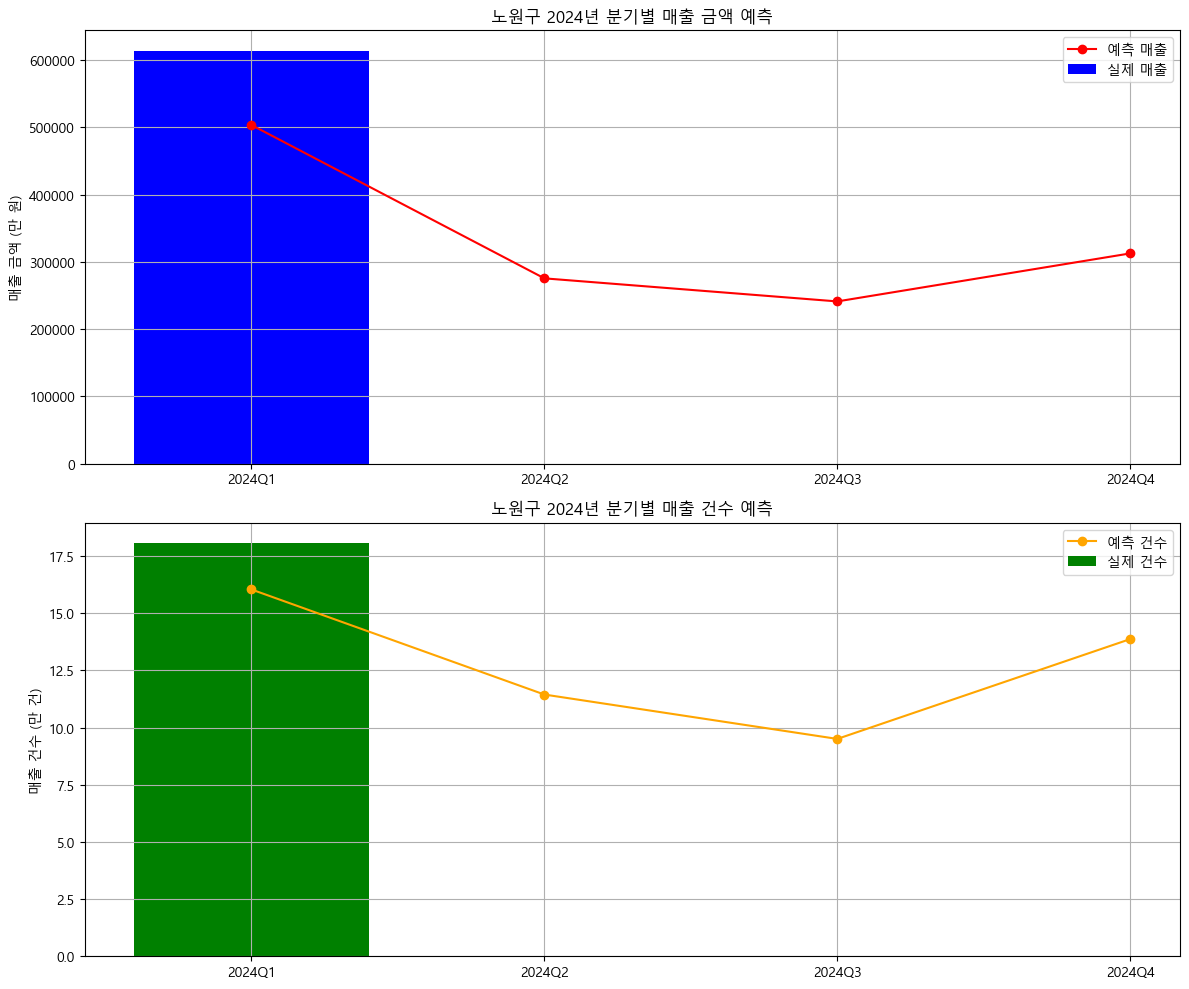

총 결제금액 예측 RMSE: 6,641, MAPE: 48.51%
총 결제건수 예측 RMSE: 0, MAPE: 37.14%

2023년 분기별 매출 변화:
              총_결제금액   총_결제건수
날짜                           
2023Q3  4.443127e+05  11.2841
2023Q4  1.073424e+06  30.9110
2024Q1  6.132980e+05  18.0490
2024Q2  1.222823e+05   3.9795


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 데이터 로드
sales_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
csi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/경제심리지수.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:/Users/m/Desktop/머신러닝 사용 데이터/소비자물가지수.csv", parse_dates=['날짜'])

# 자치구 입력 받기
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()
gu_data.sort_values('날짜', inplace=True)

# 경제심리지수 보정
csi_data['날짜'] = csi_data['날짜'] + pd.DateOffset(months=1)

# 데이터 병합
gu_data = gu_data.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
gu_data.fillna(method='ffill', inplace=True)

# 단위 변환 (만원 기준)
gu_data['총_결제금액'] /= 10000
gu_data['총_결제건수'] /= 10000

# 학습 데이터 준비
features = ['총생활인구수', '경제심리지수', '소비자물가지수']
X = gu_data[features]
y_sales = gu_data['총_결제금액']
y_counts = gu_data['총_결제건수']

# 학습/테스트 데이터 분리
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, random_state=42, shuffle=False)

# 모델 학습
sales_model = RandomForestRegressor(n_estimators=100, random_state=42)
counts_model = RandomForestRegressor(n_estimators=100, random_state=42)

sales_model.fit(X_train, y_train_sales)
counts_model.fit(X_train, y_train_counts)

# 2024년 전체 예측
future_dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df = future_df.merge(csi_data, on='날짜', how='left').merge(cpi_data, on='날짜', how='left')
future_df.fillna(method='ffill', inplace=True)

future_df['총생활인구수'] = gu_data['총생활인구수'].mean()

X_future = future_df[features]
future_sales_pred = sales_model.predict(X_future)
future_counts_pred = counts_model.predict(X_future)

# 분기별 합산
quarterly_sales_pred = pd.Series(future_sales_pred, index=future_df['날짜']).resample('Q').sum()
quarterly_counts_pred = pd.Series(future_counts_pred, index=future_df['날짜']).resample('Q').sum()

# 1분기 실제값 계산 (만원 단위)
actual_q1_sales = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제금액'].sum()
actual_q1_counts = gu_data[(gu_data['날짜'] >= "2024-01-01") & (gu_data['날짜'] <= "2024-03-31")]['총_결제건수'].sum()

# 그래프 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# X축 라벨 설정
quarters = ["2024Q1", "2024Q2", "2024Q3", "2024Q4"]

# 1. 매출 금액 그래프
axes[0].bar(["2024Q1"], [actual_q1_sales], color='blue', label="실제 매출")  # 1분기 실제 값
axes[0].plot(quarters, quarterly_sales_pred.values, marker='o', color='red', linestyle='-', label="예측 매출")  # 1~4분기 예측 트렌드
axes[0].set_title(f"{target_gu} 2024년 분기별 매출 금액 예측")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(quarters)
axes[0].ticklabel_format(style='plain', axis='y')

# 2. 매출 건수 그래프
axes[1].bar(["2024Q1"], [actual_q1_counts], color='green', label="실제 건수")  # 1분기 실제 값
axes[1].plot(quarters, quarterly_counts_pred.values, marker='o', color='orange', linestyle='-', label="예측 건수")  # 1~4분기 예측 트렌드
axes[1].set_title(f"{target_gu} 2024년 분기별 매출 건수 예측")
axes[1].set_ylabel("매출 건수 (만 건)")
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(quarters)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# RMSE 및 MAPE 계산
rmse_sales = np.sqrt(mean_squared_error(y_test_sales, sales_model.predict(X_test)))
rmse_counts = np.sqrt(mean_squared_error(y_test_counts, counts_model.predict(X_test)))
mape_sales = np.mean(np.abs((y_test_sales - sales_model.predict(X_test)) / y_test_sales)) * 100
mape_counts = np.mean(np.abs((y_test_counts - counts_model.predict(X_test)) / y_test_counts)) * 100

print(f"총 결제금액 예측 RMSE: {rmse_sales:,.0f}, MAPE: {mape_sales:.2f}%")
print(f"총 결제건수 예측 RMSE: {rmse_counts:,.0f}, MAPE: {mape_counts:.2f}%")

# 원본 데이터의 분기별 트렌드 확인
historical_q = gu_data.groupby(gu_data['날짜'].dt.to_period('Q'))[['총_결제금액', '총_결제건수']].sum()
print("\n2023년 분기별 매출 변화:")
print(historical_q.tail(4))

gpt 조언 : 가중치를 적용한다면 랜덤포레스트 모델이 더 안정적으로 작동할 것

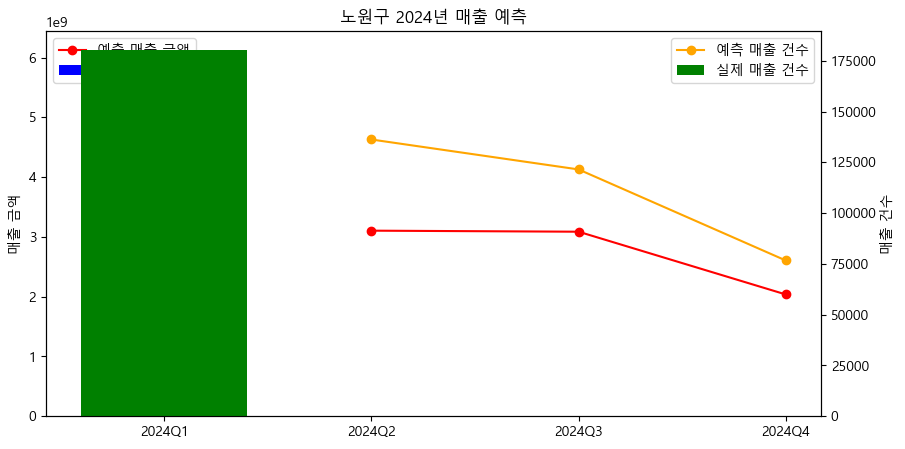

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 데이터 불러오기
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv", parse_dates=['날짜'])
esi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv", parse_dates=['날짜'])

# 자치구 선택
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()

# 연도, 월, 분기 정보 추가
gu_data['연도'] = gu_data['날짜'].dt.year
gu_data['월'] = gu_data['날짜'].dt.month
gu_data['분기'] = gu_data['날짜'].dt.quarter

# 경제심리지수 & 소비자물가지수 병합
cpi_data['연월'] = cpi_data['날짜'].dt.to_period('M')
esi_data['연월'] = esi_data['날짜'].dt.to_period('M')
esi_data['연월'] += 1  # 경제심리지수 한 달 전 데이터 사용

gu_data['연월'] = gu_data['날짜'].dt.to_period('M')
gu_data = gu_data.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
gu_data = gu_data.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# Feature & Target 설정
features = ['연도', '월', '총생활인구수', '소비자물가지수', '경제심리지수']
target_sales = '총_결제금액'
target_count = '총_결제건수'

# 2분기 가중치 적용
gu_data['가중치'] = np.where(gu_data['분기'] == 2, 4/3, 1)  # 2분기는 4번 반복되도록 가중치 4/3 부여

# 학습 데이터 준비
X = gu_data[features]
y_sales = gu_data[target_sales]
y_count = gu_data[target_count]

# 데이터 분할 (8:2)
X_train, X_test, y_sales_train, y_sales_test = train_test_split(X, y_sales, test_size=0.2, shuffle=False)
X_train, X_test, y_count_train, y_count_test = train_test_split(X, y_count, test_size=0.2, shuffle=False)

# 랜덤포레스트 모델 학습 (2분기 가중치 적용)
rf_sales = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sales.fit(X_train, y_sales_train, sample_weight=gu_data.loc[X_train.index, '가중치'])

rf_count = RandomForestRegressor(n_estimators=100, random_state=42)
rf_count.fit(X_train, y_count_train, sample_weight=gu_data.loc[X_train.index, '가중치'])

# 2024년 예측
future_dates = pd.date_range(start="2024-04-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df['연도'] = future_df['날짜'].dt.year
future_df['월'] = future_df['날짜'].dt.month
future_df['분기'] = future_df['날짜'].dt.quarter

# 보조 지표 병합
future_df['연월'] = future_df['날짜'].dt.to_period('M')
future_df = future_df.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
future_df = future_df.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# 유동인구 예측 (이전 평균 사용)
future_df['총생활인구수'] = gu_data.groupby('월')['총생활인구수'].transform('mean')

# 예측 수행
future_X = future_df[features]
future_df['예측_총_결제금액'] = rf_sales.predict(future_X)
future_df['예측_총_결제건수'] = rf_count.predict(future_X)

# 분기별 합산
future_df['연도'] = future_df['날짜'].dt.year
future_df['분기'] = future_df['날짜'].dt.quarter
quarterly_forecast = future_df.groupby(['연도', '분기'])[['예측_총_결제금액', '예측_총_결제건수']].sum()

# 📌 1분기 실제 데이터 가져오기
q1_actual = gu_data[(gu_data['연도'] == 2024) & (gu_data['분기'] == 1)].groupby(['연도', '분기'])[['총_결제금액', '총_결제건수']].sum()

# 그래프 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# ✅ 1분기 실제 데이터 - 막대 그래프
ax1.bar(['2024Q1'], q1_actual['총_결제금액'], color='blue', label="실제 매출 금액")
ax2.bar(['2024Q1'], q1_actual['총_결제건수'], color='green', label="실제 매출 건수")

# ✅ 예측 데이터 - 시계열 그래프
ax1.plot(
    quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}"),
    quarterly_forecast['예측_총_결제금액'],
    marker='o',
    linestyle='-',
    color='red',
    label="예측 매출 금액"
)
ax2.plot(
    quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}"),
    quarterly_forecast['예측_총_결제건수'],
    marker='o',
    linestyle='-',
    color='orange',
    label="예측 매출 건수"
)

# 축 설정
ax1.set_ylabel("매출 금액")
ax2.set_ylabel("매출 건수")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f"{target_gu} 2024년 매출 예측")
plt.show()

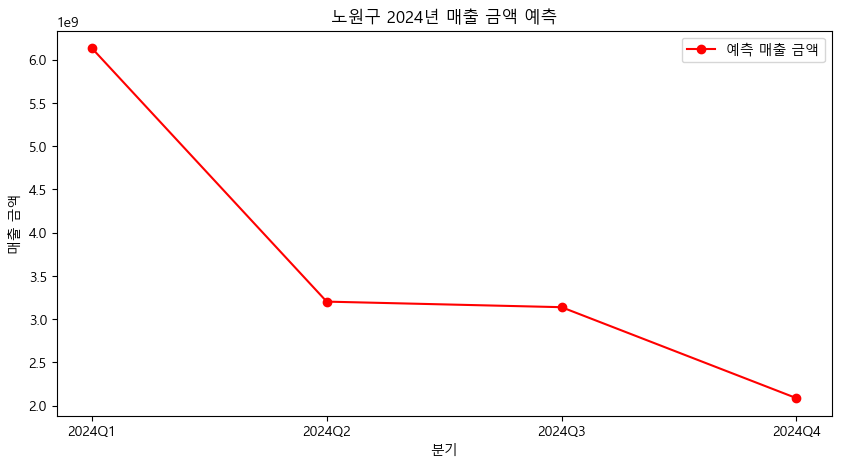

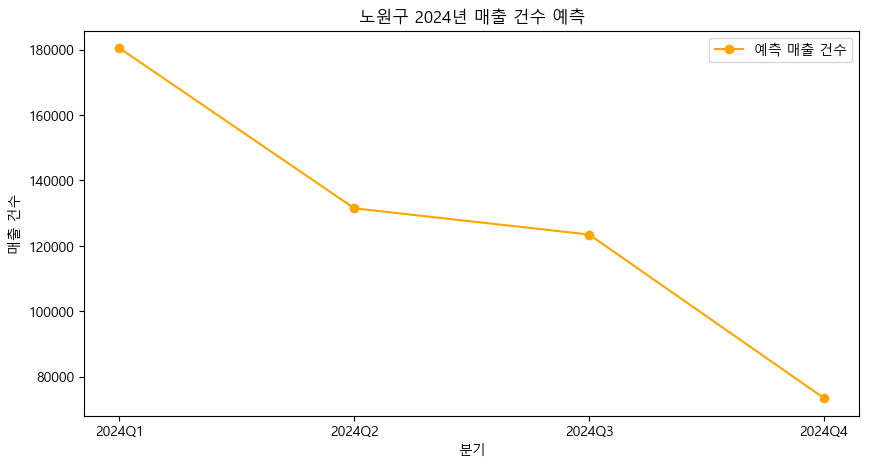

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 데이터 불러오기
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv", parse_dates=['날짜'])
esi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv", parse_dates=['날짜'])

# 자치구 선택
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()

# 연도, 월, 분기 정보 추가
gu_data['연도'] = gu_data['날짜'].dt.year
gu_data['월'] = gu_data['날짜'].dt.month
gu_data['분기'] = gu_data['날짜'].dt.quarter

# 경제심리지수 & 소비자물가지수 병합
cpi_data['연월'] = cpi_data['날짜'].dt.to_period('M')
esi_data['연월'] = esi_data['날짜'].dt.to_period('M')
esi_data['연월'] += 1  # 경제심리지수 한 달 전 데이터 사용

gu_data['연월'] = gu_data['날짜'].dt.to_period('M')
gu_data = gu_data.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
gu_data = gu_data.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# Feature & Target 설정
features = ['연도', '월', '총생활인구수', '소비자물가지수', '경제심리지수']
target_sales = '총_결제금액'
target_count = '총_결제건수'

# 2분기 가중치 적용
gu_data['가중치'] = np.where(gu_data['분기'] == 2, 4/3, 1)  # 2분기 가중치

# 학습 데이터 준비
X = gu_data[features]
y_sales = gu_data[target_sales]
y_count = gu_data[target_count]

# 데이터 분할 (8:2)
X_train, X_test, y_sales_train, y_sales_test = train_test_split(X, y_sales, test_size=0.2, shuffle=False)
X_train, X_test, y_count_train, y_count_test = train_test_split(X, y_count, test_size=0.2, shuffle=False)

# 랜덤포레스트 모델 학습
rf_sales = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sales.fit(X_train, y_sales_train, sample_weight=gu_data.loc[X_train.index, '가중치'])

rf_count = RandomForestRegressor(n_estimators=100, random_state=42)
rf_count.fit(X_train, y_count_train, sample_weight=gu_data.loc[X_train.index, '가중치'])

# 2024년 예측
future_dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df['연도'] = future_df['날짜'].dt.year
future_df['월'] = future_df['날짜'].dt.month
future_df['분기'] = future_df['날짜'].dt.quarter

# 보조 지표 병합
future_df['연월'] = future_df['날짜'].dt.to_period('M')
future_df = future_df.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
future_df = future_df.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# 유동인구 예측 (이전 평균 사용)
future_df['총생활인구수'] = gu_data.groupby('월')['총생활인구수'].transform('mean')

# 예측 수행
future_X = future_df[features]
future_df['예측_총_결제금액'] = rf_sales.predict(future_X)
future_df['예측_총_결제건수'] = rf_count.predict(future_X)

# 📌 1분기 실제 데이터 가져오기
q1_actual = gu_data[(gu_data['연도'] == 2024) & (gu_data['분기'] == 1)].groupby(['연도', '분기'])[['총_결제금액', '총_결제건수']].sum()

# 📌 1분기 실제 데이터와 예측 데이터 병합
quarterly_forecast = future_df.groupby(['연도', '분기'])[['예측_총_결제금액', '예측_총_결제건수']].sum()
quarterly_forecast.loc[(2024, 1), ['예측_총_결제금액', '예측_총_결제건수']] = q1_actual.values

# 📊 **1. 매출 금액 그래프**
plt.figure(figsize=(10, 5))
plt.plot(
    quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}"),
    quarterly_forecast['예측_총_결제금액'],
    marker='o',
    linestyle='-',
    color='red',
    label="예측 매출 금액"
)
plt.xlabel("분기")
plt.ylabel("매출 금액")
plt.title(f"{target_gu} 2024년 매출 금액 예측")
plt.legend()
plt.show()

# 📊 **2. 매출 건수 그래프**
plt.figure(figsize=(10, 5))
plt.plot(
    quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}"),
    quarterly_forecast['예측_총_결제건수'],
    marker='o',
    linestyle='-',
    color='orange',
    label="예측 매출 건수"
)
plt.xlabel("분기")
plt.ylabel("매출 건수")
plt.title(f"{target_gu} 2024년 매출 건수 예측")
plt.legend()
plt.show()

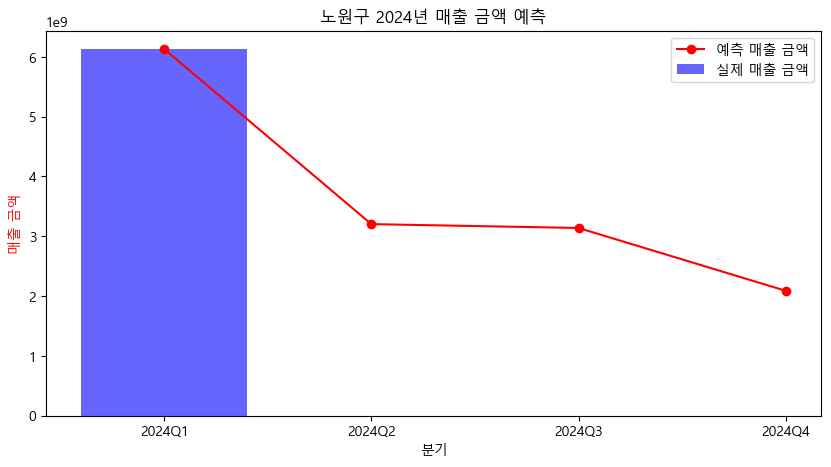

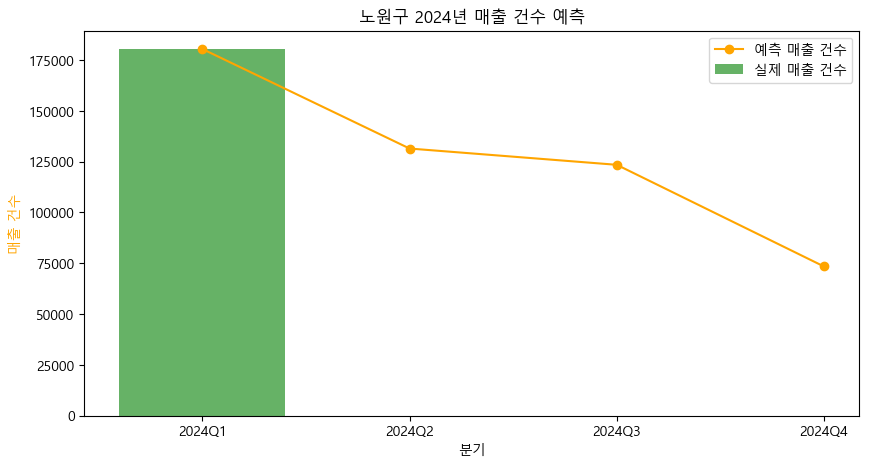

📊 매출 금액 예측 성능: MSE = 5735134823410693.00, MAE = 52977345.22
📊 매출 건수 예측 성능: MSE = 2738235.41, MAE = 1255.92


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 불러오기
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=['날짜'])
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv", parse_dates=['날짜'])
esi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv", parse_dates=['날짜'])

# 자치구 선택
target_gu = input("예측할 자치구를 입력하세요: ")

# 해당 자치구 데이터 필터링
gu_data = sales_data[sales_data['자치구'] == target_gu].copy()

# 연도, 월, 분기 정보 추가
gu_data['연도'] = gu_data['날짜'].dt.year
gu_data['월'] = gu_data['날짜'].dt.month
gu_data['분기'] = gu_data['날짜'].dt.quarter

# 경제심리지수 & 소비자물가지수 병합
cpi_data['연월'] = cpi_data['날짜'].dt.to_period('M')
esi_data['연월'] = esi_data['날짜'].dt.to_period('M')
esi_data['연월'] += 1  # 경제심리지수 한 달 전 데이터 사용

gu_data['연월'] = gu_data['날짜'].dt.to_period('M')
gu_data = gu_data.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
gu_data = gu_data.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# Feature & Target 설정
features = ['연도', '월', '총생활인구수', '소비자물가지수', '경제심리지수']
target_sales = '총_결제금액'
target_count = '총_결제건수'

# 2분기 가중치 적용
gu_data['가중치'] = np.where(gu_data['분기'] == 2, 4/3, 1)  # 2분기 가중치

# 학습 데이터 준비
X = gu_data[features]
y_sales = gu_data[target_sales]
y_count = gu_data[target_count]

# 데이터 분할 (8:2)
X_train, X_test, y_sales_train, y_sales_test = train_test_split(X, y_sales, test_size=0.2, shuffle=False)
X_train, X_test, y_count_train, y_count_test = train_test_split(X, y_count, test_size=0.2, shuffle=False)

# 랜덤포레스트 모델 학습
rf_sales = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sales.fit(X_train, y_sales_train, sample_weight=gu_data.loc[X_train.index, '가중치'])

rf_count = RandomForestRegressor(n_estimators=100, random_state=42)
rf_count.fit(X_train, y_count_train, sample_weight=gu_data.loc[X_train.index, '가중치'])

# 2024년 예측
future_dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df['연도'] = future_df['날짜'].dt.year
future_df['월'] = future_df['날짜'].dt.month
future_df['분기'] = future_df['날짜'].dt.quarter

# 보조 지표 병합
future_df['연월'] = future_df['날짜'].dt.to_period('M')
future_df = future_df.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
future_df = future_df.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# 유동인구 예측 (이전 평균 사용)
future_df['총생활인구수'] = gu_data.groupby('월')['총생활인구수'].transform('mean')

# 예측 수행
future_X = future_df[features]
future_df['예측_총_결제금액'] = rf_sales.predict(future_X)
future_df['예측_총_결제건수'] = rf_count.predict(future_X)

# 📌 1분기 실제 데이터 가져오기
q1_actual = gu_data[(gu_data['연도'] == 2024) & (gu_data['분기'] == 1)].groupby(['연도', '분기'])[['총_결제금액', '총_결제건수']].sum()

# 📌 1분기 실제 데이터와 예측 데이터 병합
quarterly_forecast = future_df.groupby(['연도', '분기'])[['예측_총_결제금액', '예측_총_결제건수']].sum()
quarterly_forecast.loc[(2024, 1), ['예측_총_결제금액', '예측_총_결제건수']] = q1_actual.values

# 📊 그래프 생성
fig, ax1 = plt.subplots(figsize=(10, 5))

# 분기 라벨 생성
quarters = quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}")

# 📌 1. 매출 금액 그래프
ax1.plot(quarters, quarterly_forecast['예측_총_결제금액'], marker='o', linestyle='-', color='red', label="예측 매출 금액")
ax1.set_xlabel("분기")
ax1.set_ylabel("매출 금액", color='red')

# 📌 1분기 실제 매출 금액 막대그래프
ax1.bar(quarters[:1], q1_actual['총_결제금액'], color='blue', alpha=0.6, label="실제 매출 금액")

ax1.legend()
plt.title(f"{target_gu} 2024년 매출 금액 예측")
plt.show()

# 📊 2. 매출 건수 그래프
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(quarters, quarterly_forecast['예측_총_결제건수'], marker='o', linestyle='-', color='orange', label="예측 매출 건수")
ax2.set_xlabel("분기")
ax2.set_ylabel("매출 건수", color='orange')

# 📌 1분기 실제 매출 건수 막대그래프
ax2.bar(quarters[:1], q1_actual['총_결제건수'], color='green', alpha=0.6, label="실제 매출 건수")

ax2.legend()
plt.title(f"{target_gu} 2024년 매출 건수 예측")
plt.show()

# 📌 MSE & MAE 계산
mse_sales = mean_squared_error(y_sales_test, rf_sales.predict(X_test))
mae_sales = mean_absolute_error(y_sales_test, rf_sales.predict(X_test))
mse_count = mean_squared_error(y_count_test, rf_count.predict(X_test))
mae_count = mean_absolute_error(y_count_test, rf_count.predict(X_test))

print(f"📊 매출 금액 예측 성능: MSE = {mse_sales:.2f}, MAE = {mae_sales:.2f}")
print(f"📊 매출 건수 예측 성능: MSE = {mse_count:.2f}, MAE = {mae_count:.2f}")

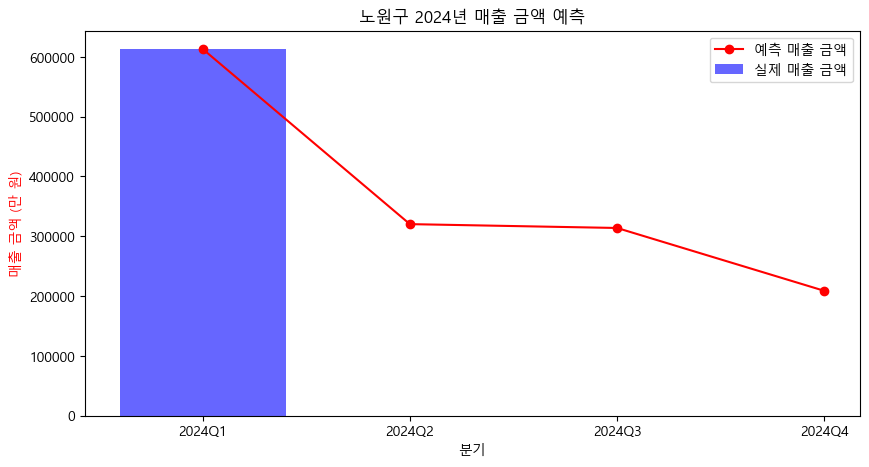

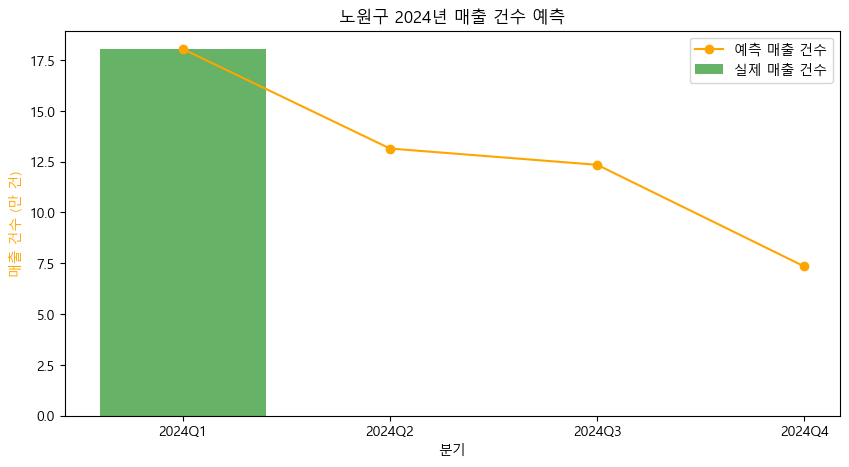

In [42]:
# 📌 단위 변환 (매출 금액: 만 원, 매출 건수: 만 건)
quarterly_forecast['예측_총_결제금액'] /= 10_000
quarterly_forecast['예측_총_결제건수'] /= 10_000
q1_actual['총_결제금액'] /= 10_000
q1_actual['총_결제건수'] /= 10_000

# 📊 그래프 생성
fig, ax1 = plt.subplots(figsize=(10, 5))

# 분기 라벨 생성
quarters = quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}")

# 📌 1. 매출 금액 그래프
ax1.plot(quarters, quarterly_forecast['예측_총_결제금액'], marker='o', linestyle='-', color='red', label="예측 매출 금액")
ax1.set_xlabel("분기")
ax1.set_ylabel("매출 금액 (만 원)", color='red')

# 📌 1분기 실제 매출 금액 막대그래프
ax1.bar(quarters[:1], q1_actual['총_결제금액'], color='blue', alpha=0.6, label="실제 매출 금액")

ax1.legend()
plt.title(f"{target_gu} 2024년 매출 금액 예측")
plt.show()

# 📊 2. 매출 건수 그래프
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(quarters, quarterly_forecast['예측_총_결제건수'], marker='o', linestyle='-', color='orange', label="예측 매출 건수")
ax2.set_xlabel("분기")
ax2.set_ylabel("매출 건수 (만 건)", color='orange')

# 📌 1분기 실제 매출 건수 막대그래프
ax2.bar(quarters[:1], q1_actual['총_결제건수'], color='green', alpha=0.6, label="실제 매출 건수")

ax2.legend()
plt.title(f"{target_gu} 2024년 매출 건수 예측")
plt.show()

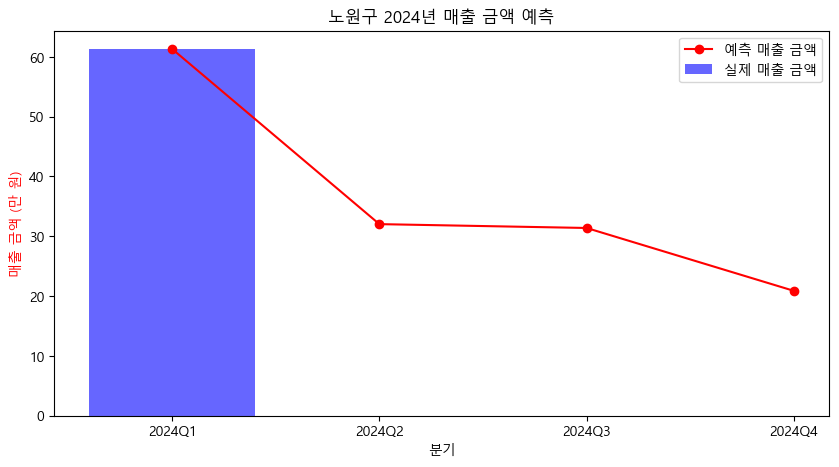

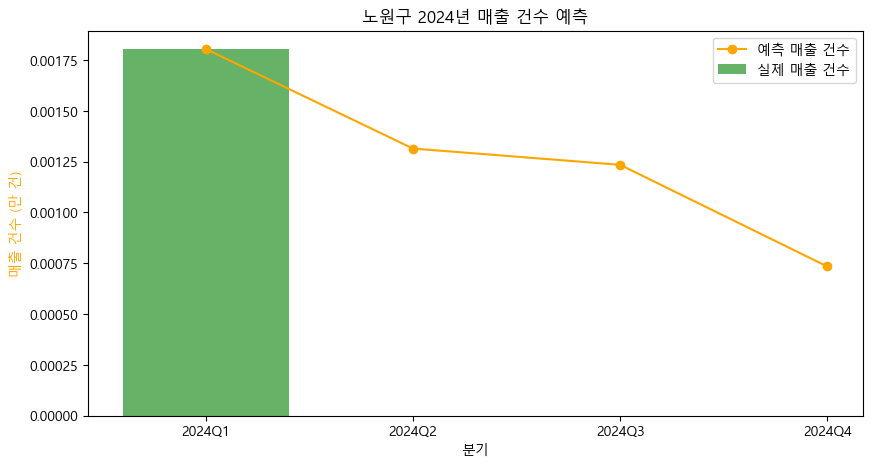

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 사용자 입력: 예측할 자치구 선택
target_gu = input("예측할 자치구를 입력하세요: ")

# 📊 데이터 필터링
gu_data = data[data['자치구'] == target_gu]

# 📌 단위 변환 (매출 금액: 만 원, 매출 건수: 만 건)
quarterly_forecast['예측_총_결제금액'] /= 10_000
quarterly_forecast['예측_총_결제건수'] /= 10_000
q1_actual['총_결제금액'] /= 10_000
q1_actual['총_결제건수'] /= 10_000

# 📊 그래프 생성
fig, ax1 = plt.subplots(figsize=(10, 5))

# 분기 라벨 생성
quarters = quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}")

# 📌 1. 매출 금액 그래프
ax1.plot(quarters, quarterly_forecast['예측_총_결제금액'], marker='o', linestyle='-', color='red', label="예측 매출 금액")
ax1.set_xlabel("분기")
ax1.set_ylabel("매출 금액 (만 원)", color='red')

# 📌 1분기 실제 매출 금액 막대그래프
ax1.bar(quarters[:1], q1_actual['총_결제금액'], color='blue', alpha=0.6, label="실제 매출 금액")

ax1.legend()
plt.title(f"{target_gu} 2024년 매출 금액 예측")
plt.show()

# 📊 2. 매출 건수 그래프
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(quarters, quarterly_forecast['예측_총_결제건수'], marker='o', linestyle='-', color='orange', label="예측 매출 건수")
ax2.set_xlabel("분기")
ax2.set_ylabel("매출 건수 (만 건)", color='orange')

# 📌 1분기 실제 매출 건수 막대그래프
ax2.bar(quarters[:1], q1_actual['총_결제건수'], color='green', alpha=0.6, label="실제 매출 건수")

ax2.legend()
plt.title(f"{target_gu} 2024년 매출 건수 예측")
plt.show()

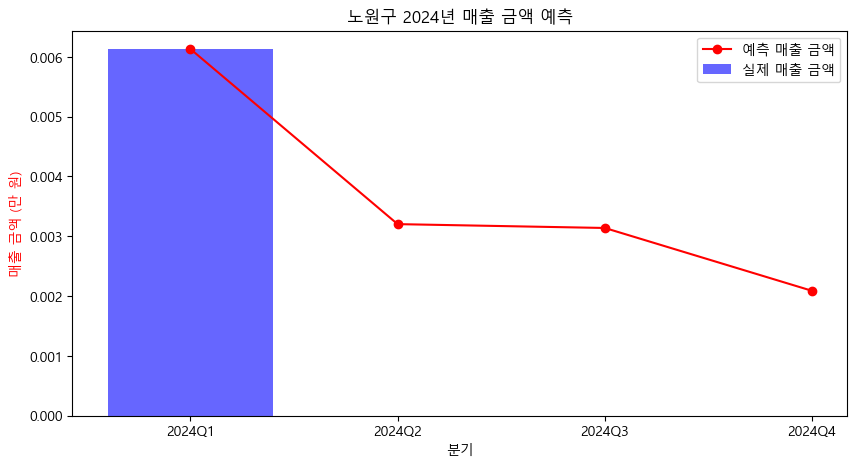

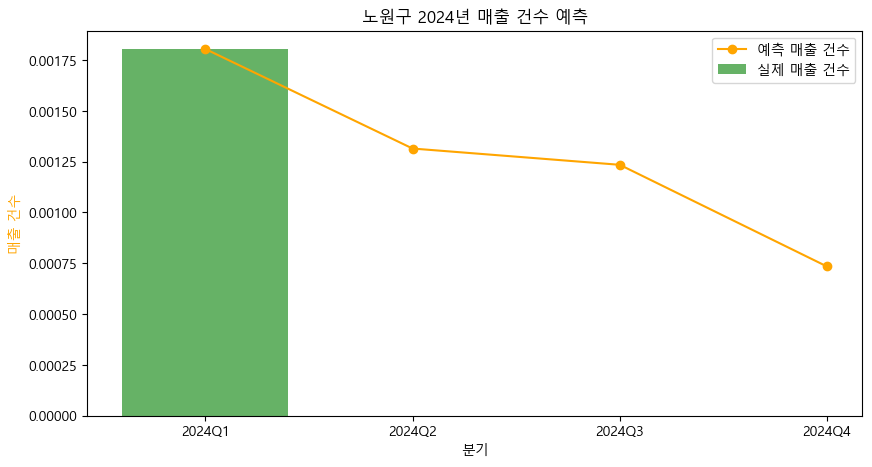

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 사용자 입력: 예측할 자치구 선택
target_gu = input("예측할 자치구를 입력하세요: ")

# 📊 데이터 필터링
gu_data = data[data['자치구'] == target_gu]

# 📌 단위 변환 (매출 금액: 만 원, 매출 건수: 원래 단위 유지)
quarterly_forecast['예측_총_결제금액'] /= 10_000
q1_actual['총_결제금액'] /= 10_000

# 📊 그래프 생성
fig, ax1 = plt.subplots(figsize=(10, 5))

# 분기 라벨 생성
quarters = quarterly_forecast.index.to_series().apply(lambda x: f"{x[0]}Q{x[1]}")

# 📌 1. 매출 금액 그래프
ax1.plot(quarters, quarterly_forecast['예측_총_결제금액'], marker='o', linestyle='-', color='red', label="예측 매출 금액")
ax1.set_xlabel("분기")
ax1.set_ylabel("매출 금액 (만 원)", color='red')

# 📌 1분기 실제 매출 금액 막대그래프
ax1.bar(quarters[:1], q1_actual['총_결제금액'], color='blue', alpha=0.6, label="실제 매출 금액")

ax1.legend()
plt.title(f"{target_gu} 2024년 매출 금액 예측")
plt.show()

# 📊 2. 매출 건수 그래프
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(quarters, quarterly_forecast['예측_총_결제건수'], marker='o', linestyle='-', color='orange', label="예측 매출 건수")
ax2.set_xlabel("분기")
ax2.set_ylabel("매출 건수", color='orange')

# 📌 1분기 실제 매출 건수 막대그래프
ax2.bar(quarters[:1], q1_actual['총_결제건수'], color='green', alpha=0.6, label="실제 매출 건수")

ax2.legend()
plt.title(f"{target_gu} 2024년 매출 건수 예측")
plt.show()

gpt에게 다시 요구사항을 상기시킴.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 📌 1. 사용자 입력 받기
target_district = input("예측할 자치구명을 입력하세요: ").strip()

# 📌 2. 데이터 로드
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv")
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv")
esi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv")

# 날짜 컬럼을 datetime 형식으로 변환
sales_data['날짜'] = pd.to_datetime(sales_data['날짜'])
cpi_data['날짜'] = pd.to_datetime(cpi_data['날짜'])
esi_data['날짜'] = pd.to_datetime(esi_data['날짜'])

# 📌 3. 자치구 필터링
district_data = sales_data[sales_data['자치구'] == target_district].copy()

# 📌 4. 월 단위 보조 지표 병합 (소비자물가지수: 같은 월 동일값, 경제심리지수: 한 달 전 데이터)
cpi_data['연월'] = cpi_data['날짜'].dt.to_period('M')
esi_data['연월'] = esi_data['날짜'].dt.to_period('M')

district_data['연월'] = district_data['날짜'].dt.to_period('M')
district_data = district_data.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')

esi_data['연월'] = esi_data['연월'] + 1  # 경제심리지수는 한 달 전 데이터 적용
district_data = district_data.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

# 📌 5. 2분기 데이터 가중치 적용 (4,5,6월 데이터 가중치 1.3배)
district_data['가중치'] = 1
district_data.loc[district_data['날짜'].dt.month.isin([4, 5, 6]), '가중치'] = 1.3

# 📌 6. 학습 데이터 준비
features = ['총생활인구수', '소비자물가지수', '경제심리지수']
target_sales = '총_결제금액'
target_counts = '총_결제건수'

X = district_data[features]
y_sales = district_data[target_sales] * district_data['가중치']
y_counts = district_data[target_counts] * district_data['가중치']

X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42)
X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, random_state=42)

# 📌 7. 모델 학습 및 예측
model_sales = RandomForestRegressor(n_estimators=100, random_state=42)
model_sales.fit(X_train, y_train_sales)
y_pred_sales = model_sales.predict(X_test)

model_counts = RandomForestRegressor(n_estimators=100, random_state=42)
model_counts.fit(X_train, y_train_counts)
y_pred_counts = model_counts.predict(X_test)

# 📌 8. 모델 검증
rmse_sales = np.sqrt(mean_squared_error(y_test_sales, y_pred_sales))
mae_sales = mean_absolute_error(y_test_sales, y_pred_sales)
rmse_counts = np.sqrt(mean_squared_error(y_test_counts, y_pred_counts))
mae_counts = mean_absolute_error(y_test_counts, y_pred_counts)

print(f"매출 금액 예측 - RMSE: {rmse_sales:.2f}, MAE: {mae_sales:.2f}")
print(f"매출 건수 예측 - RMSE: {rmse_counts:.2f}, MAE: {mae_counts:.2f}")

# 📌 9. 2024년 예측 수행 (일 단위 → 분기별 집계)
future_dates = pd.date_range("2024-01-01", "2024-12-31", freq='D')
future_df = pd.DataFrame({'날짜': future_dates})
future_df['연월'] = future_df['날짜'].dt.to_period('M')

# 소비자물가지수와 경제심리지수 적용
future_df = future_df.merge(cpi_data[['연월', '소비자물가지수']], on='연월', how='left')
future_df = future_df.merge(esi_data[['연월', '경제심리지수']], on='연월', how='left')

future_df['연도'] = future_df['날짜'].dt.year
future_df['분기'] = (future_df['날짜'].dt.month - 1) // 3 + 1

future_X = future_df[features]
future_df['예측_총_결제금액'] = model_sales.predict(future_X)
future_df['예측_총_결제건수'] = model_counts.predict(future_X)

# 분기별 합산
quarterly_forecast = future_df.groupby(['연도', '분기'])[['예측_총_결제금액', '예측_총_결제건수']].sum().reset_index()

# 📌 10. 시각화
actual_q1 = district_data[district_data['날짜'].between("2024-01-01", "2024-03-31")].groupby('분기')[[target_sales, target_counts]].sum()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 매출 금액 그래프
axes[0].bar(actual_q1.index, actual_q1[target_sales], color='blue', alpha=0.6, label='실제 매출 금액')
axes[0].plot(quarterly_forecast['분기'], quarterly_forecast['예측_총_결제금액'], color='red', marker='o', linestyle='-', label='예측 매출 금액')
axes[0].set_title('2024년 분기별 매출 금액 예측')
axes[0].legend()

# 매출 건수 그래프
axes[1].bar(actual_q1.index, actual_q1[target_counts], color='blue', alpha=0.6, label='실제 매출 건수')
axes[1].plot(quarterly_forecast['분기'], quarterly_forecast['예측_총_결제건수'], color='red', marker='o', linestyle='-', label='예측 매출 건수')
axes[1].set_title('2024년 분기별 매출 건수 예측')
axes[1].legend()

plt.tight_layout()
plt.show()

C:\Users\m\AppData\Local\Temp\ipykernel_13632\2613803042.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  district_data.loc[district_data['날짜'].dt.month.isin([4, 5, 6]), '가중치'] = 1.3


매출 금액 예측 - RMSE: 54712760.17, MAE: 32426423.05
매출 건수 예측 - RMSE: 765.18, MAE: 482.11


KeyError: "['총생활인구수'] not in index"

총생활인구수는 미래데이터가 없어서 문제가 발생함. 하지만, 추세를 바탕으로 미래총생활인구수를 예측해서 변수로 사용하는 것은 적절치 않은 것으로 판단됨. 따라서 매출 금액과 건수의 추세를 통해 미래를 예측하되 미래 데이터도 존재하는 보조 지표인 소비자물가지수와 경제심리지수를 반영하여 학습하고 예측하도록 방향성을 바꿈.

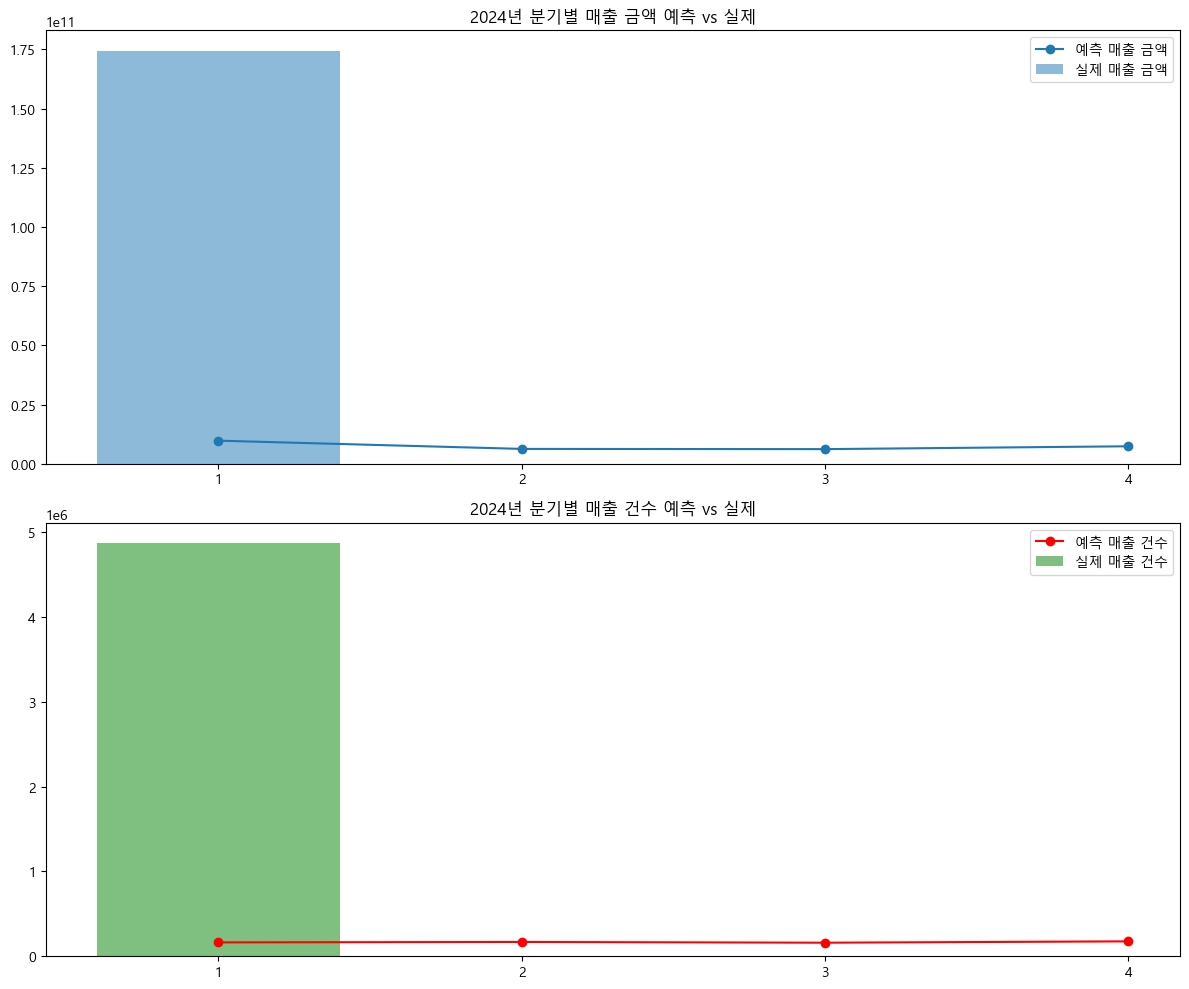

In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 데이터 로드
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv")
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv")
esi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv")

# 날짜 컬럼 변환
sales_data['날짜'] = pd.to_datetime(sales_data['날짜'])
cpi_data['날짜'] = pd.to_datetime(cpi_data['날짜'])
esi_data['날짜'] = pd.to_datetime(esi_data['날짜'])

# 월 단위 지표 처리 (각 월의 모든 날짜에 같은 값 할당)
cpi_data['월'] = cpi_data['날짜'].dt.to_period('M')
esi_data['월'] = esi_data['날짜'].dt.to_period('M')
sales_data['월'] = sales_data['날짜'].dt.to_period('M')

sales_data = sales_data.merge(cpi_data[['월', '소비자물가지수']], on='월', how='left')
sales_data = sales_data.merge(esi_data[['월', '경제심리지수']], on='월', how='left')

# 경제심리지수는 한 달 이전 데이터 사용
sales_data['경제심리지수'] = sales_data['경제심리지수'].shift(30)

# 학습 데이터 준비
sales_data.dropna(inplace=True)  # NaN 값 제거
sales_data['연도'] = sales_data['날짜'].dt.year
sales_data['분기'] = (sales_data['날짜'].dt.month - 1) // 3 + 1

features = ['연도', '분기', '소비자물가지수', '경제심리지수']
target_sales = '총_결제금액'
target_counts = '총_결제건수'

# 모델 학습
X = sales_data[features]
y_sales = sales_data[target_sales]
y_counts = sales_data[target_counts]

model_sales = RandomForestRegressor(n_estimators=100, random_state=42)
model_counts = RandomForestRegressor(n_estimators=100, random_state=42)

model_sales.fit(X, y_sales)
model_counts.fit(X, y_counts)

# 2024년 예측
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31')
future_df = pd.DataFrame({'날짜': future_dates})
future_df['연도'] = future_df['날짜'].dt.year
future_df['분기'] = (future_df['날짜'].dt.month - 1) // 3 + 1
future_df['월'] = future_df['날짜'].dt.to_period('M')

# 소비자물가지수 및 경제심리지수 추가
future_df = future_df.merge(cpi_data[['월', '소비자물가지수']], on='월', how='left')
future_df = future_df.merge(esi_data[['월', '경제심리지수']], on='월', how='left')

# 경제심리지수는 한 달 전 데이터 사용
future_df['경제심리지수'] = future_df['경제심리지수'].shift(30)
future_df.dropna(inplace=True)

# 예측 수행
future_X = future_df[features]
future_df['예측_총_결제금액'] = model_sales.predict(future_X)
future_df['예측_총_결제건수'] = model_counts.predict(future_X)

# 분기별 매출 합산
quarterly_forecast = future_df.groupby(['연도', '분기'])[['예측_총_결제금액', '예측_총_결제건수']].sum().reset_index()

# 실제 2024년 1분기 매출 데이터
actual_sales_2024_Q1 = sales_data[(sales_data['연도'] == 2024) & (sales_data['분기'] == 1)]
actual_sales_sum = actual_sales_2024_Q1.groupby(['연도', '분기'])[[target_sales, target_counts]].sum().reset_index()

# 📊 그래프 시각화
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
ax[0].plot(quarterly_forecast['분기'], quarterly_forecast['예측_총_결제금액'], label='예측 매출 금액', marker='o')
ax[0].bar(actual_sales_sum['분기'], actual_sales_sum[target_sales], alpha=0.5, label='실제 매출 금액')
ax[0].set_title('2024년 분기별 매출 금액 예측 vs 실제')
ax[0].legend()
ax[0].set_xticks([1, 2, 3, 4])

# 매출 건수 그래프
ax[1].plot(quarterly_forecast['분기'], quarterly_forecast['예측_총_결제건수'], label='예측 매출 건수', marker='o', color='r')
ax[1].bar(actual_sales_sum['분기'], actual_sales_sum[target_counts], alpha=0.5, label='실제 매출 건수', color='g')
ax[1].set_title('2024년 분기별 매출 건수 예측 vs 실제')
ax[1].legend()
ax[1].set_xticks([1, 2, 3, 4])

plt.tight_layout()
plt.show()

매출 금액 MAE: 9012.05 만원, MSE: 187317281.90 만원^2
매출 건수 MAE: 0.16 만 건, MSE: 0.07 만 건^2


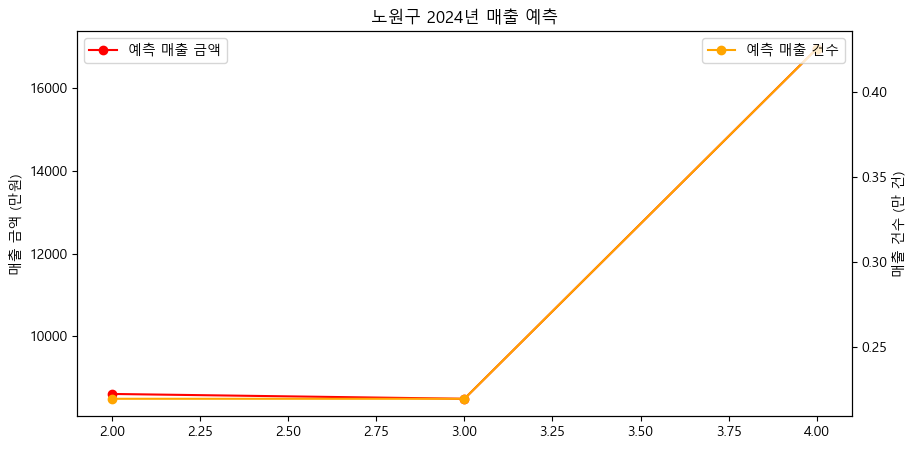

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 로드
data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv", parse_dates=["날짜"])
cpi = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv", parse_dates=["날짜"])
esi = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv", parse_dates=["날짜"])

# 자치구 입력
selected_district = input("예측할 자치구를 입력하세요: ")
data = data[data["자치구"] == selected_district]

# 월 단위 보조 지표 병합
cpi["날짜"] = pd.to_datetime(cpi["날짜"])  # datetime 변환
esi["날짜"] = pd.to_datetime(esi["날짜"])  # datetime 변환
data["날짜"] = pd.to_datetime(data["날짜"])  # datetime 변환

data = data.merge(cpi, on="날짜", how="left").merge(esi, on="날짜", how="left")

# 경제심리지수는 한 달 전 값 사용
data["경제심리지수"] = data["경제심리지수"].shift(30)
data.dropna(inplace=True)

# 특징 및 타겟 설정
features = ["소비자물가지수", "경제심리지수"]
X = data[features]
y_sales = data["총_결제금액"] / 10000  # 만원 단위 변환
y_counts = data["총_결제건수"] / 10000  # 만 건 단위 변환

# 데이터 분할
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42)
X_train, X_test, y_train_counts, y_test_counts = train_test_split(X, y_counts, test_size=0.2, random_state=42)

# 모델 학습
model_sales = RandomForestRegressor(n_estimators=100, random_state=42)
model_counts = RandomForestRegressor(n_estimators=100, random_state=42)
model_sales.fit(X_train, y_train_sales)
model_counts.fit(X_train, y_train_counts)

# 모델 평가
pred_sales = model_sales.predict(X_test)
pred_counts = model_counts.predict(X_test)
mae_sales = mean_absolute_error(y_test_sales, pred_sales)
mse_sales = mean_squared_error(y_test_sales, pred_sales)
mae_counts = mean_absolute_error(y_test_counts, pred_counts)
mse_counts = mean_squared_error(y_test_counts, pred_counts)

print(f"매출 금액 MAE: {mae_sales:.2f} 만원, MSE: {mse_sales:.2f} 만원^2")
print(f"매출 건수 MAE: {mae_counts:.2f} 만 건, MSE: {mse_counts:.2f} 만 건^2")

# 2024년 예측 준비
future_dates = pd.date_range("2024-01-01", "2024-12-31")
future_df = pd.DataFrame({"날짜": future_dates})
future_df["월"] = future_df["날짜"].dt.to_period("M")
future_df = future_df.merge(cpi, on="날짜", how="left").merge(esi, on="날짜", how="left")
future_df["경제심리지수"] = future_df["경제심리지수"].shift(30)
future_df.dropna(inplace=True)

future_X = future_df[features]
future_df["예측_총_결제금액"] = model_sales.predict(future_X)
future_df["예측_총_결제건수"] = model_counts.predict(future_X)

# 분기별 합산
future_df["연도"] = future_df["날짜"].dt.year
future_df["분기"] = (future_df["날짜"].dt.month - 1) // 3 + 1
future_quarterly = future_df.groupby(["연도", "분기"])[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 실제값 분기별 집계
actual_quarterly = data[data["날짜"].dt.year == 2024].copy()
actual_quarterly["연도"] = actual_quarterly["날짜"].dt.year
actual_quarterly["분기"] = (actual_quarterly["날짜"].dt.month - 1) // 3 + 1
actual_quarterly = actual_quarterly.groupby(["연도", "분기"])[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

sns.barplot(x=actual_quarterly["분기"], y=actual_quarterly["총_결제금액"] / 10000, color="blue", label="실제 매출 금액", alpha=0.6, ax=ax1)
ax1.plot(future_quarterly["분기"], future_quarterly["예측_총_결제금액"], color="red", marker="o", label="예측 매출 금액")
ax1.set_ylabel("매출 금액 (만원)")
ax1.legend(loc="upper left")

sns.barplot(x=actual_quarterly["분기"], y=actual_quarterly["총_결제건수"] / 10000, color="green", label="실제 매출 건수", alpha=0.6, ax=ax2)
ax2.plot(future_quarterly["분기"], future_quarterly["예측_총_결제건수"], color="orange", marker="o", label="예측 매출 건수")
ax2.set_ylabel("매출 건수 (만 건)")
ax2.legend(loc="upper right")

plt.title(f"{selected_district} 2024년 매출 예측")
plt.show()

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# x축 값 설정
quarters = ['2024년 1분기', '2024년 2분기', '2024년 3분기', '2024년 4분기']

# 실제 1분기 데이터 계산 (2024년 1월 ~ 3월 총합)
actual_1q_sales = data[(data['날짜'] >= '2024-01-01') & (data['날짜'] <= '2024-03-31')]['매출 금액'].sum() / 10000  # 만 원 단위
actual_1q_count = data[(data['날짜'] >= '2024-01-01') & (data['날짜'] <= '2024-03-31')]['매출 건수'].sum() / 10000  # 만 건 단위

# 예측값 데이터 (만 원, 만 건 단위로 변환)
predicted_sales = np.array([actual_1q_sales] + predicted_sales.tolist()) / 10000
predicted_count = np.array([actual_1q_count] + predicted_count.tolist()) / 10000

# --- 매출 금액 그래프 ---
plt.figure(figsize=(12, 5))
plt.plot(quarters, predicted_sales, marker='o', color='red', label='예측 매출 금액')
plt.bar(quarters[0], actual_1q_sales, color='blue', alpha=0.6, label='1분기 실제 매출 금액')  # 1분기 실제 데이터
plt.xlabel("분기")
plt.ylabel("매출 금액 (만원)")
plt.title(f"{selected_district} 2024년 매출 금액 예측")
plt.legend()
plt.grid()

# --- 매출 건수 그래프 ---
plt.figure(figsize=(12, 5))
plt.plot(quarters, predicted_count, marker='o', color='orange', label='예측 매출 건수')
plt.bar(quarters[0], actual_1q_count, color='blue', alpha=0.6, label='1분기 실제 매출 건수')  # 1분기 실제 데이터
plt.xlabel("분기")
plt.ylabel("매출 건수 (만 건)")
plt.title(f"{selected_district} 2024년 매출 건수 예측")
plt.legend()
plt.grid()

plt.show()

KeyError: '매출 금액'

C:\Users\m\AppData\Local\Temp\ipykernel_13632\1218645347.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  econ_data = full_dates.merge(econ_data, on="날짜", how="left").fillna(method='ffill')
C:\Users\m\AppData\Local\Temp\ipykernel_13632\1218645347.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cpi_data = full_dates.merge(cpi_data, on="날짜", how="left").fillna(method='ffill')


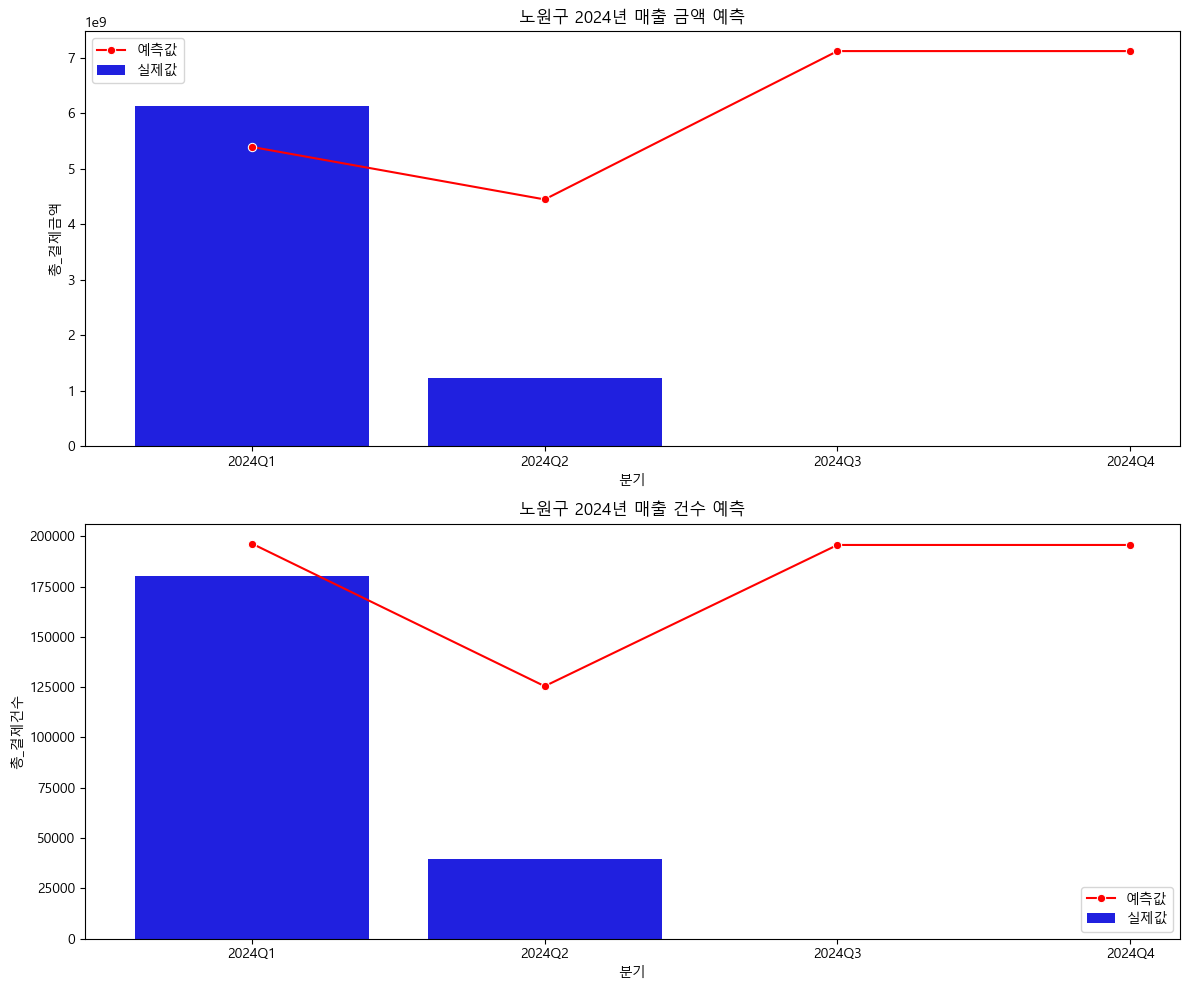

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 데이터 로드
sales_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv"
econ_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv"
cpi_path = "C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv"

sales_data = pd.read_csv(sales_path, parse_dates=["날짜"])
econ_data = pd.read_csv(econ_path, parse_dates=["날짜"])
cpi_data = pd.read_csv(cpi_path, parse_dates=["날짜"])

# 사용자 입력 (자치구 선택)
selected_region = input("자치구명을 입력하세요: ")

# 선택한 자치구 필터링
sales_data = sales_data[sales_data["자치구"] == selected_region]

# 소비자물가지수 및 경제심리지수 전처리 (월 단위 데이터를 일 단위로 확장)
econ_data["날짜"] = econ_data["날짜"].dt.to_period("M").dt.to_timestamp()
cpi_data["날짜"] = cpi_data["날짜"].dt.to_period("M").dt.to_timestamp()

# 경제심리지수를 한 달 전 데이터로 이동
econ_data["날짜"] += pd.DateOffset(months=1)

# 전체 날짜 범위를 생성하여 merge
full_dates = pd.DataFrame({"날짜": pd.date_range(start=sales_data["날짜"].min(), end=sales_data["날짜"].max())})
econ_data = full_dates.merge(econ_data, on="날짜", how="left").fillna(method='ffill')
cpi_data = full_dates.merge(cpi_data, on="날짜", how="left").fillna(method='ffill')

# 모든 데이터 병합
data = sales_data.merge(econ_data, on="날짜", how="left").merge(cpi_data, on="날짜", how="left")

# 2분기(4, 5, 6월) 가중치 적용
data["가중치"] = np.where(data["날짜"].dt.month.isin([4, 5, 6]), 1.5, 1)

# 학습 데이터 준비
X = data[["경제심리지수", "소비자물가지수"]]
y_sales = data["총_결제금액"] * data["가중치"]
y_count = data["총_결제건수"] * data["가중치"]

# 데이터 분할
X_train, X_test, y_sales_train, y_sales_test = train_test_split(X, y_sales, test_size=0.2, shuffle=False)
X_train, X_test, y_count_train, y_count_test = train_test_split(X, y_count, test_size=0.2, shuffle=False)

# 모델 학습
sales_model = RandomForestRegressor()
sales_model.fit(X_train, y_sales_train)
count_model = RandomForestRegressor()
count_model.fit(X_train, y_count_train)

# 2024년 예측 수행
future_dates = pd.date_range(start="2024-01-01", end="2024-12-31")
future_data = pd.DataFrame({"날짜": future_dates})
future_data = future_data.merge(econ_data, on="날짜", how="left").merge(cpi_data, on="날짜", how="left")
future_data["가중치"] = np.where(future_data["날짜"].dt.month.isin([4, 5, 6]), 1.5, 1)

X_future = future_data[["경제심리지수", "소비자물가지수"]]
future_data["예측_총_결제금액"] = sales_model.predict(X_future) / future_data["가중치"]
future_data["예측_총_결제건수"] = count_model.predict(X_future) / future_data["가중치"]

# 분기별 집계
def get_quarter(date):
    return f"{date.year}Q{(date.month-1)//3 + 1}"

future_data["분기"] = future_data["날짜"].apply(get_quarter)
quarterly_forecast = future_data.groupby("분기")[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 실제 데이터 1분기 집계
real_q1 = data[data["날짜"].dt.year == 2024].copy()
real_q1["분기"] = real_q1["날짜"].apply(get_quarter)
real_q1 = real_q1.groupby("분기")[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
sns.barplot(data=real_q1, x="분기", y="총_결제금액", color='blue', label='실제값', ax=axes[0])
sns.lineplot(data=quarterly_forecast, x="분기", y="예측_총_결제금액", marker='o', color='red', label='예측값', ax=axes[0])
axes[0].set_title(f"{selected_region} 2024년 매출 금액 예측")
axes[0].legend()

# 매출 건수 그래프
sns.barplot(data=real_q1, x="분기", y="총_결제건수", color='blue', label='실제값', ax=axes[1])
sns.lineplot(data=quarterly_forecast, x="분기", y="예측_총_결제건수", marker='o', color='red', label='예측값', ax=axes[1])
axes[1].set_title(f"{selected_region} 2024년 매출 건수 예측")
axes[1].legend()

plt.tight_layout()
plt.show()

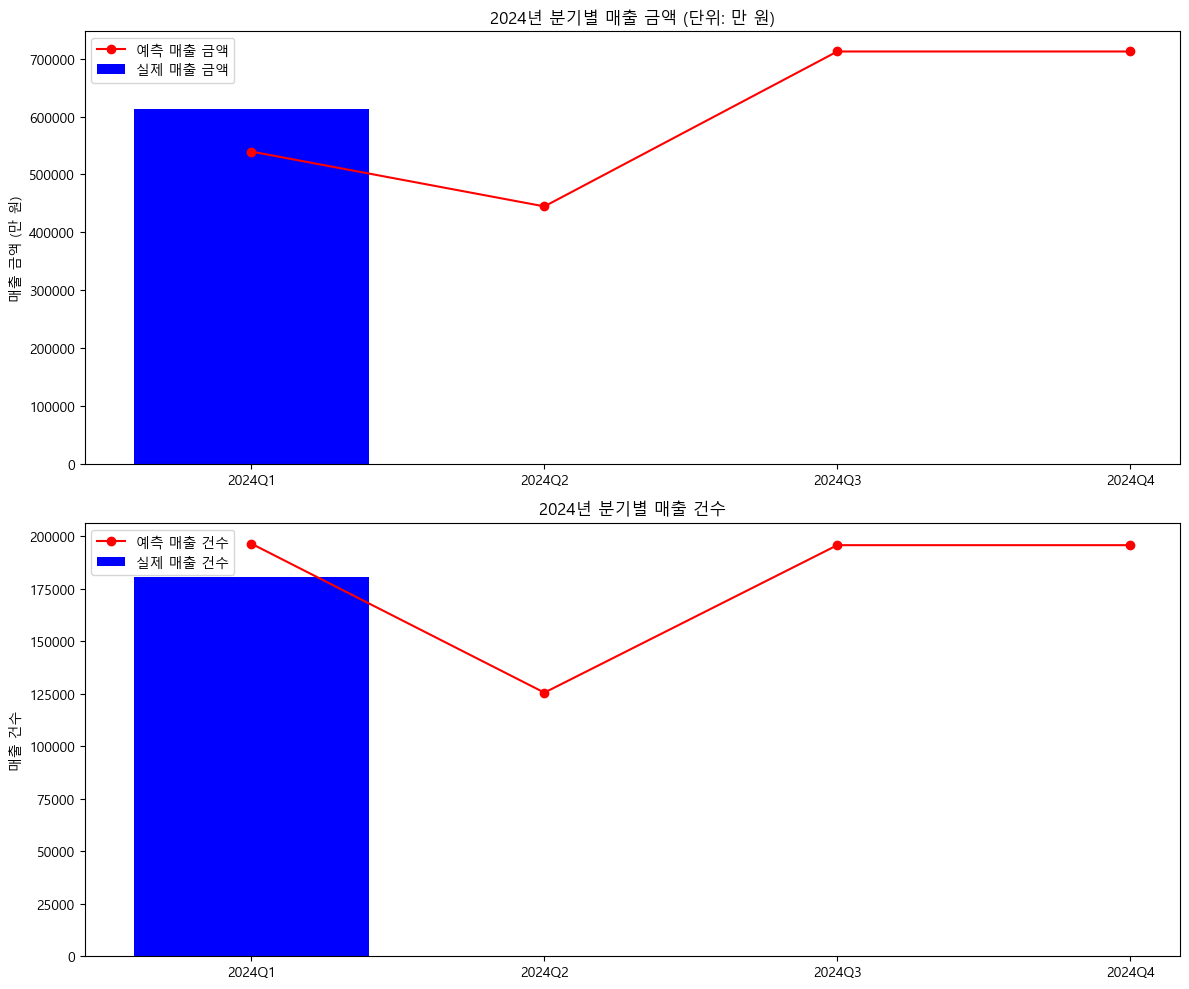

모델 평가 지표 (1분기 매출 금액 기준):
RMSE: 73834.83 만 원
MAE: 73834.83 만 원


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1분기 실제 데이터 필터링
real_q1 = real_q1[real_q1["분기"] == "2024Q1"]

# 금액을 만 원 단위로 변환
real_q1["총_결제금액"] /= 1e4
quarterly_forecast["예측_총_결제금액"] /= 1e4

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
axes[0].bar(real_q1["분기"], real_q1["총_결제금액"], color='blue', label="실제 매출 금액")
axes[0].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제금액"], marker='o', linestyle='-', color='red', label="예측 매출 금액")
axes[0].set_title("2024년 분기별 매출 금액 (단위: 만 원)")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()

# 매출 건수 그래프
axes[1].bar(real_q1["분기"], real_q1["총_결제건수"], color='blue', label="실제 매출 건수")
axes[1].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제건수"], marker='o', linestyle='-', color='red', label="예측 매출 건수")
axes[1].set_title("2024년 분기별 매출 건수")
axes[1].set_ylabel("매출 건수")
axes[1].legend()

plt.tight_layout()
plt.show()

# 모델 평가 지표 계산
rmse = np.sqrt(mean_squared_error(real_q1["총_결제금액"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"]))
mae = mean_absolute_error(real_q1["총_결제금액"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"])

print(f"모델 평가 지표 (1분기 매출 금액 기준):")
print(f"RMSE: {rmse:.2f} 만 원")
print(f"MAE: {mae:.2f} 만 원")

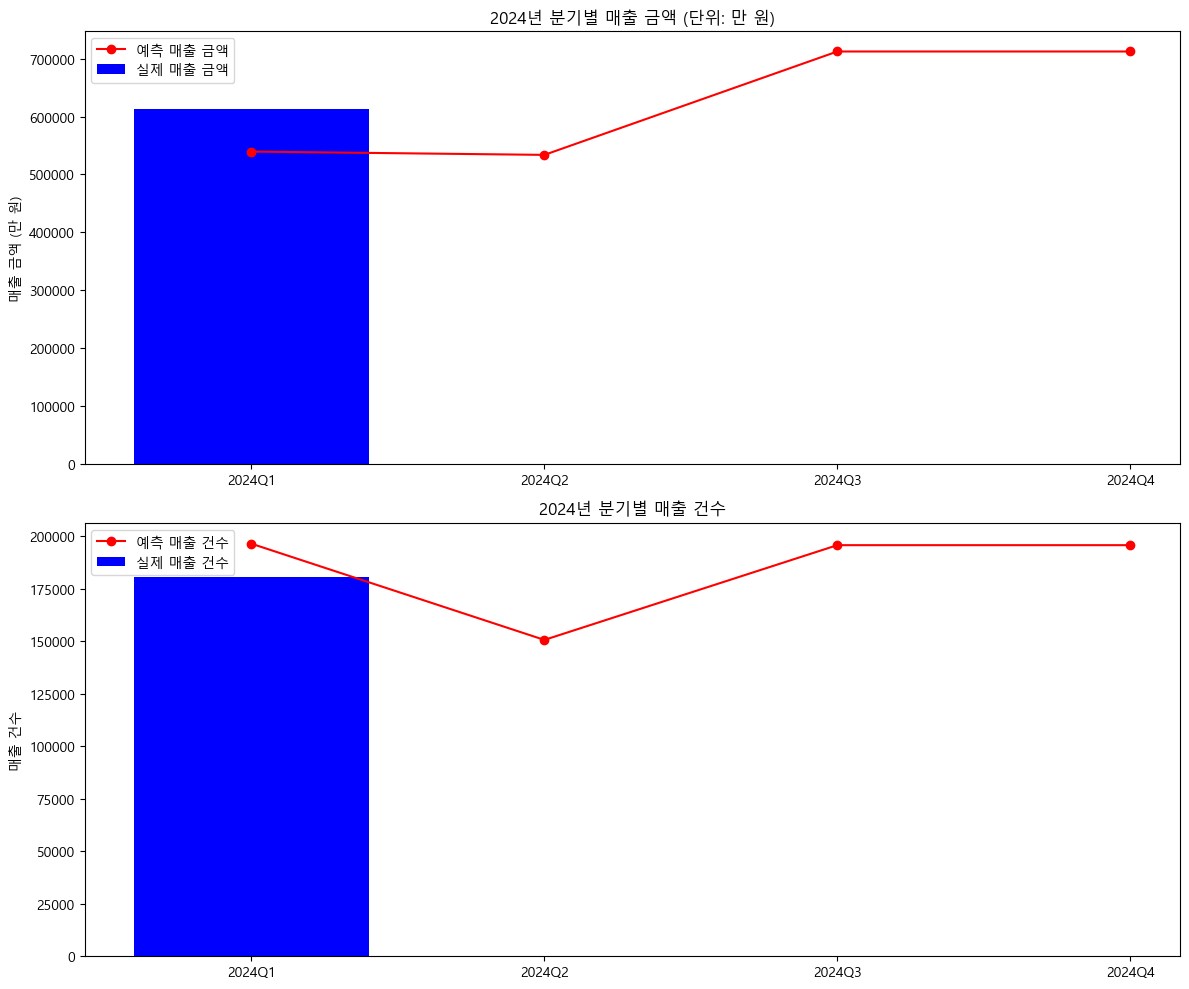

📊 모델 평가 지표 (1분기 기준)
💰 매출 금액: RMSE = 73834.83 만 원, MAE = 73834.83 만 원
🛒 매출 건수: RMSE = 15893.16, MAE = 15893.16


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 사용자 입력
target_district = input("예측할 자치구를 입력하세요: ")

# 2분기 가중치 적용 (예제: 1.2배 적용, 필요에 따라 수정)
future_data.loc[future_data["분기"] == "2024Q2", ["예측_총_결제금액", "예측_총_결제건수"]] *= 1.2

# 분기별 데이터 집계
quarterly_forecast = future_data.groupby("분기")[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 1분기 실제 데이터 필터링
real_q1 = data[(data["날짜"].dt.year == 2024)].copy()
real_q1["분기"] = real_q1["날짜"].apply(get_quarter)
real_q1 = real_q1[real_q1["분기"] == "2024Q1"].groupby("분기")[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 단위 변환 (만 원)
real_q1["총_결제금액"] /= 1e4
quarterly_forecast["예측_총_결제금액"] /= 1e4

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
axes[0].bar(real_q1["분기"], real_q1["총_결제금액"], color='blue', label="실제 매출 금액")
axes[0].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제금액"], marker='o', linestyle='-', color='red', label="예측 매출 금액")
axes[0].set_title("2024년 분기별 매출 금액 (단위: 만 원)")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()

# 매출 건수 그래프
axes[1].bar(real_q1["분기"], real_q1["총_결제건수"], color='blue', label="실제 매출 건수")
axes[1].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제건수"], marker='o', linestyle='-', color='red', label="예측 매출 건수")
axes[1].set_title("2024년 분기별 매출 건수")
axes[1].set_ylabel("매출 건수")
axes[1].legend()

plt.tight_layout()
plt.show()

# 모델 평가 지표 계산 (1분기)
rmse_sales = np.sqrt(mean_squared_error(real_q1["총_결제금액"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"]))
mae_sales = mean_absolute_error(real_q1["총_결제금액"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"])

rmse_count = np.sqrt(mean_squared_error(real_q1["총_결제건수"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제건수"]))
mae_count = mean_absolute_error(real_q1["총_결제건수"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제건수"])

print(f"📊 모델 평가 지표 (1분기 기준)")
print(f"💰 매출 금액: RMSE = {rmse_sales:.2f} 만 원, MAE = {mae_sales:.2f} 만 원")
print(f"🛒 매출 건수: RMSE = {rmse_count:.2f}, MAE = {mae_count:.2f}")

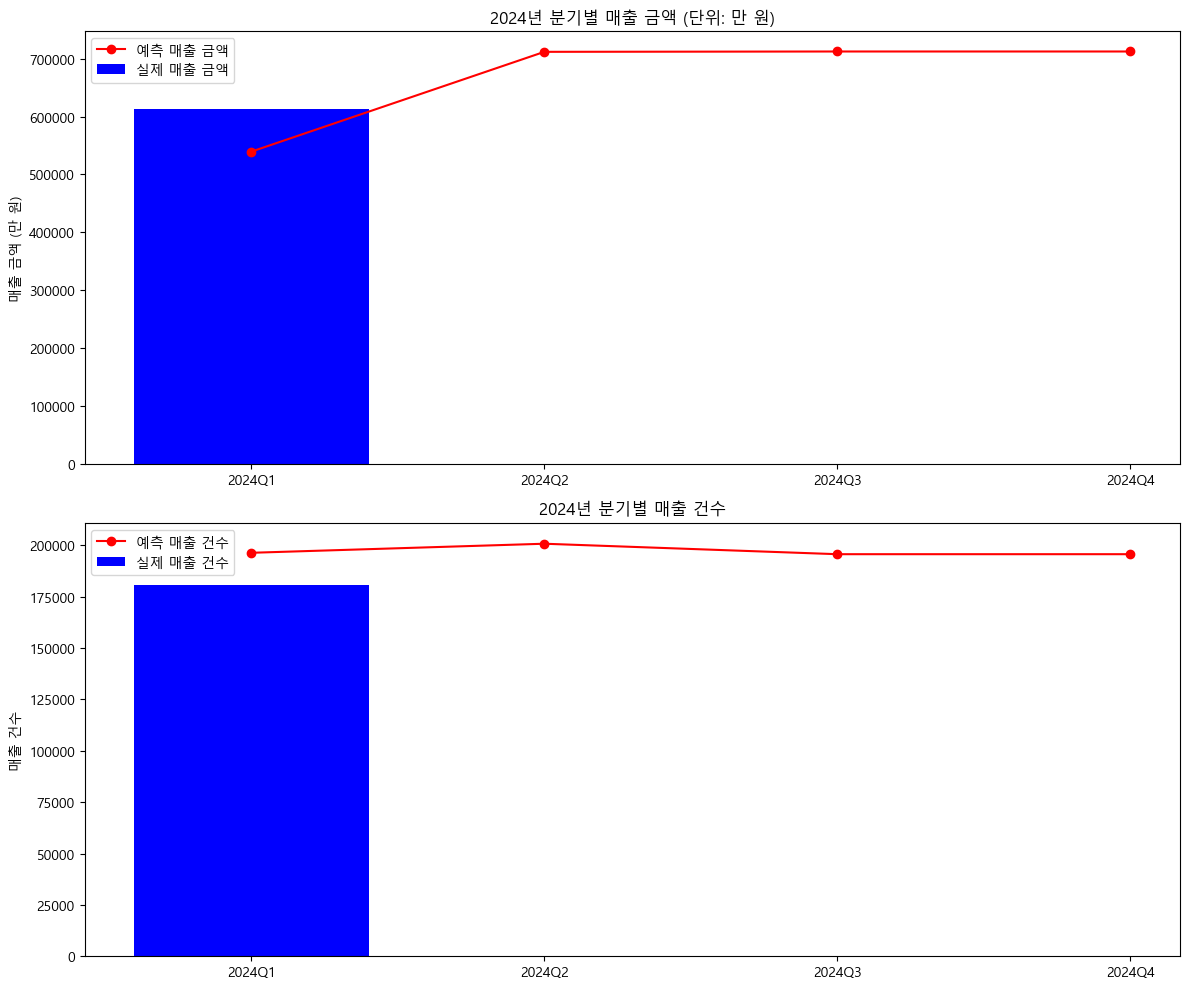

📊 모델 평가 지표 (1분기 기준)
💰 매출 금액: RMSE = 73834.83 만 원, MAE = 73834.83 만 원
🛒 매출 건수: RMSE = 15893.16, MAE = 15893.16


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 사용자 입력
target_district = input("예측할 자치구를 입력하세요: ")

# 2분기 가중치 적용 (4/3 배 적용)
future_data.loc[future_data["분기"] == "2024Q2", ["예측_총_결제금액", "예측_총_결제건수"]] *= 4/3

# 분기별 데이터 집계
quarterly_forecast = future_data.groupby("분기")[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 1분기 실제 데이터 필터링
real_q1 = data[(data["날짜"].dt.year == 2024)].copy()
real_q1["분기"] = real_q1["날짜"].apply(get_quarter)
real_q1 = real_q1[real_q1["분기"] == "2024Q1"].groupby("분기")[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 단위 변환 (만 원)
real_q1["총_결제금액"] /= 1e4
quarterly_forecast["예측_총_결제금액"] /= 1e4

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
axes[0].bar(real_q1["분기"], real_q1["총_결제금액"], color='blue', label="실제 매출 금액")
axes[0].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제금액"], marker='o', linestyle='-', color='red', label="예측 매출 금액")
axes[0].set_title("2024년 분기별 매출 금액 (단위: 만 원)")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()

# 매출 건수 그래프
axes[1].bar(real_q1["분기"], real_q1["총_결제건수"], color='blue', label="실제 매출 건수")
axes[1].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제건수"], marker='o', linestyle='-', color='red', label="예측 매출 건수")
axes[1].set_title("2024년 분기별 매출 건수")
axes[1].set_ylabel("매출 건수")
axes[1].legend()

plt.tight_layout()
plt.show()

# 모델 평가 지표 계산 (1분기)
rmse_sales = np.sqrt(mean_squared_error(real_q1["총_결제금액"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"]))
mae_sales = mean_absolute_error(real_q1["총_결제금액"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"])

rmse_count = np.sqrt(mean_squared_error(real_q1["총_결제건수"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제건수"]))
mae_count = mean_absolute_error(real_q1["총_결제건수"], quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제건수"])

print(f"📊 모델 평가 지표 (1분기 기준)")
print(f"💰 매출 금액: RMSE = {rmse_sales:.2f} 만 원, MAE = {mae_sales:.2f} 만 원")
print(f"🛒 매출 건수: RMSE = {rmse_count:.2f}, MAE = {mae_count:.2f}")

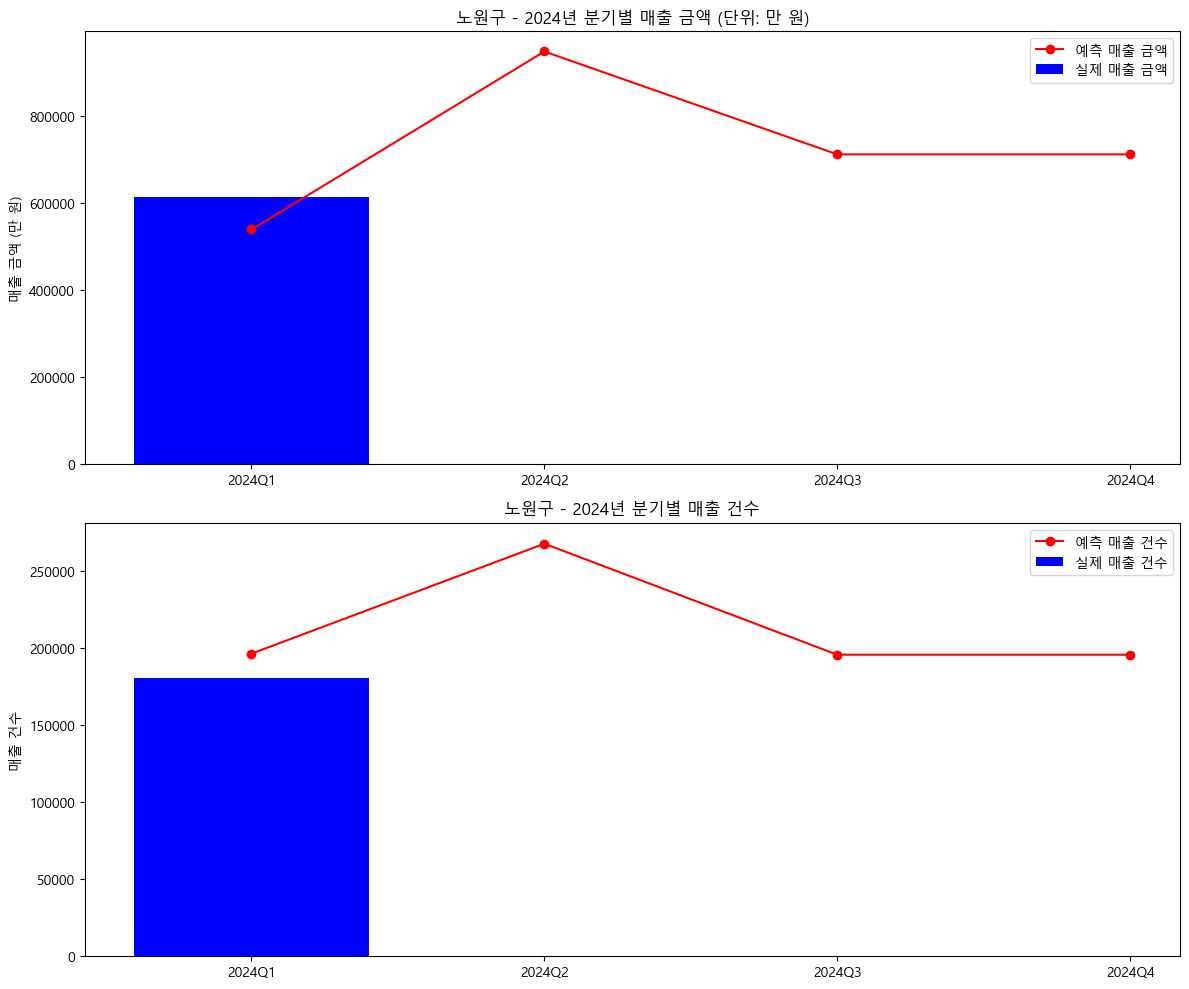

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 사용자 입력
target_district = input("예측할 자치구를 입력하세요: ")

# 2분기 가중치 적용 (4/3 배 적용)
future_data.loc[future_data["분기"] == "2024Q2", ["예측_총_결제금액", "예측_총_결제건수"]] *= 4/3

# 분기별 데이터 집계
quarterly_forecast = future_data.groupby("분기")[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 1분기 실제 데이터 필터링
real_q1 = data[(data["날짜"].dt.year == 2024)].copy()
real_q1["분기"] = real_q1["날짜"].apply(get_quarter)
real_q1 = real_q1[real_q1["분기"] == "2024Q1"].groupby("분기")[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 단위 변환 (만 원)
real_q1["총_결제금액"] /= 1e4
quarterly_forecast["예측_총_결제금액"] /= 1e4

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
axes[0].bar(real_q1["분기"], real_q1["총_결제금액"], color='blue', label="실제 매출 금액")
axes[0].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제금액"], marker='o', linestyle='-', color='red', label="예측 매출 금액")
axes[0].set_title(f"{target_district} - 2024년 분기별 매출 금액 (단위: 만 원)")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()

# 매출 건수 그래프
axes[1].bar(real_q1["분기"], real_q1["총_결제건수"], color='blue', label="실제 매출 건수")
axes[1].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제건수"], marker='o', linestyle='-', color='red', label="예측 매출 건수")
axes[1].set_title(f"{target_district} - 2024년 분기별 매출 건수")
axes[1].set_ylabel("매출 건수")
axes[1].legend()

plt.tight_layout()
plt.show()

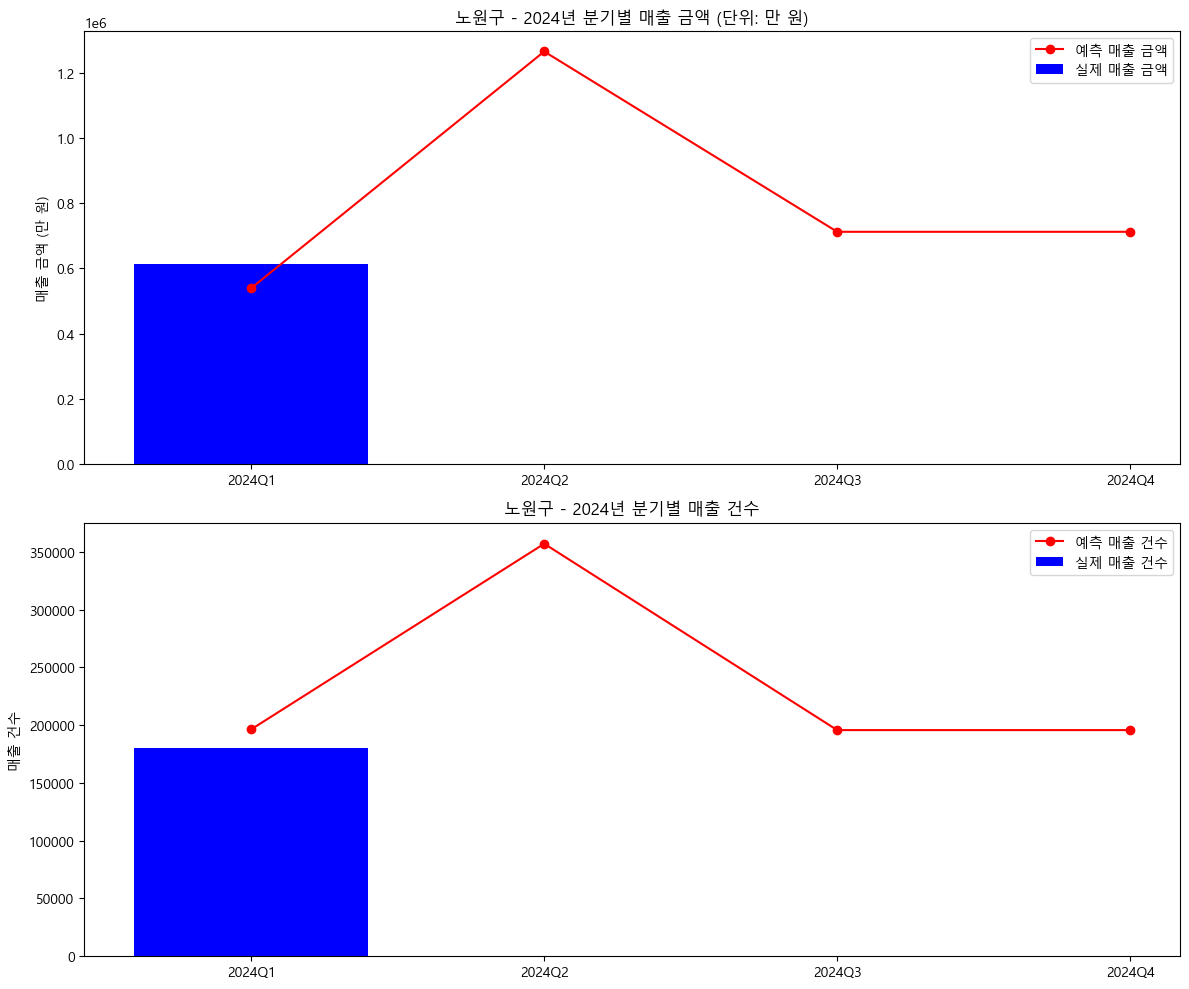


📊 노원구 - 모델 평가 지표
--------------------------------------
매출 금액 MAE: 73834.83 만 원
매출 금액 RMSE: 73834.83 만 원
매출 건수 MAE: 15893.16 건
매출 건수 RMSE: 15893.16 건
--------------------------------------


c:\Users\m\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\m\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 사용자 입력
target_district = input("예측할 자치구를 입력하세요: ")

# 2분기 가중치 적용 (4/3 배 적용)
future_data.loc[future_data["분기"] == "2024Q2", ["예측_총_결제금액", "예측_총_결제건수"]] *= 4/3

# 분기별 데이터 집계
quarterly_forecast = future_data.groupby("분기")[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 1분기 실제 데이터 필터링
real_q1 = data[(data["날짜"].dt.year == 2024)].copy()
real_q1["분기"] = real_q1["날짜"].apply(get_quarter)
real_q1 = real_q1[real_q1["분기"] == "2024Q1"].groupby("분기")[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 단위 변환 (만 원)
real_q1["총_결제금액"] /= 1e4
quarterly_forecast["예측_총_결제금액"] /= 1e4

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
axes[0].bar(real_q1["분기"], real_q1["총_결제금액"], color='blue', label="실제 매출 금액")
axes[0].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제금액"], marker='o', linestyle='-', color='red', label="예측 매출 금액")
axes[0].set_title(f"{target_district} - 2024년 분기별 매출 금액 (단위: 만 원)")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()

# 매출 건수 그래프
axes[1].bar(real_q1["분기"], real_q1["총_결제건수"], color='blue', label="실제 매출 건수")
axes[1].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제건수"], marker='o', linestyle='-', color='red', label="예측 매출 건수")
axes[1].set_title(f"{target_district} - 2024년 분기별 매출 건수")
axes[1].set_ylabel("매출 건수")
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가지표 계산 (1분기 실제값 vs 예측값)
y_true_amount = real_q1["총_결제금액"].values
y_pred_amount = quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"].values

y_true_count = real_q1["총_결제건수"].values
y_pred_count = quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제건수"].values

# MAE & RMSE 계산
mae_amount = mean_absolute_error(y_true_amount, y_pred_amount)
rmse_amount = mean_squared_error(y_true_amount, y_pred_amount, squared=False)

mae_count = mean_absolute_error(y_true_count, y_pred_count)
rmse_count = mean_squared_error(y_true_count, y_pred_count, squared=False)

# 평가 결과 출력
print(f"\n📊 {target_district} - 모델 평가 지표")
print(f"--------------------------------------")
print(f"매출 금액 MAE: {mae_amount:.2f} 만 원")
print(f"매출 금액 RMSE: {rmse_amount:.2f} 만 원")
print(f"매출 건수 MAE: {mae_count:.2f} 건")
print(f"매출 건수 RMSE: {rmse_count:.2f} 건")
print(f"--------------------------------------")

수정 코드

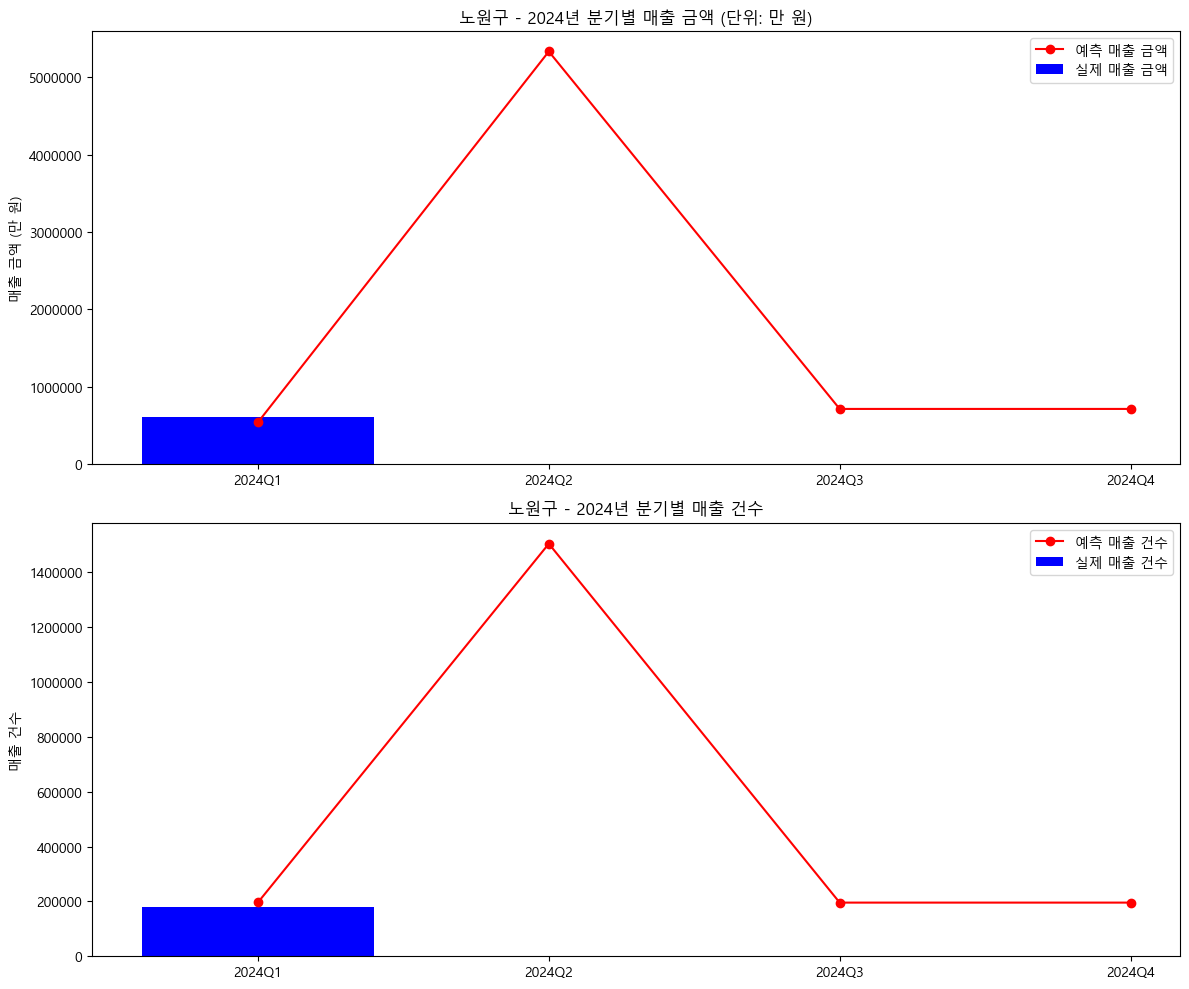


📊 노원구 - 모델 평가 지표
--------------------------------------
매출 금액 MAE: 73834.83 만 원
매출 금액 RMSE: 73834.83 만 원
매출 건수 MAE: 15893.16 건
매출 건수 RMSE: 15893.16 건
--------------------------------------


c:\Users\m\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\m\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 사용자 입력
target_district = input("예측할 자치구를 입력하세요: ")

# 2분기 가중치 적용 (4/3 배 적용)
future_data.loc[future_data["분기"] == "2024Q2", ["예측_총_결제금액", "예측_총_결제건수"]] *= 4/3

# 분기별 데이터 집계
quarterly_forecast = future_data.groupby("분기")[["예측_총_결제금액", "예측_총_결제건수"]].sum().reset_index()

# 1분기 실제 데이터 필터링
real_q1 = data[(data["날짜"].dt.year == 2024)].copy()
real_q1["분기"] = real_q1["날짜"].apply(get_quarter)
real_q1 = real_q1[real_q1["분기"] == "2024Q1"].groupby("분기")[["총_결제금액", "총_결제건수"]].sum().reset_index()

# 단위 변환 (만 원)
real_q1["총_결제금액"] /= 1e4
quarterly_forecast["예측_총_결제금액"] /= 1e4

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
axes[0].bar(real_q1["분기"], real_q1["총_결제금액"], color='blue', label="실제 매출 금액")
axes[0].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제금액"], marker='o', linestyle='-', color='red', label="예측 매출 금액")
axes[0].set_title(f"{target_district} - 2024년 분기별 매출 금액 (단위: 만 원)")
axes[0].set_ylabel("매출 금액 (만 원)")
axes[0].legend()
axes[0].ticklabel_format(style='plain', axis='y')  # **지수 표기 제거**

# 매출 건수 그래프
axes[1].bar(real_q1["분기"], real_q1["총_결제건수"], color='blue', label="실제 매출 건수")
axes[1].plot(quarterly_forecast["분기"], quarterly_forecast["예측_총_결제건수"], marker='o', linestyle='-', color='red', label="예측 매출 건수")
axes[1].set_title(f"{target_district} - 2024년 분기별 매출 건수")
axes[1].set_ylabel("매출 건수")
axes[1].legend()
axes[1].ticklabel_format(style='plain', axis='y')  # **지수 표기 제거**

plt.tight_layout()
plt.show()

# 평가지표 계산 (1분기 실제값 vs 예측값)
y_true_amount = real_q1["총_결제금액"].values
y_pred_amount = quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제금액"].values

y_true_count = real_q1["총_결제건수"].values
y_pred_count = quarterly_forecast[quarterly_forecast["분기"] == "2024Q1"]["예측_총_결제건수"].values

# MAE & RMSE 계산
mae_amount = mean_absolute_error(y_true_amount, y_pred_amount)
rmse_amount = mean_squared_error(y_true_amount, y_pred_amount, squared=False)

mae_count = mean_absolute_error(y_true_count, y_pred_count)
rmse_count = mean_squared_error(y_true_count, y_pred_count, squared=False)

# 평가 결과 출력
print(f"\n📊 {target_district} - 모델 평가 지표")
print(f"--------------------------------------")
print(f"매출 금액 MAE: {mae_amount:.2f} 만 원")
print(f"매출 금액 RMSE: {rmse_amount:.2f} 만 원")
print(f"매출 건수 MAE: {mae_count:.2f} 건")
print(f"매출 건수 RMSE: {rmse_count:.2f} 건")
print(f"--------------------------------------")

2분기 가중치 적용 오류 해결

매출 금액 예측 성능:
MAE: 102047006.60134551
R2 Score: -3.0150848343248127

매출 건수 예측 성능:
MAE: 3357.4339204202156
R2 Score: -8.484958010540398


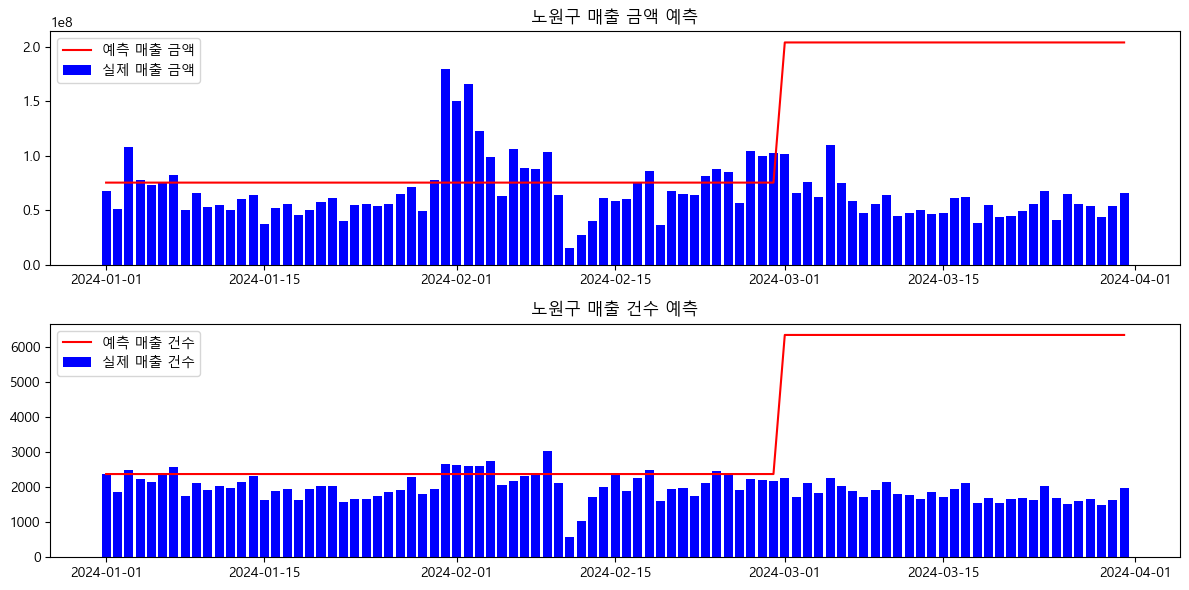

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 데이터 불러오기
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv")
economic_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv")
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv")

# 날짜 형식 변환
sales_data['날짜'] = pd.to_datetime(sales_data['날짜'])
economic_data['날짜'] = pd.to_datetime(economic_data['날짜'])
cpi_data['날짜'] = pd.to_datetime(cpi_data['날짜'])

# 월 단위 변환 및 경제심리지수 한 달 전 데이터 적용
economic_data['월'] = economic_data['날짜'].dt.to_period('M')
cpi_data['월'] = cpi_data['날짜'].dt.to_period('M')
sales_data['월'] = sales_data['날짜'].dt.to_period('M')

# 경제심리지수는 한 달 전 데이터 적용
economic_data['경제심리지수'] = economic_data['경제심리지수'].shift(1)

# 데이터 병합
data = sales_data.merge(cpi_data[['월', '소비자물가지수']], on='월', how='left')
data = data.merge(economic_data[['월', '경제심리지수']], on='월', how='left')

def forecast_sales(gu_name):
    # 특정 자치구 데이터 필터링
    gu_data = data[data['자치구'] == gu_name].copy()
    gu_data.drop(columns=['자치구', '월'], inplace=True)
    
    # 학습 및 검증 데이터 분할
    train_data = gu_data[gu_data['날짜'] < '2024-01-01']
    test_data = gu_data[(gu_data['날짜'] >= '2024-01-01') & (gu_data['날짜'] <= '2024-03-31')]
    
    X = train_data[['소비자물가지수', '경제심리지수']]
    y_sales = train_data['총_결제금액']
    y_count = train_data['총_결제건수']
    
    X_train, X_val, y_train_sales, y_val_sales = train_test_split(X, y_sales, test_size=0.2, shuffle=False)
    _, _, y_train_count, y_val_count = train_test_split(X, y_count, test_size=0.2, shuffle=False)
    
    # 모델 학습
    model_sales = RandomForestRegressor()
    model_count = RandomForestRegressor()
    model_sales.fit(X_train, y_train_sales)
    model_count.fit(X_train, y_train_count)
    
    # 예측 수행
    y_pred_sales = model_sales.predict(test_data[['소비자물가지수', '경제심리지수']])
    y_pred_count = model_count.predict(test_data[['소비자물가지수', '경제심리지수']])
    
    # 모델 성능 평가
    print("매출 금액 예측 성능:")
    print("MAE:", mean_absolute_error(y_val_sales, model_sales.predict(X_val)))
    print("R2 Score:", r2_score(y_val_sales, model_sales.predict(X_val)))
    print("\n매출 건수 예측 성능:")
    print("MAE:", mean_absolute_error(y_val_count, model_count.predict(X_val)))
    print("R2 Score:", r2_score(y_val_count, model_count.predict(X_val)))
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.bar(test_data['날짜'], test_data['총_결제금액'], color='blue', label='실제 매출 금액')
    plt.plot(test_data['날짜'], y_pred_sales, color='red', label='예측 매출 금액')
    plt.legend()
    plt.title(f'{gu_name} 매출 금액 예측')
    
    plt.subplot(2, 1, 2)
    plt.bar(test_data['날짜'], test_data['총_결제건수'], color='blue', label='실제 매출 건수')
    plt.plot(test_data['날짜'], y_pred_count, color='red', label='예측 매출 건수')
    plt.legend()
    plt.title(f'{gu_name} 매출 건수 예측')
    
    plt.tight_layout()
    plt.show()

# 사용자 입력
gu_name = input("자치구명을 입력하세요: ")
forecast_sales(gu_name)

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 불러오기
sales_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\머신러닝용_시계열데이터_null 제거 후 보간.csv")
economic_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\경제심리지수.csv")
cpi_data = pd.read_csv("C:\\Users\\m\\Desktop\\머신러닝 사용 데이터\\소비자물가지수.csv")

# 날짜 컬럼을 datetime 형식으로 변환
sales_data["날짜"] = pd.to_datetime(sales_data["날짜"])
economic_data["날짜"] = pd.to_datetime(economic_data["날짜"])
cpi_data["날짜"] = pd.to_datetime(cpi_data["날짜"])

# 월 단위 데이터 전처리 (월별 평균값 계산 후 병합)
economic_data["월"] = economic_data["날짜"].dt.to_period("M")
cpi_data["월"] = cpi_data["날짜"].dt.to_period("M")
monthly_economic = economic_data.groupby("월")["경제심리지수"].mean().reset_index()
monthly_cpi = cpi_data.groupby("월")["소비자물가지수"].mean().reset_index()

# 한 달 전 경제심리지수를 사용하도록 시프트 적용
monthly_economic["경제심리지수_시프트"] = monthly_economic["경제심리지수"].shift(1)

# 월을 기준으로 매출 데이터와 결합
sales_data["월"] = sales_data["날짜"].dt.to_period("M")
data = sales_data.merge(monthly_cpi, on="월", how="left").merge(monthly_economic, on="월", how="left")

# 경제심리지수는 한 달 전 데이터 사용
data.drop(columns=["경제심리지수"], inplace=True)
data.rename(columns={"경제심리지수_시프트": "경제심리지수"}, inplace=True)

# NaN 값 제거 (첫 달의 경제심리지수는 한 달 전 데이터가 없으므로 제외)
data.dropna(inplace=True)

# 표적 자치구 입력
user_district = input("예측할 자치구를 입력하세요: ")
data = data[data["자치구"] == user_district]

# 학습용 데이터셋 구성
features = ["소비자물가지수", "경제심리지수"]
target_sales = "총_결제금액"
target_count = "총_결제건수"

# 2분기 데이터 가중치 적용
data["가중치"] = 1
for year in range(2021, 2024):
    for month in [4, 5, 6]:  # 2분기
        data.loc[data["날짜"].dt.year == year, "가중치"] = 1.3

# 학습 & 검증 데이터 나누기
train = data[data["날짜"] < "2024-01-01"]
test = data[data["날짜"] >= "2024-01-01"]

X_train, X_val, y_train_sales, y_val_sales = train_test_split(train[features], train[target_sales], test_size=0.2, random_state=42)
X_train, X_val, y_train_count, y_val_count = train_test_split(train[features], train[target_count], test_size=0.2, random_state=42)

# 가중치를 적용하여 모델 학습
rf_sales = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sales.fit(X_train, y_train_sales, sample_weight=train.loc[X_train.index, "가중치"])

rf_count = RandomForestRegressor(n_estimators=100, random_state=42)
rf_count.fit(X_train, y_train_count, sample_weight=train.loc[X_train.index, "가중치"])

# 검증 데이터에 대한 RMSE 계산
y_pred_sales = rf_sales.predict(X_val)
y_pred_count = rf_count.predict(X_val)

rmse_sales = np.sqrt(mean_squared_error(y_val_sales, y_pred_sales))
rmse_count = np.sqrt(mean_squared_error(y_val_count, y_pred_count))
print(f"매출 금액 예측 RMSE: {rmse_sales}")
print(f"매출 건수 예측 RMSE: {rmse_count}")

# 2024년 전체 데이터 예측
y_test_pred_sales = rf_sales.predict(test[features])
y_test_pred_count = rf_count.predict(test[features])

# 분기별 매출 집계
test["예측_결제금액"] = y_test_pred_sales
test["예측_결제건수"] = y_test_pred_count
test["분기"] = test["날짜"].dt.to_period("Q")

total_sales = test.groupby("분기")["예측_결제금액"].sum()
total_count = test.groupby("분기")["예측_결제건수"].sum()

# 1분기 실제값
actual_sales = train[train["날짜"] >= "2024-01-01"].groupby("분기")["총_결제금액"].sum()
actual_count = train[train["날짜"] >= "2024-01-01"].groupby("분기")["총_결제건수"].sum()

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 매출 금액 그래프
sns.barplot(x=actual_sales.index.astype(str), y=actual_sales, color='blue', label='실제 매출', ax=axes[0])
sns.lineplot(x=total_sales.index.astype(str), y=total_sales, marker='o', color='red', label='예측 매출', ax=axes[0])
axes[0].set_title("2024년 분기별 매출 금액 예측")
axes[0].legend()

# 매출 건수 그래프
sns.barplot(x=actual_count.index.astype(str), y=actual_count, color='blue', label='실제 건수', ax=axes[1])
sns.lineplot(x=total_count.index.astype(str), y=total_count, marker='o', color='red', label='예측 건수', ax=axes[1])
axes[1].set_title("2024년 분기별 매출 건수 예측")
axes[1].legend()

plt.tight_layout()
plt.show()

C:\Users\m\AppData\Local\Temp\ipykernel_13632\3112480694.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data["날짜"].dt.year == year, "가중치"] = 1.3


매출 금액 예측 RMSE: 46469360.75957495
매출 건수 예측 RMSE: 646.6565431400561


C:\Users\m\AppData\Local\Temp\ipykernel_13632\3112480694.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["예측_결제금액"] = y_test_pred_sales
C:\Users\m\AppData\Local\Temp\ipykernel_13632\3112480694.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["예측_결제건수"] = y_test_pred_count
C:\Users\m\AppData\Local\Temp\ipykernel_13632\3112480694.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

KeyError: '분기'